In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content
!rm -r /content/datasets/
!mkdir datasets
%cd datasets
!nvidia-smi

/content
rm: cannot remove '/content/datasets/': No such file or directory
/content/datasets
Thu Apr  7 11:07:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------------

Create videos and labels

In [3]:
%cd /content/datasets
!cp '/content/drive/MyDrive/MInf/ug_data.zip' '.'
!unzip 'ug_data.zip' -d '.'
%rm /content/datasets/ug_data.zip
# pg data
%cd /content/datasets
!cp '/content/drive/MyDrive/MInf/pg_data.zip' '.'
!unzip 'pg_data.zip' -d '.'
%rm /content/datasets/pg_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./pg_data/2_O2CKEmhJ/img_00075.jpg  
  inflating: ./pg_data/2_O2CKEmhJ/img_00061.jpg  
  inflating: ./pg_data/2_O2CKEmhJ/img_00049.jpg  
  inflating: ./pg_data/2_O2CKEmhJ/img_00101.jpg  
  inflating: ./pg_data/2_O2CKEmhJ/img_00115.jpg  
  inflating: ./pg_data/2_O2CKEmhJ/img_00129.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00118.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00087.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00093.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00044.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00050.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00078.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00079.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00051.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00045.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00092.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00086.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00090.jpg  
  inflating: ./pg_data/2_6TWhwe0E/img_00084.jpg  

Experiment 1

Environment Setup

In [4]:
%cd /content/
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [5]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmaction2
!rm -rf mmaction2
!git clone https://github.com/open-mmlab/mmaction2.git
%cd mmaction2

!pip install -e .

# Install some optional requirements
!pip install -r requirements/optional.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.2 MB/s eta 0:16:24tcmalloc: large alloc 1147494400 bytes == 0x5624af98e000 @  0x7f9c0ad05615 0x56247562a17c 0x56247570a47a 0x56247562cf9d 0x56247571ed4d 0x5624756a0ec8 0x56247569ba2e 0x56247562e88a 0x5624756a0d30 0x56247569ba2e 0x56247562e88a 0x56247569d719 0x56247571fb76 0x56247569cd95 0x56247571fb76 0x56247569cd95 0x56247571fb76 0x56247569cd95 0x56247562ece9 0x562475672579 0x56247562d902 0x5624756a0c4d 0x56247569ba2e 0x56247562e88a 0x56247569d719 0x56247569ba2e 0x56247562e88a 0x56247569c8f6 0x56247562e7aa 0x56247569cb4f 0x56247569ba2e
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:31tcmalloc: large alloc 1434370048 bytes == 0x5624f3fe4000 @  0x7f9c0ad05615 0x56247562a17c 0x56247570a47a 0x56247562cf9d 0x56247571ed4d 0x5624756a0ec8 0x56247569ba2e 0x56247562e88a 0x5624756a0d30 0x56247569ba2e 0x56247562e88a 0x56247569d719 0x56247571fb76 0x56247569cd

In [6]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.23.0
11.1
GCC 7.3


Config for each algorithm

In [7]:
def exp3_config(seq, split, epoch, lr, optimizer):
    #  TPN
    cfg = Config.fromfile('./configs/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb.py')
    data_path = '/content/datasets/'
    if seq == 1:
        ann_path = '/content/drive/MyDrive/MInf/exp3/seq_1/'
    elif seq == 2:
        ann_path = '/content/drive/MyDrive/MInf/exp3/seq_2/'
    # Modify dataset type and path
    cfg.dataset_type = 'RawframeDataset'
    # cfg.dataset_type = 'my'
    cfg.data_root = data_path
    cfg.data_root_val = data_path
    cfg.ann_file_train = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.ann_file_val = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.ann_file_test = ann_path + 'test.txt'

    cfg.data.test.type = 'RawframeDataset'
    # cfg.data.test.type = 'my'
    cfg.data.test.ann_file = ann_path + 'test.txt'
    cfg.data.test.data_prefix = '/content/datasets/'

    cfg.data.train.type = 'RawframeDataset'
    # cfg.data.train.type = 'my'
    cfg.data.train.ann_file = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.data.train.data_prefix = data_path

    cfg.data.val.type = 'RawframeDataset'
    # cfg.data.val.type = 'my'
    cfg.data.val.ann_file = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.data.val.data_prefix = data_path
    # The flag is used to determine whether it is omnisource training
    cfg.setdefault('omnisource', False)
    # Modify num classes of the model in cls_head
    cfg.model.cls_head.num_classes = 10
    # We can use the pre-trained TSN model

    # Set up working dir to save files and logs.
    cfg.work_dir = './tutorial_exps'

    # The original learning rate (LR) is set for 8-GPU training.
    # We divide it by 8 since we only use one GPU.
    # cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
    # batch size
    cfg.data.videos_per_gpu = 16
    cfg.data.workers_per_gpu = 4

    # cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
    cfg.optimizer.lr = lr
    if optimizer == 'Adam':     
        # optimizer
        optimizer = dict(
            type='Adam',  # Type of optimizer, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
            lr=lr,  # Learning rate, see detail usages of the parameters in the documentation of PyTorch
            weight_decay=0.0001)  # Weight decay of Adam
        optimizer_config = dict(  # Config used to build the optimizer hook
            grad_clip=None)  # Most of the methods do not use gradient clip
        # learning policy
        lr_config = dict(  # Learning rate scheduler config used to register LrUpdater hook
            policy='step',  # Policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9
            step=7)  # Steps to decay the learning rate      
        cfg.optimizer = optimizer
    cfg.total_epochs = epoch
    # cfg.batch_size = 50

    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 5
    # We can set the log print interval to reduce the the times of printing log
    cfg.log_config.interval = 5

    # Set seed thus the results are more reproducible
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # # Save the best
    # eval_config = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    # metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
    
    
    cfg.evaluation = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
    cfg.evaluation.save_best='auto'
     
    # We can initialize the logger for training and have a look
    # at the final config used for training
    # print(f'Config:\n{cfg.pretty_text}')
    return cfg

In [8]:
def train(cfg):
    # Build the dataset
    datasets = [build_dataset(cfg.data.train)]

    # Build the recognizer
    model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

    # Create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    train_model(model, datasets, cfg, distributed=False, validate=True)
    return model

In [9]:
from sklearn import metrics

def test(model, cfg):
    # Build a test dataloader
    dataset = build_dataset(cfg.data.test, dict(test_mode=True))
    data_loader = build_dataloader(
            dataset,
            videos_per_gpu=1,
            workers_per_gpu=4,
            # cfg.data.workers_per_gpu,
            dist=False,
            shuffle=False)


    model = MMDataParallel(model, device_ids=[0])

    outputs = single_gpu_test(model, data_loader)

    eval_config = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    metric_options=dict(top_k_accuracy=dict(topk=(1, 2))),)
    # cfg.evaluation

    
    # metric = dict(top_k_accuracy=dict(topk=(1, 2)))

    try:
        eval_config.pop('interval')
    except:
        print('no pop')
    eval_res = dataset.evaluate(outputs, **eval_config)
    # for name, val in eval_res.items():
    #     print(f'{name}: {val:.04f}')
    return outputs



In [10]:
from mmaction.core.evaluation.accuracy import top_k_accuracy

def cm(exp, outputs, split, optimizer, epoch, seq=1):
    y_true = []
    path = '';
    if exp == 1:
        path = '/content/drive/MyDrive/MInf/exp' + str(exp) + '/test_sp' + str(split) + '.txt'
    elif exp == 2:    
        path = '/content/drive/MyDrive/MInf/exp' + str(exp) + '/test.txt'
    elif exp ==3:
        path = '/content/drive/MyDrive/MInf/exp3/seq_' + str(seq) + '/test.txt'
   
    with open(path) as f:
        line = csv.reader(f, delimiter=' ')
        for i in line:
            y_true.append(int(i[2]))        
    y_pred = []
   
    for i in outputs:
        # max_val = max(i)
        max_idx = np.argmax(i)
        # print(max_idx)
        y_pred.append(max_idx)
    print(y_true[0])
    print(y_pred[0])
    # for i in range(10):
    #     print(str(i)+': ' + str(y_pred.count(i)))
    #     print(str(i)+': ' + str(y_true.count(i)))
    #     print()
    
    classes = [*range(10)]
    # top2 = top_k_accuracy(outputs, y_true, topk=(1,2,))
    # print(top2)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # df_cm = cmn.pivot("True", "Predicted")
    # cf_matrix = cf_matrix / cf_matrix.astype(np.float).sum(axis=1)
    # print(cf_matrix)
    df_cm = pd.DataFrame(cmn, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (12,7))    
    cm_plot = sn.heatmap(df_cm, annot=True)
    cm_plot.set_xlabel("Predicted", fontsize = 20)
    cm_plot.set_ylabel("True", fontsize = 20)
    plt.savefig('/content/drive/MyDrive/MInf/'+'exp'+str(exp)+'/sp'+str(split)+'_cm_'+optimizer+ '.pdf')
    plt.savefig('/content/exp' + str(exp)+ '_sp'+str(split)+ '_' + str(epoch)+'_cm.pdf')
    files.download('/content/exp' + str(exp)+ '_sp'+str(split)+ '_' + str(epoch)+'_cm.pdf')

In [11]:
%cd /content/mmaction2
from mmcv.runner import set_random_seed
from mmaction.datasets import rawframe_dataset
from mmcv import Config

import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

from google.colab import files

from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

import csv
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tools.analysis import analyze_logs as al

/content/mmaction2


In [12]:
def check_data(exp, split):
    train_check = []
    with open('/content/drive/MyDrive/MInf/exp' + str(exp) + '/train_sp' 
              + str(split) + '.txt') as f:
        line = csv.reader(f, delimiter=' ')
        for i in line:
            train_check.append(int(i[2]))
    print('exp '+ str(exp) + ' split '+ str(split) + ' train action count: ')    
    for i in range(10):
        print(str(i)+': ' + str(train_check.count(i)))
    print('')
    
    val_check = []
    with open('/content/drive/MyDrive/MInf/exp' + str(exp) + '/val_sp' 
              + str(split) + '.txt') as f:
        line = csv.reader(f, delimiter=' ')
        for i in line:
            val_check.append(int(i[2]))
    print('exp '+ str(exp) + ' split '+ str(split) + ' val action count: ')
    for i in range(10):
        print(str(i)+': ' + str(val_check.count(i)))
    print('')

    test_check = []
    with open('/content/drive/MyDrive/MInf/exp' + str(exp) + '/test_sp' 
              + str(split) + '.txt') as f:
        line = csv.reader(f, delimiter=' ')
        for i in line:
            test_check.append(int(i[2]))
    print('exp '+ str(exp) + ' split '+ str(split) + ' test action count:')    
    for i in range(10):
        print(str(i)+': ' + str(test_check.count(i)))
    print('')

    total_counts = []
    print('exp '+ str(exp) + ' total action count:')
    for i in range(10):
        total_count = train_check.count(i) + val_check.count(i) + test_check.count(i)
        print(str(i)+': ' + str(total_count))
        total_counts.append(total_count)
    
    return total_counts

In [13]:
def load_pth(model, epoch):
    pret_path = '/content/mmaction2/tutorial_exps/epoch_' + str(epoch) +'.pth'
    checkpoint = torch.load(pret_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [14]:
def exp2_config(split, epoch, lr, optimizer):
    #  TPN
    cfg = Config.fromfile('/content/mmaction2/configs/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb.py')
    data_path = '/content/datasets/ug_data/'
    ann_path = '/content/drive/MyDrive/MInf/exp2/'
    # rawframe_dataset.RawframeDataset.__init__.filename_tmpl = 'img_{:05}.png'


    # ann_train = 'train_sp'
    # video_path = '/content/without/rgb_without_videos/'
    # Modify dataset type and path
    cfg.dataset_type = 'RawframeDataset'
    # cfg.dataset_type = 'my'
    cfg.data_root = data_path
    cfg.data_root_val = data_path
    cfg.ann_file_train = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.ann_file_val = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.ann_file_test = ann_path + 'test.txt'

    cfg.data.test.type = 'RawframeDataset'
    # cfg.data.test.type = 'my'
    cfg.data.test.ann_file = ann_path + 'test.txt'
    cfg.data.test.data_prefix = '/content/datasets/pg_data/'

    cfg.data.train.type = 'RawframeDataset'
    # cfg.data.train.type = 'my'
    cfg.data.train.ann_file = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.data.train.data_prefix = data_path

    cfg.data.val.type = 'RawframeDataset'
    # cfg.data.val.type = 'my'
    cfg.data.val.ann_file = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.data.val.data_prefix = data_path

    # The flag is used to determine whether it is omnisource training
    cfg.setdefault('omnisource', False)
    # Modify num classes of the model in cls_head
    cfg.model.cls_head.num_classes = 10
    # cfg.model.filename_tmpl = 'img_{:05}.png'
    # We can use the pre-trained TSN model
    # cfg.load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'

    # Set up working dir to save files and logs.
    cfg.work_dir = './tutorial_exps'

    # The original learning rate (LR) is set for 8-GPU training.
    # We divide it by 8 since we only use one GPU.
    # cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
    # batch size
    cfg.data.videos_per_gpu = 16
    cfg.data.workers_per_gpu=4

    # cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
    cfg.optimizer.lr = lr
    if optimizer == 'Adam':     
        # optimizer
        optimizer = dict(
            type='Adam',  # Type of optimizer, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
            lr=lr,  # Learning rate, see detail usages of the parameters in the documentation of PyTorch
            weight_decay=0.0001)  # Weight decay of Adam
        optimizer_config = dict(  # Config used to build the optimizer hook
            grad_clip=None)  # Most of the methods do not use gradient clip
        # learning policy
        lr_config = dict(  # Learning rate scheduler config used to register LrUpdater hook
            policy='step',  # Policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9
            step=7)  # Steps to decay the learning rate      
        cfg.optimizer = optimizer
    cfg.total_epochs = epoch
    # cfg.batch_size = 50

    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 5
    # We can set the log print interval to reduce the the times of printing log
    cfg.log_config.interval = 5

    # Set seed thus the results are more reproducible
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # Save the best
    eval_config = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
    cfg.evaluation.save_best='auto'
    
    cfg.evaluation = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
     
    # We can initialize the logger for training and have a look
    # at the final config used for training
    print(f'Config:\n{cfg.pretty_text}')
    return cfg

# cfg = exp2_config(split=sp, epoch=epoch, lr=lr)

In [15]:
count = {}
for i in range(10):
    count[i] = 0

print(count)

for i in range(5):
    data = check_data(1, i)
    for j in range(10):
        count[j] += data[j]
print(count)


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
exp 1 split 0 train action count: 
0: 342
1: 100
2: 174
3: 240
4: 308
5: 229
6: 216
7: 31
8: 74
9: 78

exp 1 split 0 val action count: 
0: 113
1: 37
2: 59
3: 76
4: 109
5: 80
6: 70
7: 10
8: 23
9: 26

exp 1 split 0 test action count:
0: 118
1: 34
2: 59
3: 77
4: 104
5: 75
6: 73
7: 12
8: 22
9: 28

exp 1 total action count:
0: 573
1: 171
2: 292
3: 393
4: 521
5: 384
6: 359
7: 53
8: 119
9: 132
exp 1 split 1 train action count: 
0: 339
1: 102
2: 172
3: 238
4: 314
5: 232
6: 211
7: 30
8: 70
9: 78

exp 1 split 1 val action count: 
0: 118
1: 34
2: 59
3: 77
4: 104
5: 75
6: 73
7: 12
8: 22
9: 28

exp 1 split 1 test action count:
0: 116
1: 35
2: 61
3: 78
4: 103
5: 77
6: 75
7: 11
8: 27
9: 26

exp 1 total action count:
0: 573
1: 171
2: 292
3: 393
4: 521
5: 384
6: 359
7: 53
8: 119
9: 132
exp 1 split 2 train action count: 
0: 345
1: 103
2: 175
3: 234
4: 312
5: 227
6: 211
7: 32
8: 69
9: 80

exp 1 split 2 val action count: 
0: 116
1: 35
2: 61
3: 7

In [16]:
def tests_by_epochs(epochs, term, model, cfg, exp, sp, optimizer, seq):
    tests = [i for i in range(term,epochs+term, term)]
    for i in tests:
        model = load_pth(model, i)
        outputs = test(model, cfg)
        # print(outputs)
        cm(exp, outputs, sp, optimizer, i, seq=seq)

In [17]:
def train_by_epochs(exp, epochs, sp, optimizer, seq=1):
    torch.cuda.empty_cache()
    # configuration
    if exp == 1:
        cfg = exp1_config(split=sp, epoch=epoch, lr=lr, optimizer=optimizer)
    elif exp== 2:
        cfg = exp2_config(split=sp, epoch=epoch, lr=lr, optimizer=optimizer)
    elif exp == 3:
        cfg = exp3_config(seq= seq, split=sp, epoch=epoch, lr=lr, optimizer=optimizer)
    model = train(cfg)
    
    return cfg, model


In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()
# !nvidia-smi
%cd /content/mmaction2
exp = 1
sp = 2
epoch = 15
term = 5
lr = 0.001
optimizer = 'SGD'
sequence = 1
# check_data(3, 0)

/content/mmaction2


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 1.8 task/s, elapsed: 341s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.7233
top2_acc	0.8767

Evaluating mean_class_accuracy ...

mean_acc	0.6859
5
5


AttributeError: ignored

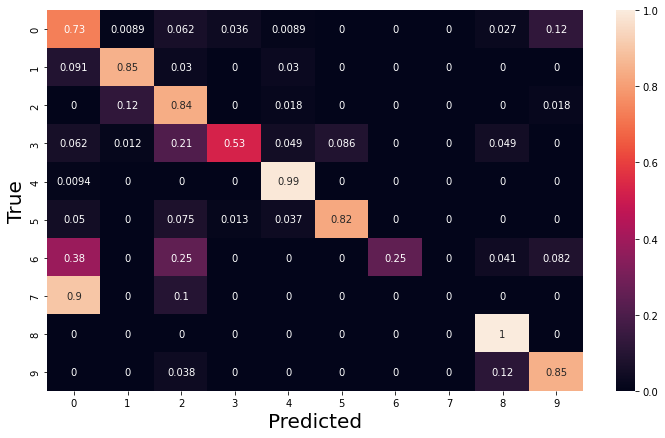

In [24]:
# cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(epoch, 10, model, cfg, exp, sp, optimizer, sequence)

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowOnly',
        depth=50,
        pretrained='torchvision://resnet50',
        lateral=False,
        out_indices=(2, 3),
        conv1_kernel=(1, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(0, 0, 1, 1),
        norm_eval=False),
    neck=dict(
        type='TPN',
        in_channels=(1024, 2048),
        out_channels=1024,
        spatial_modulation_cfg=dict(
            in_channels=(1024, 2048), out_channels=2048),
        temporal_modulation_cfg=dict(downsample_scales=(8, 8)),
        upsample_cfg=dict(scale_factor=(1, 1, 1)),
        downsample_cfg=dict(downsample_scale=(1, 1, 1)),
        level_fusion_cfg=dict(
            in_channels=(1024, 1024),
            mid_channels=(1024, 1024),
            out_channels=2048,
            downsample_scales=((1, 1, 1), (1, 1, 1))),
        aux_head_cfg=dict(out_channels=400, loss_weight=0.5)),
    cls_head=dict(
        

2022-04-07 11:14:20,239 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-04-07 11:14:20,980 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-07 11:14:25,750 - mmaction - INFO - Start running, host: root@6df227050a45, work_dir: /content/mmaction2/tutorial_exps
2022-04-07 11:14:25,751 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 30.6 task/s, elapsed: 14s, ETA:     0s

2022-04-07 11:22:04,834 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 11:22:04,837 - mmaction - INFO - 
top1_acc	0.7205
top2_acc	0.8977
2022-04-07 11:22:04,838 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 11:22:04,841 - mmaction - INFO - 
mean_acc	0.5483
2022-04-07 11:22:07,870 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-07 11:22:07,872 - mmaction - INFO - Best top1_acc is 0.7205 at 5 epoch.
2022-04-07 11:22:07,873 - mmaction - INFO - Epoch(val) [5][28]	top1_acc: 0.7205, top2_acc: 0.8977, mean_class_accuracy: 0.5483
2022-04-07 11:22:15,579 - mmaction - INFO - Epoch [6][5/107]	lr: 1.000e-02, eta: 1:05:31, time: 1.539, data_time: 0.750, memory: 12012, loss_aux: 0.5853, top1_acc: 0.6500, top5_acc: 0.9500, loss_cls: 0.9271, loss: 1.5123, grad_norm: 4.5778
2022-04-07 11:22:19,509 - mmaction - INFO - Epoch [6][10/107]	lr: 1.000e-02, eta: 1:05:25, time: 0.786, data_time: 0.002, memory: 12012, loss_aux: 0.6550, top1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 34.9 task/s, elapsed: 13s, ETA:     0s

2022-04-07 11:29:44,762 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 11:29:44,765 - mmaction - INFO - 
top1_acc	0.6864
top2_acc	0.8750
2022-04-07 11:29:44,767 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 11:29:44,771 - mmaction - INFO - 
mean_acc	0.5502
2022-04-07 11:29:44,772 - mmaction - INFO - Epoch(val) [10][28]	top1_acc: 0.6864, top2_acc: 0.8750, mean_class_accuracy: 0.5502
2022-04-07 11:29:52,508 - mmaction - INFO - Epoch [11][5/107]	lr: 1.000e-02, eta: 0:57:58, time: 1.546, data_time: 0.758, memory: 12012, loss_aux: 0.4470, top1_acc: 0.6750, top5_acc: 0.9250, loss_cls: 0.8426, loss: 1.2895, grad_norm: 5.5298
2022-04-07 11:29:56,445 - mmaction - INFO - Epoch [11][10/107]	lr: 1.000e-02, eta: 0:57:54, time: 0.787, data_time: 0.002, memory: 12012, loss_aux: 0.4351, top1_acc: 0.7375, top5_acc: 0.9625, loss_cls: 0.7798, loss: 1.2149, grad_norm: 4.7146
2022-04-07 11:30:00,383 - mmaction - INFO - Epoch [11][15/107]	lr: 1.000e-02, eta: 0:57:49, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.5 task/s, elapsed: 12s, ETA:     0s

2022-04-07 11:37:21,096 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 11:37:21,099 - mmaction - INFO - 
top1_acc	0.8614
top2_acc	0.9455
2022-04-07 11:37:21,100 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 11:37:21,103 - mmaction - INFO - 
mean_acc	0.6940
2022-04-07 11:37:21,178 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-07 11:37:24,145 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-07 11:37:24,146 - mmaction - INFO - Best top1_acc is 0.8614 at 15 epoch.
2022-04-07 11:37:24,147 - mmaction - INFO - Epoch(val) [15][28]	top1_acc: 0.8614, top2_acc: 0.9455, mean_class_accuracy: 0.6940
2022-04-07 11:37:32,443 - mmaction - INFO - Epoch [16][5/107]	lr: 1.000e-02, eta: 0:50:39, time: 1.658, data_time: 0.874, memory: 12012, loss_aux: 0.4624, top1_acc: 0.6375, top5_acc: 0.9125, loss_cls: 0.9364, loss: 1.3988, grad_norm: 4.2154
2022-04-07 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.5 task/s, elapsed: 12s, ETA:     0s

2022-04-07 11:45:00,776 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 11:45:00,779 - mmaction - INFO - 
top1_acc	0.8227
top2_acc	0.9205
2022-04-07 11:45:00,781 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 11:45:00,785 - mmaction - INFO - 
mean_acc	0.6680
2022-04-07 11:45:00,786 - mmaction - INFO - Epoch(val) [20][28]	top1_acc: 0.8227, top2_acc: 0.9205, mean_class_accuracy: 0.6680
2022-04-07 11:45:08,672 - mmaction - INFO - Epoch [21][5/107]	lr: 1.000e-02, eta: 0:43:22, time: 1.576, data_time: 0.786, memory: 12012, loss_aux: 0.3320, top1_acc: 0.7500, top5_acc: 0.9625, loss_cls: 0.6919, loss: 1.0238, grad_norm: 5.1257
2022-04-07 11:45:12,617 - mmaction - INFO - Epoch [21][10/107]	lr: 1.000e-02, eta: 0:43:17, time: 0.789, data_time: 0.002, memory: 12012, loss_aux: 0.3435, top1_acc: 0.7250, top5_acc: 0.9375, loss_cls: 0.6858, loss: 1.0293, grad_norm: 4.1585
2022-04-07 11:45:16,549 - mmaction - INFO - Epoch [21][15/107]	lr: 1.000e-02, eta: 0:43:13, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.6 task/s, elapsed: 12s, ETA:     0s

2022-04-07 11:52:36,785 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 11:52:36,788 - mmaction - INFO - 
top1_acc	0.8523
top2_acc	0.9477
2022-04-07 11:52:36,789 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 11:52:36,792 - mmaction - INFO - 
mean_acc	0.6850
2022-04-07 11:52:36,794 - mmaction - INFO - Epoch(val) [25][28]	top1_acc: 0.8523, top2_acc: 0.9477, mean_class_accuracy: 0.6850
2022-04-07 11:52:44,508 - mmaction - INFO - Epoch [26][5/107]	lr: 1.000e-02, eta: 0:36:06, time: 1.541, data_time: 0.756, memory: 12012, loss_aux: 0.3437, top1_acc: 0.7375, top5_acc: 0.9500, loss_cls: 0.6542, loss: 0.9979, grad_norm: 3.4035
2022-04-07 11:52:48,443 - mmaction - INFO - Epoch [26][10/107]	lr: 1.000e-02, eta: 0:36:01, time: 0.787, data_time: 0.002, memory: 12012, loss_aux: 0.4071, top1_acc: 0.7000, top5_acc: 0.9875, loss_cls: 0.7456, loss: 1.1527, grad_norm: 4.7999
2022-04-07 11:52:52,381 - mmaction - INFO - Epoch [26][15/107]	lr: 1.000e-02, eta: 0:35:57, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.2 task/s, elapsed: 13s, ETA:     0s

2022-04-07 12:00:13,062 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 12:00:13,065 - mmaction - INFO - 
top1_acc	0.8955
top2_acc	0.9614
2022-04-07 12:00:13,066 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 12:00:13,069 - mmaction - INFO - 
mean_acc	0.7861
2022-04-07 12:00:13,149 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_15.pth was removed
2022-04-07 12:00:16,133 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-07 12:00:16,135 - mmaction - INFO - Best top1_acc is 0.8955 at 30 epoch.
2022-04-07 12:00:16,138 - mmaction - INFO - Epoch(val) [30][28]	top1_acc: 0.8955, top2_acc: 0.9614, mean_class_accuracy: 0.7861
2022-04-07 12:00:24,404 - mmaction - INFO - Epoch [31][5/107]	lr: 1.000e-02, eta: 0:28:51, time: 1.651, data_time: 0.868, memory: 12012, loss_aux: 0.3311, top1_acc: 0.8000, top5_acc: 0.9750, loss_cls: 0.6168, loss: 0.9478, grad_norm: 4.2055
2022-04-07

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.1 task/s, elapsed: 13s, ETA:     0s

2022-04-07 12:07:52,830 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 12:07:52,833 - mmaction - INFO - 
top1_acc	0.8477
top2_acc	0.9409
2022-04-07 12:07:52,834 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 12:07:52,838 - mmaction - INFO - 
mean_acc	0.7129
2022-04-07 12:07:52,839 - mmaction - INFO - Epoch(val) [35][28]	top1_acc: 0.8477, top2_acc: 0.9409, mean_class_accuracy: 0.7129
2022-04-07 12:08:00,626 - mmaction - INFO - Epoch [36][5/107]	lr: 1.000e-02, eta: 0:21:37, time: 1.556, data_time: 0.768, memory: 12012, loss_aux: 0.3213, top1_acc: 0.7500, top5_acc: 1.0000, loss_cls: 0.5920, loss: 0.9133, grad_norm: 3.8548
2022-04-07 12:08:04,572 - mmaction - INFO - Epoch [36][10/107]	lr: 1.000e-02, eta: 0:21:33, time: 0.789, data_time: 0.004, memory: 12012, loss_aux: 0.3355, top1_acc: 0.7625, top5_acc: 0.9750, loss_cls: 0.6605, loss: 0.9960, grad_norm: 7.2428
2022-04-07 12:08:08,520 - mmaction - INFO - Epoch [36][15/107]	lr: 1.000e-02, eta: 0:21:29, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.7 task/s, elapsed: 12s, ETA:     0s

2022-04-07 12:15:28,697 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 12:15:28,700 - mmaction - INFO - 
top1_acc	0.8864
top2_acc	0.9568
2022-04-07 12:15:28,701 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 12:15:28,704 - mmaction - INFO - 
mean_acc	0.7341
2022-04-07 12:15:28,706 - mmaction - INFO - Epoch(val) [40][28]	top1_acc: 0.8864, top2_acc: 0.9568, mean_class_accuracy: 0.7341
2022-04-07 12:15:36,582 - mmaction - INFO - Epoch [41][5/107]	lr: 1.000e-02, eta: 0:14:23, time: 1.574, data_time: 0.781, memory: 12012, loss_aux: 0.3505, top1_acc: 0.7500, top5_acc: 0.9250, loss_cls: 0.6991, loss: 1.0496, grad_norm: 4.0805
2022-04-07 12:15:40,520 - mmaction - INFO - Epoch [41][10/107]	lr: 1.000e-02, eta: 0:14:19, time: 0.788, data_time: 0.002, memory: 12012, loss_aux: 0.3526, top1_acc: 0.7000, top5_acc: 0.9500, loss_cls: 0.7281, loss: 1.0808, grad_norm: 4.4620
2022-04-07 12:15:44,469 - mmaction - INFO - Epoch [41][15/107]	lr: 1.000e-02, eta: 0:14:15, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.1 task/s, elapsed: 13s, ETA:     0s

2022-04-07 12:23:04,994 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 12:23:04,997 - mmaction - INFO - 
top1_acc	0.8932
top2_acc	0.9750
2022-04-07 12:23:04,998 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 12:23:05,002 - mmaction - INFO - 
mean_acc	0.7804
2022-04-07 12:23:05,003 - mmaction - INFO - Epoch(val) [45][28]	top1_acc: 0.8932, top2_acc: 0.9750, mean_class_accuracy: 0.7804
2022-04-07 12:23:12,728 - mmaction - INFO - Epoch [46][5/107]	lr: 1.000e-02, eta: 0:07:09, time: 1.543, data_time: 0.757, memory: 12012, loss_aux: 0.3526, top1_acc: 0.7375, top5_acc: 0.9875, loss_cls: 0.6764, loss: 1.0290, grad_norm: 3.9312
2022-04-07 12:23:16,643 - mmaction - INFO - Epoch [46][10/107]	lr: 1.000e-02, eta: 0:07:05, time: 0.783, data_time: 0.002, memory: 12012, loss_aux: 0.3001, top1_acc: 0.7625, top5_acc: 0.9875, loss_cls: 0.5856, loss: 0.8857, grad_norm: 2.8748
2022-04-07 12:23:20,568 - mmaction - INFO - Epoch [46][15/107]	lr: 1.000e-02, eta: 0:07:01, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 440/440, 35.1 task/s, elapsed: 13s, ETA:     0s

2022-04-07 12:30:40,842 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 12:30:40,845 - mmaction - INFO - 
top1_acc	0.9023
top2_acc	0.9750
2022-04-07 12:30:40,846 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 12:30:40,848 - mmaction - INFO - 
mean_acc	0.7929
2022-04-07 12:30:40,933 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-07 12:30:43,914 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2022-04-07 12:30:43,916 - mmaction - INFO - Best top1_acc is 0.9023 at 50 epoch.
2022-04-07 12:30:43,917 - mmaction - INFO - Epoch(val) [50][28]	top1_acc: 0.9023, top2_acc: 0.9750, mean_class_accuracy: 0.7929


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 481s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2394
top2_acc	0.4623

Evaluating mean_class_accuracy ...

mean_acc	0.1055
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 480s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.3007
top2_acc	0.4517

Evaluating mean_class_accuracy ...

mean_acc	0.1225
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

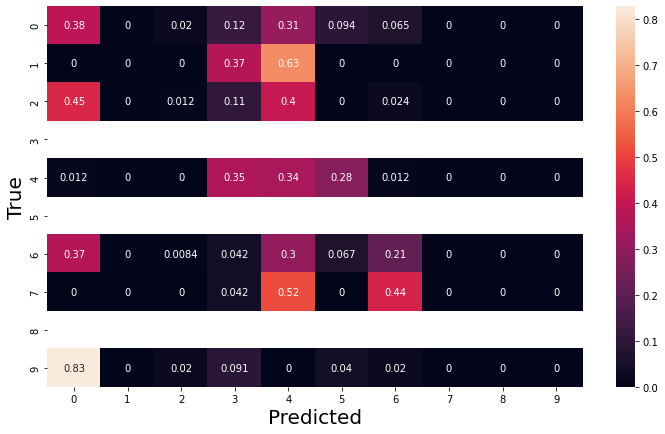

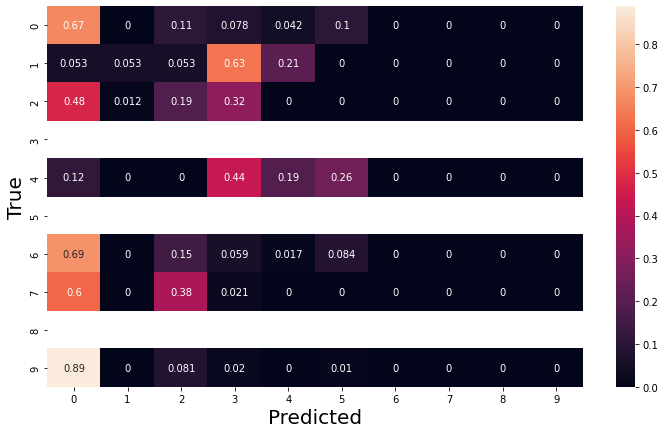

In [19]:
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(epoch, term, model, cfg, exp, sp, optimizer, sequence)

2022-04-07 05:59:47,702 - mmaction - INFO - load model from: torchvision://resnet50
2022-04-07 05:59:47,814 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.weight', 'fc.bias'}


load checkpoint from torchvision path: torchvision://resnet50


2022-04-07 05:59:52,129 - mmaction - INFO - Start running, host: root@b25b68309168, work_dir: /content/mmaction2/tutorial_exps
2022-04-07 05:59:52,130 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook   

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 25.9 task/s, elapsed: 5s, ETA:     0s

2022-04-07 06:01:55,117 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:01:55,120 - mmaction - INFO - 
top1_acc	0.5462
top2_acc	0.8067
2022-04-07 06:01:55,121 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:01:55,123 - mmaction - INFO - 
mean_acc	0.3410
2022-04-07 06:01:58,225 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-07 06:01:58,226 - mmaction - INFO - Best top1_acc is 0.5462 at 5 epoch.
2022-04-07 06:01:58,228 - mmaction - INFO - Epoch(val) [5][8]	top1_acc: 0.5462, top2_acc: 0.8067, mean_class_accuracy: 0.3410
2022-04-07 06:02:06,489 - mmaction - INFO - Epoch [6][5/24]	lr: 1.000e-02, eta: 0:32:16, time: 1.651, data_time: 0.860, memory: 12012, loss_aux: 0.7300, top1_acc: 0.4125, top5_acc: 0.9500, loss_cls: 1.4298, loss: 2.1598, grad_norm: 7.6425
2022-04-07 06:02:10,442 - mmaction - INFO - Epoch [6][10/24]	lr: 1.000e-02, eta: 0:32:06, time: 0.790, data_time: 0.004, memory: 12012, loss_aux: 0.6670, top1_ac

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.2 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:04:01,319 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:04:01,321 - mmaction - INFO - 
top1_acc	0.6218
top2_acc	0.8824
2022-04-07 06:04:01,322 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:04:01,325 - mmaction - INFO - 
mean_acc	0.4068
2022-04-07 06:04:01,406 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-07 06:04:04,457 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-07 06:04:04,459 - mmaction - INFO - Best top1_acc is 0.6218 at 10 epoch.
2022-04-07 06:04:04,460 - mmaction - INFO - Epoch(val) [10][8]	top1_acc: 0.6218, top2_acc: 0.8824, mean_class_accuracy: 0.4068
2022-04-07 06:04:12,632 - mmaction - INFO - Epoch [11][5/24]	lr: 1.000e-02, eta: 0:30:04, time: 1.632, data_time: 0.842, memory: 12012, loss_aux: 0.4871, top1_acc: 0.6125, top5_acc: 0.9875, loss_cls: 0.9426, loss: 1.4297, grad_norm: 5.6217
2022-04-07 06

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.7 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:06:07,205 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:06:07,208 - mmaction - INFO - 
top1_acc	0.5882
top2_acc	0.8992
2022-04-07 06:06:07,208 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:06:07,211 - mmaction - INFO - 
mean_acc	0.2798
2022-04-07 06:06:07,212 - mmaction - INFO - Epoch(val) [15][8]	top1_acc: 0.5882, top2_acc: 0.8992, mean_class_accuracy: 0.2798
2022-04-07 06:06:14,967 - mmaction - INFO - Epoch [16][5/24]	lr: 1.000e-02, eta: 0:28:11, time: 1.549, data_time: 0.755, memory: 12012, loss_aux: 0.5585, top1_acc: 0.5500, top5_acc: 1.0000, loss_cls: 1.1300, loss: 1.6885, grad_norm: 7.2700
2022-04-07 06:06:18,938 - mmaction - INFO - Epoch [16][10/24]	lr: 1.000e-02, eta: 0:28:05, time: 0.794, data_time: 0.002, memory: 12012, loss_aux: 0.5837, top1_acc: 0.5375, top5_acc: 0.9750, loss_cls: 1.1281, loss: 1.7118, grad_norm: 7.6769
2022-04-07 06:06:22,901 - mmaction - INFO - Epoch [16][15/24]	lr: 1.000e-02, eta: 0:28:00, time: 0.79

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.0 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:08:09,669 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:08:09,672 - mmaction - INFO - 
top1_acc	0.7059
top2_acc	0.9244
2022-04-07 06:08:09,673 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:08:09,677 - mmaction - INFO - 
mean_acc	0.5653
2022-04-07 06:08:09,765 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-07 06:08:12,853 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2022-04-07 06:08:12,854 - mmaction - INFO - Best top1_acc is 0.7059 at 20 epoch.
2022-04-07 06:08:12,856 - mmaction - INFO - Epoch(val) [20][8]	top1_acc: 0.7059, top2_acc: 0.9244, mean_class_accuracy: 0.5653
2022-04-07 06:08:21,402 - mmaction - INFO - Epoch [21][5/24]	lr: 1.000e-02, eta: 0:26:27, time: 1.707, data_time: 0.919, memory: 12012, loss_aux: 0.4306, top1_acc: 0.7125, top5_acc: 0.9875, loss_cls: 0.8341, loss: 1.2646, grad_norm: 5.2372
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.9 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:10:16,152 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:10:16,155 - mmaction - INFO - 
top1_acc	0.7479
top2_acc	0.9328
2022-04-07 06:10:16,156 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:10:16,159 - mmaction - INFO - 
mean_acc	0.5565
2022-04-07 06:10:16,237 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_20.pth was removed
2022-04-07 06:10:19,276 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2022-04-07 06:10:19,278 - mmaction - INFO - Best top1_acc is 0.7479 at 25 epoch.
2022-04-07 06:10:19,279 - mmaction - INFO - Epoch(val) [25][8]	top1_acc: 0.7479, top2_acc: 0.9328, mean_class_accuracy: 0.5565
2022-04-07 06:10:27,208 - mmaction - INFO - Epoch [26][5/24]	lr: 1.000e-02, eta: 0:24:45, time: 1.584, data_time: 0.791, memory: 12012, loss_aux: 0.5050, top1_acc: 0.6875, top5_acc: 1.0000, loss_cls: 0.9791, loss: 1.4840, grad_norm: 6.9753
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 25.4 task/s, elapsed: 5s, ETA:     0s

2022-04-07 06:12:22,137 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:12:22,139 - mmaction - INFO - 
top1_acc	0.7227
top2_acc	0.9076
2022-04-07 06:12:22,140 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:12:22,143 - mmaction - INFO - 
mean_acc	0.5597
2022-04-07 06:12:22,144 - mmaction - INFO - Epoch(val) [30][8]	top1_acc: 0.7227, top2_acc: 0.9076, mean_class_accuracy: 0.5597
2022-04-07 06:12:29,883 - mmaction - INFO - Epoch [31][5/24]	lr: 1.000e-02, eta: 0:23:03, time: 1.546, data_time: 0.757, memory: 12012, loss_aux: 0.5734, top1_acc: 0.5375, top5_acc: 0.9875, loss_cls: 1.0277, loss: 1.6011, grad_norm: 6.5603
2022-04-07 06:12:33,825 - mmaction - INFO - Epoch [31][10/24]	lr: 1.000e-02, eta: 0:22:58, time: 0.789, data_time: 0.002, memory: 12012, loss_aux: 0.4745, top1_acc: 0.7375, top5_acc: 1.0000, loss_cls: 0.9226, loss: 1.3971, grad_norm: 6.0915
2022-04-07 06:12:37,775 - mmaction - INFO - Epoch [31][15/24]	lr: 1.000e-02, eta: 0:22:54, time: 0.79

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.6 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:14:24,118 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:14:24,120 - mmaction - INFO - 
top1_acc	0.6723
top2_acc	0.8824
2022-04-07 06:14:24,121 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:14:24,124 - mmaction - INFO - 
mean_acc	0.7519
2022-04-07 06:14:24,125 - mmaction - INFO - Epoch(val) [35][8]	top1_acc: 0.6723, top2_acc: 0.8824, mean_class_accuracy: 0.7519
2022-04-07 06:14:31,917 - mmaction - INFO - Epoch [36][5/24]	lr: 1.000e-02, eta: 0:21:22, time: 1.557, data_time: 0.768, memory: 12012, loss_aux: 0.3571, top1_acc: 0.7750, top5_acc: 0.9750, loss_cls: 0.6622, loss: 1.0193, grad_norm: 4.7561
2022-04-07 06:14:35,883 - mmaction - INFO - Epoch [36][10/24]	lr: 1.000e-02, eta: 0:21:17, time: 0.793, data_time: 0.002, memory: 12012, loss_aux: 0.3948, top1_acc: 0.7000, top5_acc: 0.9875, loss_cls: 0.7321, loss: 1.1269, grad_norm: 5.2417
2022-04-07 06:14:39,810 - mmaction - INFO - Epoch [36][15/24]	lr: 1.000e-02, eta: 0:21:13, time: 0.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.6 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:16:26,053 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:16:26,056 - mmaction - INFO - 
top1_acc	0.7815
top2_acc	0.9496
2022-04-07 06:16:26,057 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:16:26,060 - mmaction - INFO - 
mean_acc	0.5906
2022-04-07 06:16:26,146 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_25.pth was removed
2022-04-07 06:16:29,137 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2022-04-07 06:16:29,138 - mmaction - INFO - Best top1_acc is 0.7815 at 40 epoch.
2022-04-07 06:16:29,139 - mmaction - INFO - Epoch(val) [40][8]	top1_acc: 0.7815, top2_acc: 0.9496, mean_class_accuracy: 0.5906
2022-04-07 06:16:36,852 - mmaction - INFO - Epoch [41][5/24]	lr: 1.000e-02, eta: 0:19:41, time: 1.541, data_time: 0.751, memory: 12012, loss_aux: 0.3926, top1_acc: 0.7250, top5_acc: 1.0000, loss_cls: 0.7158, loss: 1.1084, grad_norm: 4.5976
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 25.9 task/s, elapsed: 5s, ETA:     0s

2022-04-07 06:18:31,444 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:18:31,447 - mmaction - INFO - 
top1_acc	0.7395
top2_acc	0.9328
2022-04-07 06:18:31,447 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:18:31,450 - mmaction - INFO - 
mean_acc	0.6218
2022-04-07 06:18:31,451 - mmaction - INFO - Epoch(val) [45][8]	top1_acc: 0.7395, top2_acc: 0.9328, mean_class_accuracy: 0.6218
2022-04-07 06:18:39,210 - mmaction - INFO - Epoch [46][5/24]	lr: 1.000e-02, eta: 0:18:01, time: 1.550, data_time: 0.762, memory: 12012, loss_aux: 0.4904, top1_acc: 0.6375, top5_acc: 0.9750, loss_cls: 0.9218, loss: 1.4122, grad_norm: 5.9098
2022-04-07 06:18:43,153 - mmaction - INFO - Epoch [46][10/24]	lr: 1.000e-02, eta: 0:17:56, time: 0.789, data_time: 0.002, memory: 12012, loss_aux: 0.4482, top1_acc: 0.6750, top5_acc: 0.9875, loss_cls: 0.8081, loss: 1.2563, grad_norm: 4.5239
2022-04-07 06:18:47,102 - mmaction - INFO - Epoch [46][15/24]	lr: 1.000e-02, eta: 0:17:52, time: 0.79

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.7 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:20:33,357 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:20:33,359 - mmaction - INFO - 
top1_acc	0.6555
top2_acc	0.8403
2022-04-07 06:20:33,361 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:20:33,363 - mmaction - INFO - 
mean_acc	0.6122
2022-04-07 06:20:33,364 - mmaction - INFO - Epoch(val) [50][8]	top1_acc: 0.6555, top2_acc: 0.8403, mean_class_accuracy: 0.6122
2022-04-07 06:20:41,089 - mmaction - INFO - Epoch [51][5/24]	lr: 1.000e-02, eta: 0:16:21, time: 1.543, data_time: 0.752, memory: 12012, loss_aux: 0.4194, top1_acc: 0.7375, top5_acc: 0.9875, loss_cls: 0.7664, loss: 1.1858, grad_norm: 4.6871
2022-04-07 06:20:45,045 - mmaction - INFO - Epoch [51][10/24]	lr: 1.000e-02, eta: 0:16:17, time: 0.791, data_time: 0.005, memory: 12012, loss_aux: 0.4911, top1_acc: 0.6875, top5_acc: 1.0000, loss_cls: 0.8280, loss: 1.3191, grad_norm: 6.2252
2022-04-07 06:20:48,979 - mmaction - INFO - Epoch [51][15/24]	lr: 1.000e-02, eta: 0:16:13, time: 0.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.4 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:22:35,160 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:22:35,163 - mmaction - INFO - 
top1_acc	0.7899
top2_acc	0.9496
2022-04-07 06:22:35,164 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:22:35,167 - mmaction - INFO - 
mean_acc	0.7919
2022-04-07 06:22:35,258 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_40.pth was removed
2022-04-07 06:22:38,237 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_55.pth.
2022-04-07 06:22:38,239 - mmaction - INFO - Best top1_acc is 0.7899 at 55 epoch.
2022-04-07 06:22:38,240 - mmaction - INFO - Epoch(val) [55][8]	top1_acc: 0.7899, top2_acc: 0.9496, mean_class_accuracy: 0.7919
2022-04-07 06:22:45,997 - mmaction - INFO - Epoch [56][5/24]	lr: 1.000e-02, eta: 0:14:42, time: 1.550, data_time: 0.761, memory: 12012, loss_aux: 0.3030, top1_acc: 0.7750, top5_acc: 1.0000, loss_cls: 0.5957, loss: 0.8986, grad_norm: 4.9526
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.5 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:24:39,960 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:24:39,963 - mmaction - INFO - 
top1_acc	0.7227
top2_acc	0.8908
2022-04-07 06:24:39,964 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:24:39,966 - mmaction - INFO - 
mean_acc	0.7578
2022-04-07 06:24:39,967 - mmaction - INFO - Epoch(val) [60][8]	top1_acc: 0.7227, top2_acc: 0.8908, mean_class_accuracy: 0.7578
2022-04-07 06:24:47,576 - mmaction - INFO - Epoch [61][5/24]	lr: 1.000e-02, eta: 0:13:03, time: 1.520, data_time: 0.729, memory: 12012, loss_aux: 0.3689, top1_acc: 0.7250, top5_acc: 1.0000, loss_cls: 0.5381, loss: 0.9070, grad_norm: 3.8647
2022-04-07 06:24:51,525 - mmaction - INFO - Epoch [61][10/24]	lr: 1.000e-02, eta: 0:12:59, time: 0.790, data_time: 0.004, memory: 12012, loss_aux: 0.3357, top1_acc: 0.7625, top5_acc: 0.9875, loss_cls: 0.6371, loss: 0.9729, grad_norm: 4.4387
2022-04-07 06:24:55,470 - mmaction - INFO - Epoch [61][15/24]	lr: 1.000e-02, eta: 0:12:55, time: 0.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 26.8 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:26:41,699 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:26:41,701 - mmaction - INFO - 
top1_acc	0.7899
top2_acc	0.9244
2022-04-07 06:26:41,702 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:26:41,704 - mmaction - INFO - 
mean_acc	0.7902
2022-04-07 06:26:41,706 - mmaction - INFO - Epoch(val) [65][8]	top1_acc: 0.7899, top2_acc: 0.9244, mean_class_accuracy: 0.7902
2022-04-07 06:26:49,574 - mmaction - INFO - Epoch [66][5/24]	lr: 1.000e-02, eta: 0:11:24, time: 1.572, data_time: 0.781, memory: 12012, loss_aux: 0.3649, top1_acc: 0.7750, top5_acc: 0.9875, loss_cls: 0.6622, loss: 1.0270, grad_norm: 6.0664
2022-04-07 06:26:53,521 - mmaction - INFO - Epoch [66][10/24]	lr: 1.000e-02, eta: 0:11:20, time: 0.789, data_time: 0.002, memory: 12012, loss_aux: 0.3752, top1_acc: 0.7000, top5_acc: 0.9875, loss_cls: 0.7226, loss: 1.0978, grad_norm: 7.7062
2022-04-07 06:26:57,465 - mmaction - INFO - Epoch [66][15/24]	lr: 1.000e-02, eta: 0:11:16, time: 0.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.3 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:28:43,462 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:28:43,465 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9496
2022-04-07 06:28:43,466 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:28:43,468 - mmaction - INFO - 
mean_acc	0.7749
2022-04-07 06:28:43,570 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_55.pth was removed
2022-04-07 06:28:46,622 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_70.pth.
2022-04-07 06:28:46,623 - mmaction - INFO - Best top1_acc is 0.8403 at 70 epoch.
2022-04-07 06:28:46,624 - mmaction - INFO - Epoch(val) [70][8]	top1_acc: 0.8403, top2_acc: 0.9496, mean_class_accuracy: 0.7749
2022-04-07 06:28:54,516 - mmaction - INFO - Epoch [71][5/24]	lr: 1.000e-02, eta: 0:09:46, time: 1.577, data_time: 0.787, memory: 12012, loss_aux: 0.3344, top1_acc: 0.7625, top5_acc: 1.0000, loss_cls: 0.6092, loss: 0.9436, grad_norm: 4.4695
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.1 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:30:48,827 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:30:48,830 - mmaction - INFO - 
top1_acc	0.7395
top2_acc	0.8992
2022-04-07 06:30:48,832 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:30:48,834 - mmaction - INFO - 
mean_acc	0.7160
2022-04-07 06:30:48,836 - mmaction - INFO - Epoch(val) [75][8]	top1_acc: 0.7395, top2_acc: 0.8992, mean_class_accuracy: 0.7160
2022-04-07 06:30:56,551 - mmaction - INFO - Epoch [76][5/24]	lr: 1.000e-03, eta: 0:08:07, time: 1.541, data_time: 0.749, memory: 12012, loss_aux: 0.3602, top1_acc: 0.7375, top5_acc: 1.0000, loss_cls: 0.7447, loss: 1.1050, grad_norm: 5.1759
2022-04-07 06:31:00,502 - mmaction - INFO - Epoch [76][10/24]	lr: 1.000e-03, eta: 0:08:03, time: 0.790, data_time: 0.002, memory: 12012, loss_aux: 0.2959, top1_acc: 0.8250, top5_acc: 0.9875, loss_cls: 0.5187, loss: 0.8146, grad_norm: 4.9953
2022-04-07 06:31:04,438 - mmaction - INFO - Epoch [76][15/24]	lr: 1.000e-03, eta: 0:07:59, time: 0.78

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 26.9 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:32:50,679 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:32:50,682 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9748
2022-04-07 06:32:50,683 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:32:50,685 - mmaction - INFO - 
mean_acc	0.8291
2022-04-07 06:32:50,778 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_70.pth was removed
2022-04-07 06:32:53,846 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_80.pth.
2022-04-07 06:32:53,847 - mmaction - INFO - Best top1_acc is 0.8655 at 80 epoch.
2022-04-07 06:32:53,849 - mmaction - INFO - Epoch(val) [80][8]	top1_acc: 0.8655, top2_acc: 0.9748, mean_class_accuracy: 0.8291
2022-04-07 06:33:01,715 - mmaction - INFO - Epoch [81][5/24]	lr: 1.000e-03, eta: 0:06:29, time: 1.572, data_time: 0.782, memory: 12012, loss_aux: 0.2771, top1_acc: 0.7875, top5_acc: 0.9750, loss_cls: 0.5487, loss: 0.8259, grad_norm: 3.2908
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.4 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:34:55,587 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:34:55,589 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9580
2022-04-07 06:34:55,590 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:34:55,593 - mmaction - INFO - 
mean_acc	0.8112
2022-04-07 06:34:55,594 - mmaction - INFO - Epoch(val) [85][8]	top1_acc: 0.8403, top2_acc: 0.9580, mean_class_accuracy: 0.8112
2022-04-07 06:35:03,372 - mmaction - INFO - Epoch [86][5/24]	lr: 1.000e-03, eta: 0:04:50, time: 1.554, data_time: 0.764, memory: 12012, loss_aux: 0.2423, top1_acc: 0.8500, top5_acc: 0.9875, loss_cls: 0.4229, loss: 0.6652, grad_norm: 3.5302
2022-04-07 06:35:07,318 - mmaction - INFO - Epoch [86][10/24]	lr: 1.000e-03, eta: 0:04:46, time: 0.790, data_time: 0.002, memory: 12012, loss_aux: 0.2608, top1_acc: 0.7750, top5_acc: 1.0000, loss_cls: 0.5388, loss: 0.7997, grad_norm: 3.2000
2022-04-07 06:35:11,273 - mmaction - INFO - Epoch [86][15/24]	lr: 1.000e-03, eta: 0:04:42, time: 0.79

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:36:57,326 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:36:57,329 - mmaction - INFO - 
top1_acc	0.8824
top2_acc	0.9664
2022-04-07 06:36:57,330 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:36:57,333 - mmaction - INFO - 
mean_acc	0.8352
2022-04-07 06:36:57,430 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_80.pth was removed
2022-04-07 06:37:00,513 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-07 06:37:00,515 - mmaction - INFO - Best top1_acc is 0.8824 at 90 epoch.
2022-04-07 06:37:00,516 - mmaction - INFO - Epoch(val) [90][8]	top1_acc: 0.8824, top2_acc: 0.9664, mean_class_accuracy: 0.8352
2022-04-07 06:37:08,267 - mmaction - INFO - Epoch [91][5/24]	lr: 1.000e-03, eta: 0:03:12, time: 1.548, data_time: 0.758, memory: 12012, loss_aux: 0.2781, top1_acc: 0.7875, top5_acc: 1.0000, loss_cls: 0.5263, loss: 0.8044, grad_norm: 4.2833
2022-04-07 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 26.7 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:39:02,210 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:39:02,213 - mmaction - INFO - 
top1_acc	0.8739
top2_acc	0.9580
2022-04-07 06:39:02,214 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:39:02,218 - mmaction - INFO - 
mean_acc	0.8243
2022-04-07 06:39:02,219 - mmaction - INFO - Epoch(val) [95][8]	top1_acc: 0.8739, top2_acc: 0.9580, mean_class_accuracy: 0.8243
2022-04-07 06:39:10,038 - mmaction - INFO - Epoch [96][5/24]	lr: 1.000e-03, eta: 0:01:34, time: 1.562, data_time: 0.771, memory: 12012, loss_aux: 0.2602, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4690, loss: 0.7292, grad_norm: 3.5620
2022-04-07 06:39:13,983 - mmaction - INFO - Epoch [96][10/24]	lr: 1.000e-03, eta: 0:01:30, time: 0.789, data_time: 0.002, memory: 12012, loss_aux: 0.2046, top1_acc: 0.8500, top5_acc: 0.9875, loss_cls: 0.3755, loss: 0.5801, grad_norm: 3.6459
2022-04-07 06:39:17,932 - mmaction - INFO - Epoch [96][15/24]	lr: 1.000e-03, eta: 0:01:25, time: 0.79

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.5 task/s, elapsed: 4s, ETA:     0s

2022-04-07 06:41:03,813 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 06:41:03,815 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9580
2022-04-07 06:41:03,817 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 06:41:03,819 - mmaction - INFO - 
mean_acc	0.8282
2022-04-07 06:41:03,820 - mmaction - INFO - Epoch(val) [100][8]	top1_acc: 0.8655, top2_acc: 0.9580, mean_class_accuracy: 0.8282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 197s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5101
top2_acc	0.6812

Evaluating mean_class_accuracy ...

mean_acc	0.3115
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4058
top2_acc	0.6290

Evaluating mean_class_accuracy ...

mean_acc	0.3411
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5565
top2_acc	0.7246

Evaluating mean_class_accuracy ...

mean_acc	0.4173
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.6029
top2_acc	0.7623

Evaluating mean_class_accuracy ...

mean_acc	0.5469
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

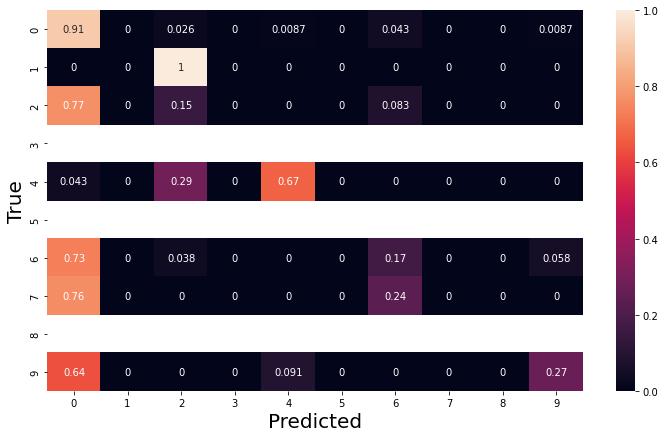

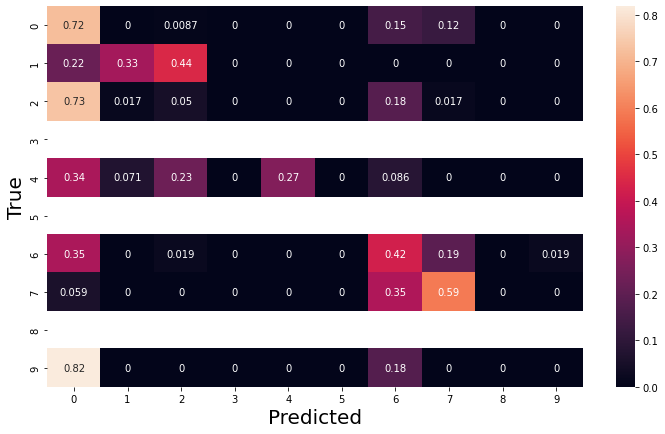

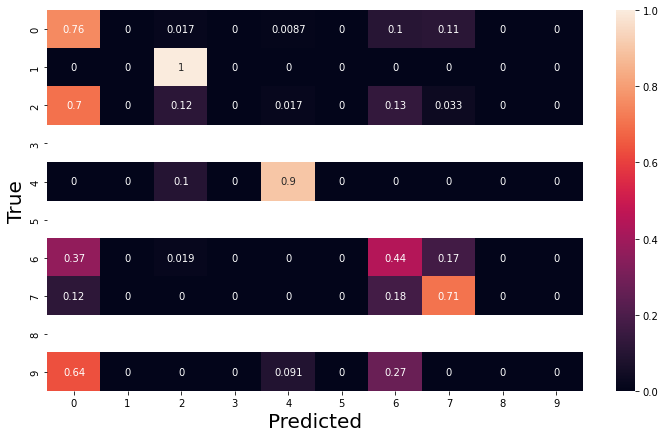

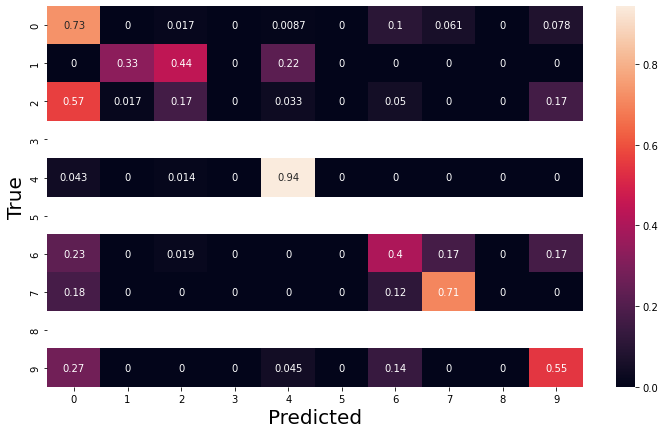

In [14]:
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(epoch, term, model, cfg, exp, sp, optimizer, sequence)

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowOnly',
        depth=50,
        pretrained='torchvision://resnet50',
        lateral=False,
        out_indices=(2, 3),
        conv1_kernel=(1, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(0, 0, 1, 1),
        norm_eval=False),
    neck=dict(
        type='TPN',
        in_channels=(1024, 2048),
        out_channels=1024,
        spatial_modulation_cfg=dict(
            in_channels=(1024, 2048), out_channels=2048),
        temporal_modulation_cfg=dict(downsample_scales=(8, 8)),
        upsample_cfg=dict(scale_factor=(1, 1, 1)),
        downsample_cfg=dict(downsample_scale=(1, 1, 1)),
        level_fusion_cfg=dict(
            in_channels=(1024, 1024),
            mid_channels=(1024, 1024),
            out_channels=2048,
            downsample_scales=((1, 1, 1), (1, 1, 1))),
        aux_head_cfg=dict(out_channels=400, loss_weight=0.5)),
    cls_head=dict(
        

2022-04-07 04:26:58,294 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-07 04:26:58,853 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-07 04:26:59,869 - mmaction - INFO - Start running, host: root@b25b68309168, work_dir: /content/mmaction2/tutorial_exps
2022-04-07 04:26:59,870 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 37.1 task/s, elapsed: 12s, ETA:     0s

2022-04-07 04:34:40,369 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 04:34:40,372 - mmaction - INFO - 
top1_acc	0.6737
top2_acc	0.8788
2022-04-07 04:34:40,373 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 04:34:40,377 - mmaction - INFO - 
mean_acc	0.5542
2022-04-07 04:34:43,466 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-07 04:34:43,467 - mmaction - INFO - Best top1_acc is 0.6737 at 5 epoch.
2022-04-07 04:34:43,469 - mmaction - INFO - Epoch(val) [5][27]	top1_acc: 0.6737, top2_acc: 0.8788, mean_class_accuracy: 0.5542
2022-04-07 04:34:51,153 - mmaction - INFO - Epoch [6][5/108]	lr: 1.000e-03, eta: 0:29:08, time: 1.535, data_time: 0.744, memory: 13067, loss_aux: 0.9978, top1_acc: 0.5750, top5_acc: 0.9250, loss_cls: 1.1527, loss: 2.1505, grad_norm: 13.1659
2022-04-07 04:34:55,098 - mmaction - INFO - Epoch [6][10/108]	lr: 1.000e-03, eta: 0:29:04, time: 0.789, data_time: 0.002, memory: 13067, loss_aux: 1.0120, top

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.7 task/s, elapsed: 12s, ETA:     0s

2022-04-07 04:42:24,231 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 04:42:24,234 - mmaction - INFO - 
top1_acc	0.8415
top2_acc	0.9371
2022-04-07 04:42:24,235 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 04:42:24,239 - mmaction - INFO - 
mean_acc	0.7138
2022-04-07 04:42:24,319 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-07 04:42:27,465 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-07 04:42:27,467 - mmaction - INFO - Best top1_acc is 0.8415 at 10 epoch.
2022-04-07 04:42:27,469 - mmaction - INFO - Epoch(val) [10][27]	top1_acc: 0.8415, top2_acc: 0.9371, mean_class_accuracy: 0.7138
2022-04-07 04:42:35,247 - mmaction - INFO - Epoch [11][5/108]	lr: 1.000e-03, eta: 0:21:45, time: 1.554, data_time: 0.765, memory: 13067, loss_aux: 0.6617, top1_acc: 0.8000, top5_acc: 0.9750, loss_cls: 0.6247, loss: 1.2864, grad_norm: 10.1719
2022-04-07

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.4 task/s, elapsed: 12s, ETA:     0s

2022-04-07 04:50:09,143 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 04:50:09,146 - mmaction - INFO - 
top1_acc	0.8998
top2_acc	0.9674
2022-04-07 04:50:09,147 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 04:50:09,150 - mmaction - INFO - 
mean_acc	0.7936
2022-04-07 04:50:09,236 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-07 04:50:12,767 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-07 04:50:12,768 - mmaction - INFO - Best top1_acc is 0.8998 at 15 epoch.
2022-04-07 04:50:12,770 - mmaction - INFO - Epoch(val) [15][27]	top1_acc: 0.8998, top2_acc: 0.9674, mean_class_accuracy: 0.7936
2022-04-07 04:50:20,443 - mmaction - INFO - Epoch [16][5/108]	lr: 1.000e-03, eta: 0:14:27, time: 1.533, data_time: 0.745, memory: 13067, loss_aux: 0.5058, top1_acc: 0.8375, top5_acc: 0.9375, loss_cls: 0.4780, loss: 0.9837, grad_norm: 7.8936
2022-04-07

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.6 task/s, elapsed: 12s, ETA:     0s

2022-04-07 04:57:54,056 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 04:57:54,059 - mmaction - INFO - 
top1_acc	0.8951
top2_acc	0.9650
2022-04-07 04:57:54,060 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 04:57:54,063 - mmaction - INFO - 
mean_acc	0.7946
2022-04-07 04:57:54,064 - mmaction - INFO - Epoch(val) [20][27]	top1_acc: 0.8951, top2_acc: 0.9650, mean_class_accuracy: 0.7946
2022-04-07 04:58:01,826 - mmaction - INFO - Epoch [21][5/108]	lr: 1.000e-03, eta: 0:07:11, time: 1.551, data_time: 0.754, memory: 13067, loss_aux: 0.3519, top1_acc: 0.8125, top5_acc: 1.0000, loss_cls: 0.4530, loss: 0.8049, grad_norm: 9.3642
2022-04-07 04:58:05,765 - mmaction - INFO - Epoch [21][10/108]	lr: 1.000e-03, eta: 0:07:07, time: 0.788, data_time: 0.002, memory: 13067, loss_aux: 0.4268, top1_acc: 0.7375, top5_acc: 0.9875, loss_cls: 0.6071, loss: 1.0340, grad_norm: 12.9086
2022-04-07 04:58:09,712 - mmaction - INFO - Epoch [21][15/108]	lr: 1.000e-03, eta: 0:07:03, time:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 37.1 task/s, elapsed: 12s, ETA:     0s

2022-04-07 05:05:33,183 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-07 05:05:33,187 - mmaction - INFO - 
top1_acc	0.8765
top2_acc	0.9674
2022-04-07 05:05:33,188 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-07 05:05:33,191 - mmaction - INFO - 
mean_acc	0.7685
2022-04-07 05:05:33,192 - mmaction - INFO - Epoch(val) [25][27]	top1_acc: 0.8765, top2_acc: 0.9674, mean_class_accuracy: 0.7685


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 480s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2087
top2_acc	0.2406

Evaluating mean_class_accuracy ...

mean_acc	0.0734
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 480s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2571
top2_acc	0.3632

Evaluating mean_class_accuracy ...

mean_acc	0.0958
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 479s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.3113
top2_acc	0.4410

Evaluating mean_class_accuracy ...

mean_acc	0.1129
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 480s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2889
top2_acc	0.4493

Evaluating mean_class_accuracy ...

mean_acc	0.1115
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 479s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.3455
top2_acc	0.5083

Evaluating mean_class_accuracy ...

mean_acc	0.1299
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

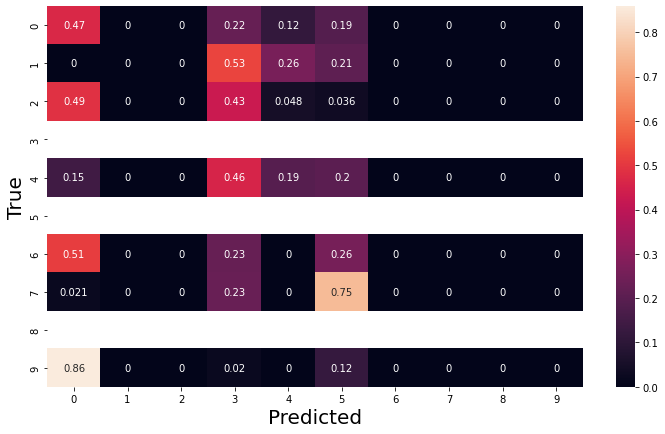

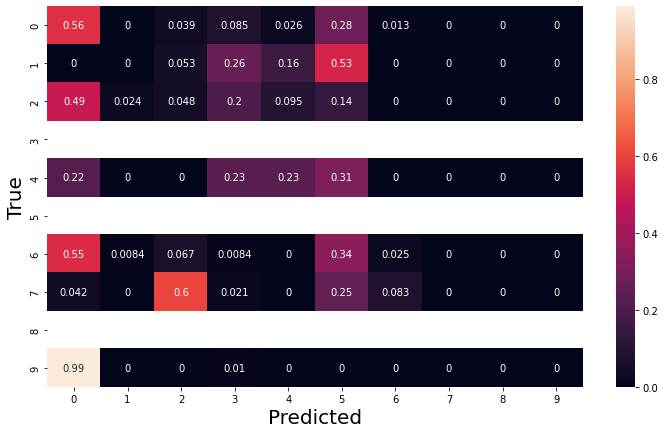

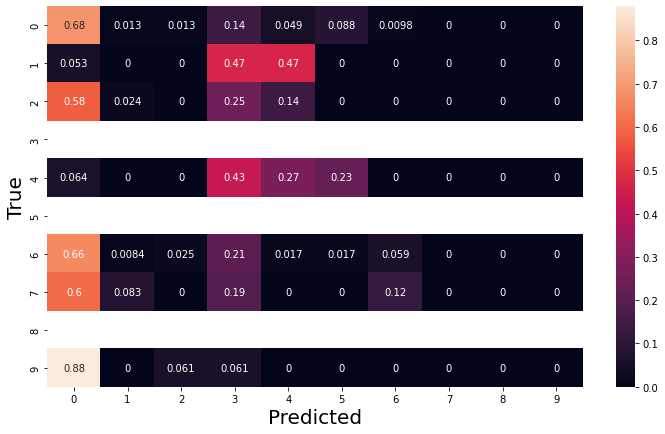

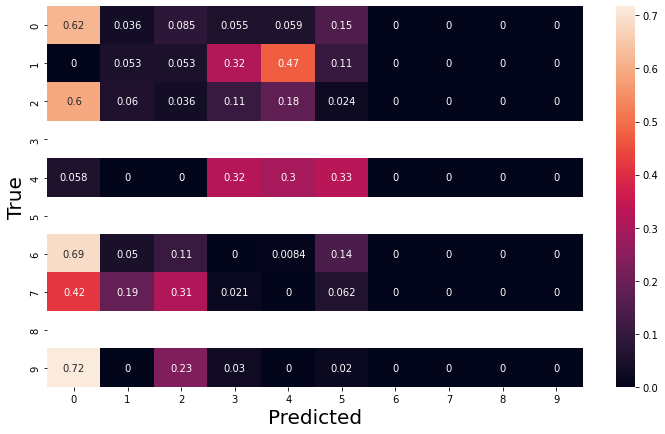

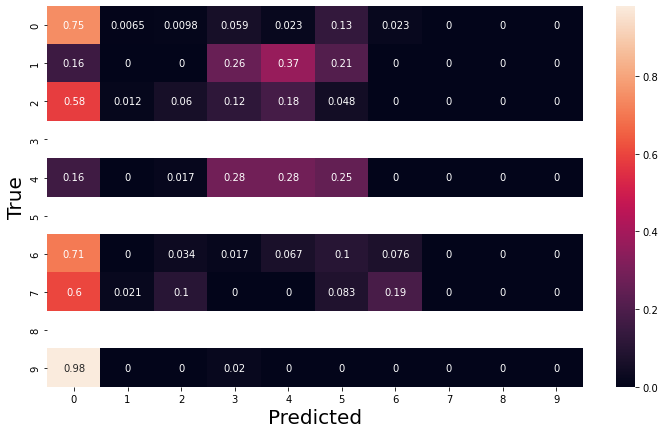

In [21]:
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(epoch, term, model, cfg, exp, sp, optimizer, sequence)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 482s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2134
top2_acc	0.2842

Evaluating mean_class_accuracy ...

mean_acc	0.0848
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 481s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2653
top2_acc	0.4104

Evaluating mean_class_accuracy ...

mean_acc	0.0996
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 848/848, 1.8 task/s, elapsed: 481s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.2759
top2_acc	0.3915

Evaluating mean_class_accuracy ...

mean_acc	0.1127
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

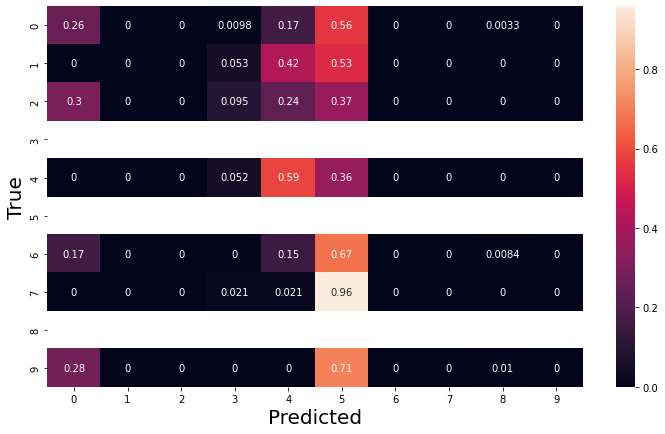

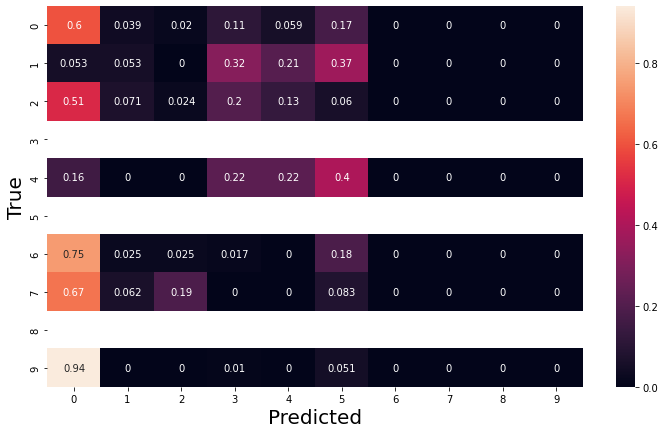

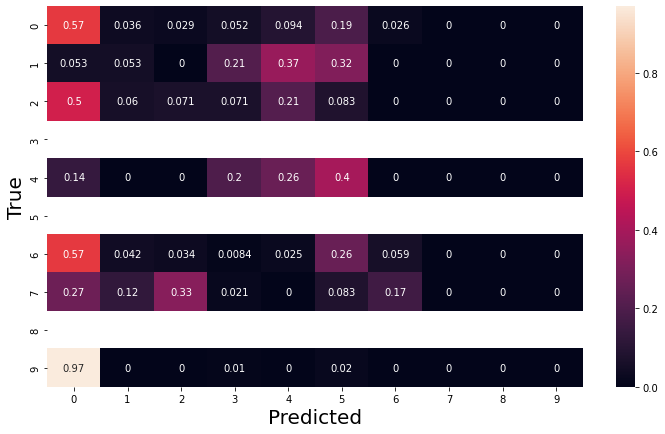

In [18]:
tests_by_epochs(epoch, term, model, cfg, exp, sp, optimizer, sequence)

5
5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

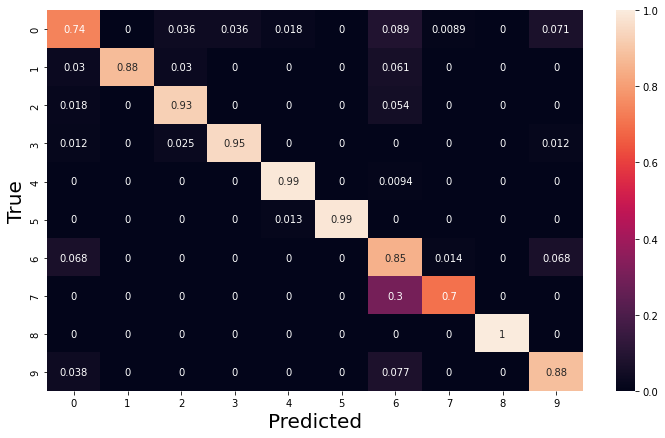

In [32]:
from google.colab import files
cm(exp, outputs, sp, optimizer, epoch, seq=1)

Test stored other weights model

2022-04-06 20:02:06,984 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-04-06 20:02:09,247 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.weight', 'fc.bias'}
2022-04-06 20:02:12,934 - mmaction - INFO - Start running, host: root@0f0a1fcc0858, work_dir: /content/mmaction2/tutorial_exps
2022-04-06 20:02:12,936 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.6 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:04:28,950 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:04:28,952 - mmaction - INFO - 
top1_acc	0.3478
top2_acc	0.5652
2022-04-06 20:04:28,953 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:04:28,957 - mmaction - INFO - 
mean_acc	0.1972
2022-04-06 20:04:32,515 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-06 20:04:32,516 - mmaction - INFO - Best top1_acc is 0.3478 at 5 epoch.
2022-04-06 20:04:32,517 - mmaction - INFO - Epoch(val) [5][6]	top1_acc: 0.3478, top2_acc: 0.5652, mean_class_accuracy: 0.1972


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:06:48,598 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:06:48,600 - mmaction - INFO - 
top1_acc	0.5326
top2_acc	0.6848
2022-04-06 20:06:48,601 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:06:48,604 - mmaction - INFO - 
mean_acc	0.3040
2022-04-06 20:06:48,675 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-06 20:06:51,652 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-06 20:06:51,653 - mmaction - INFO - Best top1_acc is 0.5326 at 10 epoch.
2022-04-06 20:06:51,654 - mmaction - INFO - Epoch(val) [10][6]	top1_acc: 0.5326, top2_acc: 0.6848, mean_class_accuracy: 0.3040


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.7 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:09:07,740 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:09:07,742 - mmaction - INFO - 
top1_acc	0.3913
top2_acc	0.6630
2022-04-06 20:09:07,743 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:09:07,745 - mmaction - INFO - 
mean_acc	0.2155
2022-04-06 20:09:07,746 - mmaction - INFO - Epoch(val) [15][6]	top1_acc: 0.3913, top2_acc: 0.6630, mean_class_accuracy: 0.2155


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.1 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:11:23,437 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:11:23,440 - mmaction - INFO - 
top1_acc	0.5326
top2_acc	0.8261
2022-04-06 20:11:23,440 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:11:23,443 - mmaction - INFO - 
mean_acc	0.4010
2022-04-06 20:11:23,444 - mmaction - INFO - Epoch(val) [20][6]	top1_acc: 0.5326, top2_acc: 0.8261, mean_class_accuracy: 0.4010
2022-04-06 20:13:35,213 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.1 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:13:42,435 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:13:42,437 - mmaction - INFO - 
top1_acc	0.5000
top2_acc	0.7717
2022-04-06 20:13:42,437 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:13:42,439 - mmaction - INFO - 
mean_acc	0.3259
2022-04-06 20:13:42,441 - mmaction - INFO - Epoch(val) [25][6]	top1_acc: 0.5000, top2_acc: 0.7717, mean_class_accuracy: 0.3259


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:15:58,322 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:15:58,324 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.7500
2022-04-06 20:15:58,325 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:15:58,328 - mmaction - INFO - 
mean_acc	0.5014
2022-04-06 20:15:58,404 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-06 20:16:01,362 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-06 20:16:01,364 - mmaction - INFO - Best top1_acc is 0.5870 at 30 epoch.
2022-04-06 20:16:01,366 - mmaction - INFO - Epoch(val) [30][6]	top1_acc: 0.5870, top2_acc: 0.7500, mean_class_accuracy: 0.5014


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:18:17,358 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:18:17,360 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.8370
2022-04-06 20:18:17,360 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:18:17,363 - mmaction - INFO - 
mean_acc	0.4664
2022-04-06 20:18:17,364 - mmaction - INFO - Epoch(val) [35][6]	top1_acc: 0.5870, top2_acc: 0.8370, mean_class_accuracy: 0.4664


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:20:33,251 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:20:33,253 - mmaction - INFO - 
top1_acc	0.5978
top2_acc	0.7826
2022-04-06 20:20:33,255 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:20:33,256 - mmaction - INFO - 
mean_acc	0.4327
2022-04-06 20:20:33,332 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-06 20:20:36,301 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2022-04-06 20:20:36,302 - mmaction - INFO - Best top1_acc is 0.5978 at 40 epoch.
2022-04-06 20:20:36,303 - mmaction - INFO - Epoch(val) [40][6]	top1_acc: 0.5978, top2_acc: 0.7826, mean_class_accuracy: 0.4327


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.0 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:22:52,043 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:22:52,045 - mmaction - INFO - 
top1_acc	0.5326
top2_acc	0.7935
2022-04-06 20:22:52,046 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:22:52,049 - mmaction - INFO - 
mean_acc	0.3528
2022-04-06 20:22:52,050 - mmaction - INFO - Epoch(val) [45][6]	top1_acc: 0.5326, top2_acc: 0.7935, mean_class_accuracy: 0.3528
2022-04-06 20:25:03,821 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.0 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:25:11,033 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:25:11,035 - mmaction - INFO - 
top1_acc	0.5543
top2_acc	0.7717
2022-04-06 20:25:11,036 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:25:11,038 - mmaction - INFO - 
mean_acc	0.4731
2022-04-06 20:25:11,039 - mmaction - INFO - Epoch(val) [50][6]	top1_acc: 0.5543, top2_acc: 0.7717, mean_class_accuracy: 0.4731


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:27:26,866 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:27:26,868 - mmaction - INFO - 
top1_acc	0.5978
top2_acc	0.7609
2022-04-06 20:27:26,869 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:27:26,871 - mmaction - INFO - 
mean_acc	0.4220
2022-04-06 20:27:26,872 - mmaction - INFO - Epoch(val) [55][6]	top1_acc: 0.5978, top2_acc: 0.7609, mean_class_accuracy: 0.4220


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:29:42,613 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:29:42,616 - mmaction - INFO - 
top1_acc	0.6413
top2_acc	0.8043
2022-04-06 20:29:42,617 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:29:42,619 - mmaction - INFO - 
mean_acc	0.4680
2022-04-06 20:29:42,698 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_40.pth was removed
2022-04-06 20:29:45,663 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_60.pth.
2022-04-06 20:29:45,664 - mmaction - INFO - Best top1_acc is 0.6413 at 60 epoch.
2022-04-06 20:29:45,665 - mmaction - INFO - Epoch(val) [60][6]	top1_acc: 0.6413, top2_acc: 0.8043, mean_class_accuracy: 0.4680


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.7 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:32:01,162 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:32:01,164 - mmaction - INFO - 
top1_acc	0.5435
top2_acc	0.8043
2022-04-06 20:32:01,165 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:32:01,168 - mmaction - INFO - 
mean_acc	0.5389
2022-04-06 20:32:01,169 - mmaction - INFO - Epoch(val) [65][6]	top1_acc: 0.5435, top2_acc: 0.8043, mean_class_accuracy: 0.5389


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:34:17,028 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:34:17,030 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.7826
2022-04-06 20:34:17,031 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:34:17,034 - mmaction - INFO - 
mean_acc	0.4926
2022-04-06 20:34:17,035 - mmaction - INFO - Epoch(val) [70][6]	top1_acc: 0.5870, top2_acc: 0.7826, mean_class_accuracy: 0.4926
2022-04-06 20:36:28,400 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:36:35,577 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:36:35,579 - mmaction - INFO - 
top1_acc	0.5978
top2_acc	0.8043
2022-04-06 20:36:35,581 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:36:35,582 - mmaction - INFO - 
mean_acc	0.4255
2022-04-06 20:36:35,584 - mmaction - INFO - Epoch(val) [75][6]	top1_acc: 0.5978, top2_acc: 0.8043, mean_class_accuracy: 0.4255


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:38:51,463 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:38:51,466 - mmaction - INFO - 
top1_acc	0.6848
top2_acc	0.8804
2022-04-06 20:38:51,467 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:38:51,469 - mmaction - INFO - 
mean_acc	0.6942
2022-04-06 20:38:51,549 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_60.pth was removed
2022-04-06 20:38:54,498 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_80.pth.
2022-04-06 20:38:54,499 - mmaction - INFO - Best top1_acc is 0.6848 at 80 epoch.
2022-04-06 20:38:54,500 - mmaction - INFO - Epoch(val) [80][6]	top1_acc: 0.6848, top2_acc: 0.8804, mean_class_accuracy: 0.6942


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:41:10,062 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:41:10,064 - mmaction - INFO - 
top1_acc	0.6630
top2_acc	0.8696
2022-04-06 20:41:10,065 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:41:10,067 - mmaction - INFO - 
mean_acc	0.6443
2022-04-06 20:41:10,068 - mmaction - INFO - Epoch(val) [85][6]	top1_acc: 0.6630, top2_acc: 0.8696, mean_class_accuracy: 0.6443


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.4 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:43:25,812 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:43:25,814 - mmaction - INFO - 
top1_acc	0.6957
top2_acc	0.9130
2022-04-06 20:43:25,815 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:43:25,817 - mmaction - INFO - 
mean_acc	0.6174
2022-04-06 20:43:25,899 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_80.pth was removed
2022-04-06 20:43:28,851 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-06 20:43:28,852 - mmaction - INFO - Best top1_acc is 0.6957 at 90 epoch.
2022-04-06 20:43:28,854 - mmaction - INFO - Epoch(val) [90][6]	top1_acc: 0.6957, top2_acc: 0.9130, mean_class_accuracy: 0.6174


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:45:45,115 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:45:45,117 - mmaction - INFO - 
top1_acc	0.6739
top2_acc	0.8696
2022-04-06 20:45:45,118 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:45:45,121 - mmaction - INFO - 
mean_acc	0.6421
2022-04-06 20:45:45,122 - mmaction - INFO - Epoch(val) [95][6]	top1_acc: 0.6739, top2_acc: 0.8696, mean_class_accuracy: 0.6421
2022-04-06 20:47:56,533 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.0 task/s, elapsed: 4s, ETA:     0s

2022-04-06 20:48:03,734 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 20:48:03,737 - mmaction - INFO - 
top1_acc	0.6630
top2_acc	0.8587
2022-04-06 20:48:03,738 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 20:48:03,739 - mmaction - INFO - 
mean_acc	0.6041
2022-04-06 20:48:03,740 - mmaction - INFO - Epoch(val) [100][6]	top1_acc: 0.6630, top2_acc: 0.8587, mean_class_accuracy: 0.6041


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 528s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.3439
top2_acc	0.5527

Evaluating mean_class_accuracy ...

mean_acc	0.2294
0: 60
1: 0
2: 127
3: 0
4: 208
5: 0
6: 45
7: 0
8: 0
9: 63
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 527s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4990
top2_acc	0.6839

Evaluating mean_class_accuracy ...

mean_acc	0.2789
0: 254
1: 0
2: 41
3: 0
4: 86
5: 0
6: 113
7: 0
8: 0
9: 9
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5129
top2_acc	0.6521

Evaluating mean_class_accuracy ...

mean_acc	0.2421
0: 372
1: 0
2: 48
3: 0
4: 71
5: 0
6: 12
7: 0
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5686
top2_acc	0.6779

Evaluating mean_class_accuracy ...

mean_acc	0.3950
0: 275
1: 9
2: 80
3: 0
4: 82
5: 0
6: 53
7: 0
8: 

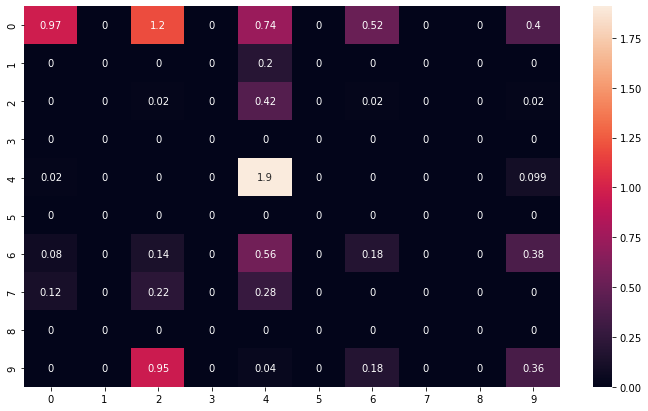

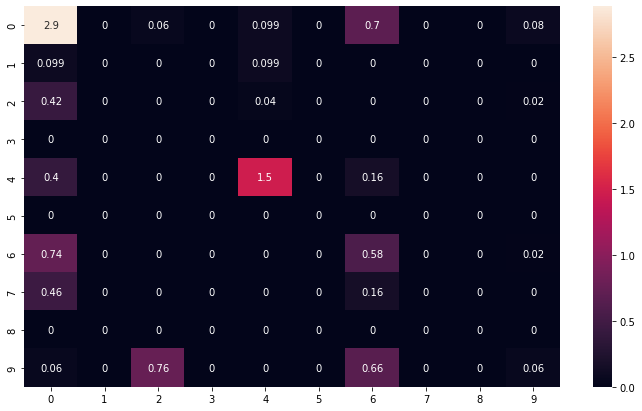

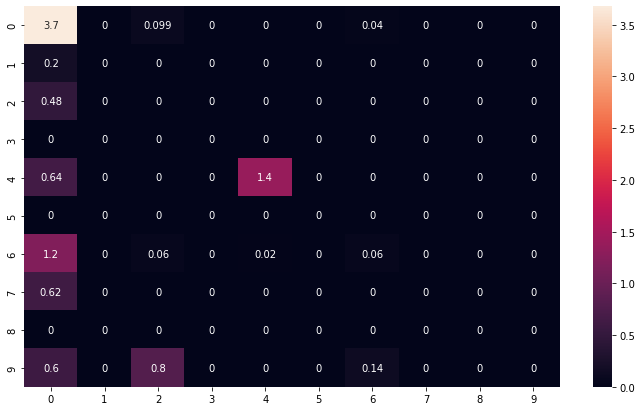

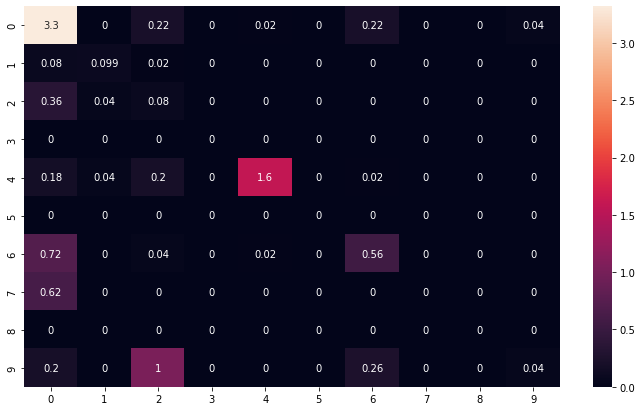

In [ ]:
# lr = 0.01
# sp = 2
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(100, model, cfg, exp, sp, optimizer, sequence)

2022-04-06 21:23:25,944 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-06 21:23:26,541 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.weight', 'fc.bias'}
2022-04-06 21:23:27,148 - mmaction - INFO - Start running, host: root@0f0a1fcc0858, work_dir: /content/mmaction2/tutorial_exps
2022-04-06 21:23:27,149 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:25:42,822 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:25:42,824 - mmaction - INFO - 
top1_acc	0.4457
top2_acc	0.6630
2022-04-06 21:25:42,824 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:25:42,826 - mmaction - INFO - 
mean_acc	0.2571
2022-04-06 21:25:45,950 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-06 21:25:45,952 - mmaction - INFO - Best top1_acc is 0.4457 at 5 epoch.
2022-04-06 21:25:45,953 - mmaction - INFO - Epoch(val) [5][6]	top1_acc: 0.4457, top2_acc: 0.6630, mean_class_accuracy: 0.2571


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.1 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:28:01,911 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:28:01,914 - mmaction - INFO - 
top1_acc	0.5543
top2_acc	0.7717
2022-04-06 21:28:01,915 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:28:01,917 - mmaction - INFO - 
mean_acc	0.3206
2022-04-06 21:28:02,003 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-06 21:28:05,163 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-06 21:28:05,164 - mmaction - INFO - Best top1_acc is 0.5543 at 10 epoch.
2022-04-06 21:28:05,165 - mmaction - INFO - Epoch(val) [10][6]	top1_acc: 0.5543, top2_acc: 0.7717, mean_class_accuracy: 0.3206


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:30:20,613 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:30:20,615 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.8261
2022-04-06 21:30:20,616 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:30:20,617 - mmaction - INFO - 
mean_acc	0.3496
2022-04-06 21:30:20,700 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-06 21:30:23,847 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-06 21:30:23,848 - mmaction - INFO - Best top1_acc is 0.5870 at 15 epoch.
2022-04-06 21:30:23,849 - mmaction - INFO - Epoch(val) [15][6]	top1_acc: 0.5870, top2_acc: 0.8261, mean_class_accuracy: 0.3496


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.1 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:32:39,854 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:32:39,856 - mmaction - INFO - 
top1_acc	0.5978
top2_acc	0.8261
2022-04-06 21:32:39,857 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:32:39,859 - mmaction - INFO - 
mean_acc	0.5133
2022-04-06 21:32:39,941 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_15.pth was removed
2022-04-06 21:32:43,091 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2022-04-06 21:32:43,093 - mmaction - INFO - Best top1_acc is 0.5978 at 20 epoch.
2022-04-06 21:32:43,093 - mmaction - INFO - Epoch(val) [20][6]	top1_acc: 0.5978, top2_acc: 0.8261, mean_class_accuracy: 0.5133
2022-04-06 21:34:54,690 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.7 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:35:02,472 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:35:02,474 - mmaction - INFO - 
top1_acc	0.5326
top2_acc	0.8261
2022-04-06 21:35:02,475 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:35:02,478 - mmaction - INFO - 
mean_acc	0.3981
2022-04-06 21:35:02,479 - mmaction - INFO - Epoch(val) [25][6]	top1_acc: 0.5326, top2_acc: 0.8261, mean_class_accuracy: 0.3981


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.4 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:37:18,095 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:37:18,097 - mmaction - INFO - 
top1_acc	0.6304
top2_acc	0.8587
2022-04-06 21:37:18,098 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:37:18,100 - mmaction - INFO - 
mean_acc	0.6695
2022-04-06 21:37:18,181 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_20.pth was removed
2022-04-06 21:37:21,320 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-06 21:37:21,322 - mmaction - INFO - Best top1_acc is 0.6304 at 30 epoch.
2022-04-06 21:37:21,323 - mmaction - INFO - Epoch(val) [30][6]	top1_acc: 0.6304, top2_acc: 0.8587, mean_class_accuracy: 0.6695


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.0 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:39:37,058 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:39:37,060 - mmaction - INFO - 
top1_acc	0.5326
top2_acc	0.8587
2022-04-06 21:39:37,061 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:39:37,063 - mmaction - INFO - 
mean_acc	0.5323
2022-04-06 21:39:37,065 - mmaction - INFO - Epoch(val) [35][6]	top1_acc: 0.5326, top2_acc: 0.8587, mean_class_accuracy: 0.5323


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:41:52,922 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:41:52,924 - mmaction - INFO - 
top1_acc	0.5978
top2_acc	0.8261
2022-04-06 21:41:52,925 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:41:52,927 - mmaction - INFO - 
mean_acc	0.6381
2022-04-06 21:41:52,928 - mmaction - INFO - Epoch(val) [40][6]	top1_acc: 0.5978, top2_acc: 0.8261, mean_class_accuracy: 0.6381


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:44:08,649 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:44:08,651 - mmaction - INFO - 
top1_acc	0.6630
top2_acc	0.8587
2022-04-06 21:44:08,652 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:44:08,655 - mmaction - INFO - 
mean_acc	0.5278
2022-04-06 21:44:08,736 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-06 21:44:11,902 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2022-04-06 21:44:11,903 - mmaction - INFO - Best top1_acc is 0.6630 at 45 epoch.
2022-04-06 21:44:11,904 - mmaction - INFO - Epoch(val) [45][6]	top1_acc: 0.6630, top2_acc: 0.8587, mean_class_accuracy: 0.5278
2022-04-06 21:46:23,671 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:46:31,413 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:46:31,415 - mmaction - INFO - 
top1_acc	0.6304
top2_acc	0.8152
2022-04-06 21:46:31,416 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:46:31,418 - mmaction - INFO - 
mean_acc	0.6161
2022-04-06 21:46:31,419 - mmaction - INFO - Epoch(val) [50][6]	top1_acc: 0.6304, top2_acc: 0.8152, mean_class_accuracy: 0.6161


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.7 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:48:47,210 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:48:47,212 - mmaction - INFO - 
top1_acc	0.6630
top2_acc	0.8913
2022-04-06 21:48:47,213 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:48:47,215 - mmaction - INFO - 
mean_acc	0.6942
2022-04-06 21:48:47,216 - mmaction - INFO - Epoch(val) [55][6]	top1_acc: 0.6630, top2_acc: 0.8913, mean_class_accuracy: 0.6942


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:51:02,897 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:51:02,900 - mmaction - INFO - 
top1_acc	0.6413
top2_acc	0.8587
2022-04-06 21:51:02,901 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:51:02,903 - mmaction - INFO - 
mean_acc	0.6214
2022-04-06 21:51:02,905 - mmaction - INFO - Epoch(val) [60][6]	top1_acc: 0.6413, top2_acc: 0.8587, mean_class_accuracy: 0.6214


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:53:18,621 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:53:18,623 - mmaction - INFO - 
top1_acc	0.7283
top2_acc	0.8587
2022-04-06 21:53:18,624 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:53:18,626 - mmaction - INFO - 
mean_acc	0.6954
2022-04-06 21:53:18,708 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_45.pth was removed
2022-04-06 21:53:21,842 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_65.pth.
2022-04-06 21:53:21,844 - mmaction - INFO - Best top1_acc is 0.7283 at 65 epoch.
2022-04-06 21:53:21,845 - mmaction - INFO - Epoch(val) [65][6]	top1_acc: 0.7283, top2_acc: 0.8587, mean_class_accuracy: 0.6954


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 21:55:37,631 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:55:37,633 - mmaction - INFO - 
top1_acc	0.6848
top2_acc	0.8804
2022-04-06 21:55:37,634 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:55:37,636 - mmaction - INFO - 
mean_acc	0.6422
2022-04-06 21:55:37,637 - mmaction - INFO - Epoch(val) [70][6]	top1_acc: 0.6848, top2_acc: 0.8804, mean_class_accuracy: 0.6422
2022-04-06 21:57:49,073 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 19.3 task/s, elapsed: 5s, ETA:     0s

2022-04-06 21:57:58,493 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 21:57:58,496 - mmaction - INFO - 
top1_acc	0.6413
top2_acc	0.8913
2022-04-06 21:57:58,497 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 21:57:58,499 - mmaction - INFO - 
mean_acc	0.6624
2022-04-06 21:57:58,500 - mmaction - INFO - Epoch(val) [75][6]	top1_acc: 0.6413, top2_acc: 0.8913, mean_class_accuracy: 0.6624


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:00:14,724 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:00:14,726 - mmaction - INFO - 
top1_acc	0.7283
top2_acc	0.8804
2022-04-06 22:00:14,727 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:00:14,730 - mmaction - INFO - 
mean_acc	0.7010
2022-04-06 22:00:14,731 - mmaction - INFO - Epoch(val) [80][6]	top1_acc: 0.7283, top2_acc: 0.8804, mean_class_accuracy: 0.7010


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:02:30,770 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:02:30,772 - mmaction - INFO - 
top1_acc	0.6739
top2_acc	0.9239
2022-04-06 22:02:30,773 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:02:30,776 - mmaction - INFO - 
mean_acc	0.6373
2022-04-06 22:02:30,777 - mmaction - INFO - Epoch(val) [85][6]	top1_acc: 0.6739, top2_acc: 0.9239, mean_class_accuracy: 0.6373


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.7 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:04:46,712 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:04:46,714 - mmaction - INFO - 
top1_acc	0.7609
top2_acc	0.9130
2022-04-06 22:04:46,716 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:04:46,718 - mmaction - INFO - 
mean_acc	0.7397
2022-04-06 22:04:46,801 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_65.pth was removed
2022-04-06 22:04:50,180 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-06 22:04:50,181 - mmaction - INFO - Best top1_acc is 0.7609 at 90 epoch.
2022-04-06 22:04:50,182 - mmaction - INFO - Epoch(val) [90][6]	top1_acc: 0.7609, top2_acc: 0.9130, mean_class_accuracy: 0.7397


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:07:05,752 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:07:05,755 - mmaction - INFO - 
top1_acc	0.7174
top2_acc	0.9022
2022-04-06 22:07:05,755 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:07:05,759 - mmaction - INFO - 
mean_acc	0.7535
2022-04-06 22:07:05,759 - mmaction - INFO - Epoch(val) [95][6]	top1_acc: 0.7174, top2_acc: 0.9022, mean_class_accuracy: 0.7535
2022-04-06 22:09:17,175 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:09:24,814 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:09:24,816 - mmaction - INFO - 
top1_acc	0.7065
top2_acc	0.9239
2022-04-06 22:09:24,817 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:09:24,819 - mmaction - INFO - 
mean_acc	0.7046
2022-04-06 22:09:24,821 - mmaction - INFO - Epoch(val) [100][6]	top1_acc: 0.7065, top2_acc: 0.9239, mean_class_accuracy: 0.7046


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 527s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4911
top2_acc	0.6302

Evaluating mean_class_accuracy ...

mean_acc	0.2390
0: 382
1: 0
2: 26
3: 0
4: 45
5: 0
6: 33
7: 0
8: 0
9: 17
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5785
top2_acc	0.7217

Evaluating mean_class_accuracy ...

mean_acc	0.4048
0: 266
1: 22
2: 41
3: 0
4: 98
5: 0
6: 59
7: 17
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5567
top2_acc	0.6918

Evaluating mean_class_accuracy ...

mean_acc	0.3864
0: 270
1: 0
2: 55
3: 0
4: 77
5: 0
6: 63
7: 38
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5924
top2_acc	0.7197

Evaluating mean_class_accuracy ...

mean_acc	0.4386
0: 275
1: 0
2: 90
3: 0
4: 80
5: 0
6: 34
7: 24
8

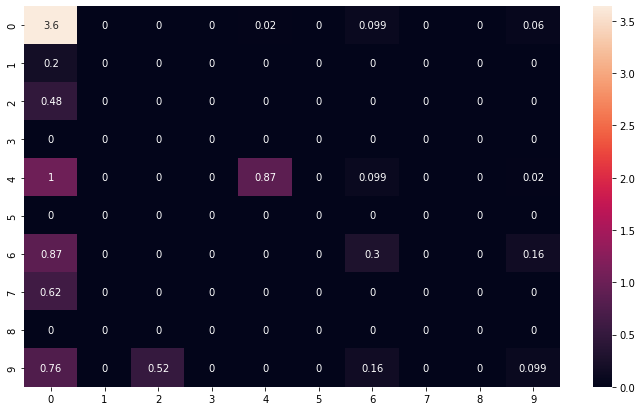

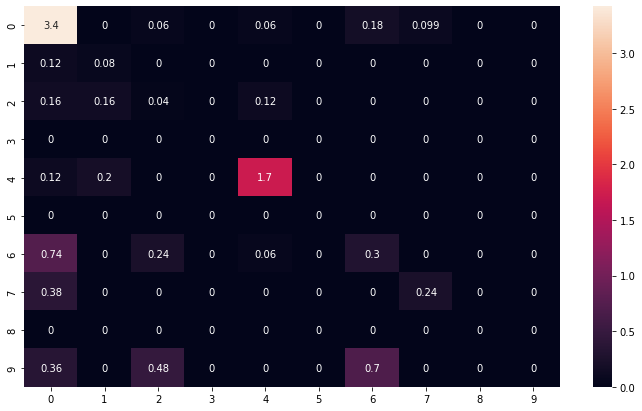

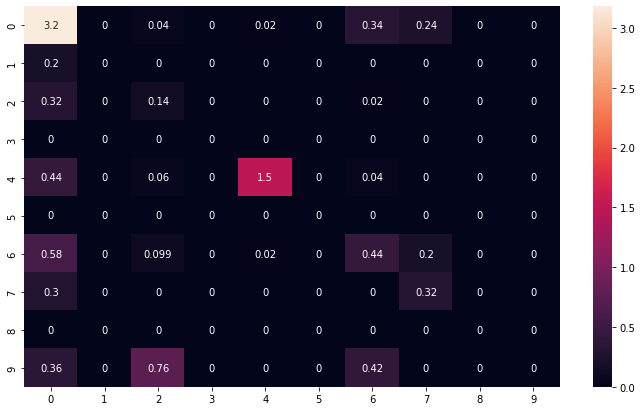

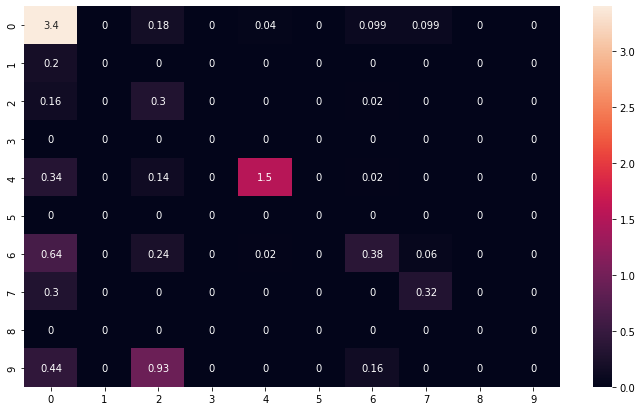

In [ ]:
lr = 0.001
epoch = 100
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(100, model, cfg, exp, sp, optimizer, sequence)

2022-04-06 22:44:44,046 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-06 22:44:44,662 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.weight', 'fc.bias'}
2022-04-06 22:44:45,273 - mmaction - INFO - Start running, host: root@0f0a1fcc0858, work_dir: /content/mmaction2/tutorial_exps
2022-04-06 22:44:45,274 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.6 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:47:01,079 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:47:01,081 - mmaction - INFO - 
top1_acc	0.3261
top2_acc	0.5326
2022-04-06 22:47:01,082 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:47:01,084 - mmaction - INFO - 
mean_acc	0.1429
2022-04-06 22:47:04,227 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-06 22:47:04,228 - mmaction - INFO - Best top1_acc is 0.3261 at 5 epoch.
2022-04-06 22:47:04,229 - mmaction - INFO - Epoch(val) [5][6]	top1_acc: 0.3261, top2_acc: 0.5326, mean_class_accuracy: 0.1429


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:49:19,945 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:49:19,948 - mmaction - INFO - 
top1_acc	0.3261
top2_acc	0.5543
2022-04-06 22:49:19,949 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:49:19,951 - mmaction - INFO - 
mean_acc	0.1429
2022-04-06 22:49:19,952 - mmaction - INFO - Epoch(val) [10][6]	top1_acc: 0.3261, top2_acc: 0.5543, mean_class_accuracy: 0.1429


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:51:36,199 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:51:36,201 - mmaction - INFO - 
top1_acc	0.3261
top2_acc	0.5326
2022-04-06 22:51:36,202 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:51:36,205 - mmaction - INFO - 
mean_acc	0.1429
2022-04-06 22:51:36,206 - mmaction - INFO - Epoch(val) [15][6]	top1_acc: 0.3261, top2_acc: 0.5326, mean_class_accuracy: 0.1429


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:53:51,662 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:53:51,664 - mmaction - INFO - 
top1_acc	0.3261
top2_acc	0.6413
2022-04-06 22:53:51,665 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:53:51,667 - mmaction - INFO - 
mean_acc	0.1429
2022-04-06 22:53:51,668 - mmaction - INFO - Epoch(val) [20][6]	top1_acc: 0.3261, top2_acc: 0.6413, mean_class_accuracy: 0.1429
2022-04-06 22:56:03,536 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.6 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:56:11,129 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:56:11,131 - mmaction - INFO - 
top1_acc	0.3261
top2_acc	0.6304
2022-04-06 22:56:11,132 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:56:11,134 - mmaction - INFO - 
mean_acc	0.1429
2022-04-06 22:56:11,135 - mmaction - INFO - Epoch(val) [25][6]	top1_acc: 0.3261, top2_acc: 0.6304, mean_class_accuracy: 0.1429


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 22:58:26,985 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 22:58:26,988 - mmaction - INFO - 
top1_acc	0.4022
top2_acc	0.6304
2022-04-06 22:58:26,988 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 22:58:26,991 - mmaction - INFO - 
mean_acc	0.2004
2022-04-06 22:58:27,072 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-06 22:58:30,077 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-06 22:58:30,078 - mmaction - INFO - Best top1_acc is 0.4022 at 30 epoch.
2022-04-06 22:58:30,079 - mmaction - INFO - Epoch(val) [30][6]	top1_acc: 0.4022, top2_acc: 0.6304, mean_class_accuracy: 0.2004


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.6 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:00:45,485 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:00:45,487 - mmaction - INFO - 
top1_acc	0.4457
top2_acc	0.6630
2022-04-06 23:00:45,488 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:00:45,491 - mmaction - INFO - 
mean_acc	0.2321
2022-04-06 23:00:45,571 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-06 23:00:48,588 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2022-04-06 23:00:48,589 - mmaction - INFO - Best top1_acc is 0.4457 at 35 epoch.
2022-04-06 23:00:48,590 - mmaction - INFO - Epoch(val) [35][6]	top1_acc: 0.4457, top2_acc: 0.6630, mean_class_accuracy: 0.2321


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:03:04,553 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:03:04,555 - mmaction - INFO - 
top1_acc	0.5000
top2_acc	0.6848
2022-04-06 23:03:04,556 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:03:04,559 - mmaction - INFO - 
mean_acc	0.2780
2022-04-06 23:03:04,639 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_35.pth was removed
2022-04-06 23:03:07,623 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2022-04-06 23:03:07,624 - mmaction - INFO - Best top1_acc is 0.5000 at 40 epoch.
2022-04-06 23:03:07,625 - mmaction - INFO - Epoch(val) [40][6]	top1_acc: 0.5000, top2_acc: 0.6848, mean_class_accuracy: 0.2780


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.4 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:05:23,308 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:05:23,310 - mmaction - INFO - 
top1_acc	0.5217
top2_acc	0.7174
2022-04-06 23:05:23,311 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:05:23,313 - mmaction - INFO - 
mean_acc	0.3032
2022-04-06 23:05:23,394 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_40.pth was removed
2022-04-06 23:05:26,408 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2022-04-06 23:05:26,410 - mmaction - INFO - Best top1_acc is 0.5217 at 45 epoch.
2022-04-06 23:05:26,411 - mmaction - INFO - Epoch(val) [45][6]	top1_acc: 0.5217, top2_acc: 0.7174, mean_class_accuracy: 0.3032
2022-04-06 23:07:37,828 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:07:45,330 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:07:45,333 - mmaction - INFO - 
top1_acc	0.5217
top2_acc	0.7283
2022-04-06 23:07:45,334 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:07:45,336 - mmaction - INFO - 
mean_acc	0.2990
2022-04-06 23:07:45,337 - mmaction - INFO - Epoch(val) [50][6]	top1_acc: 0.5217, top2_acc: 0.7283, mean_class_accuracy: 0.2990


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.4 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:10:01,520 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:10:01,522 - mmaction - INFO - 
top1_acc	0.5435
top2_acc	0.7391
2022-04-06 23:10:01,523 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:10:01,525 - mmaction - INFO - 
mean_acc	0.3117
2022-04-06 23:10:01,607 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_45.pth was removed
2022-04-06 23:10:04,638 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_55.pth.
2022-04-06 23:10:04,639 - mmaction - INFO - Best top1_acc is 0.5435 at 55 epoch.
2022-04-06 23:10:04,641 - mmaction - INFO - Epoch(val) [55][6]	top1_acc: 0.5435, top2_acc: 0.7391, mean_class_accuracy: 0.3117


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:12:20,535 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:12:20,538 - mmaction - INFO - 
top1_acc	0.5761
top2_acc	0.8043
2022-04-06 23:12:20,539 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:12:20,541 - mmaction - INFO - 
mean_acc	0.3375
2022-04-06 23:12:20,623 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_55.pth was removed
2022-04-06 23:12:23,660 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_60.pth.
2022-04-06 23:12:23,661 - mmaction - INFO - Best top1_acc is 0.5761 at 60 epoch.
2022-04-06 23:12:23,662 - mmaction - INFO - Epoch(val) [60][6]	top1_acc: 0.5761, top2_acc: 0.8043, mean_class_accuracy: 0.3375


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.8 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:14:39,179 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:14:39,181 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.7609
2022-04-06 23:14:39,182 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:14:39,185 - mmaction - INFO - 
mean_acc	0.3444
2022-04-06 23:14:39,269 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_60.pth was removed
2022-04-06 23:14:42,267 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_65.pth.
2022-04-06 23:14:42,268 - mmaction - INFO - Best top1_acc is 0.5870 at 65 epoch.
2022-04-06 23:14:42,269 - mmaction - INFO - Epoch(val) [65][6]	top1_acc: 0.5870, top2_acc: 0.7609, mean_class_accuracy: 0.3444


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.5 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:16:58,114 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:16:58,116 - mmaction - INFO - 
top1_acc	0.5435
top2_acc	0.7826
2022-04-06 23:16:58,117 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:16:58,119 - mmaction - INFO - 
mean_acc	0.3149
2022-04-06 23:16:58,121 - mmaction - INFO - Epoch(val) [70][6]	top1_acc: 0.5435, top2_acc: 0.7826, mean_class_accuracy: 0.3149
2022-04-06 23:19:09,854 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:19:17,307 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:19:17,309 - mmaction - INFO - 
top1_acc	0.5652
top2_acc	0.7609
2022-04-06 23:19:17,310 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:19:17,312 - mmaction - INFO - 
mean_acc	0.3286
2022-04-06 23:19:17,314 - mmaction - INFO - Epoch(val) [75][6]	top1_acc: 0.5652, top2_acc: 0.7609, mean_class_accuracy: 0.3286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.1 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:21:33,371 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:21:33,373 - mmaction - INFO - 
top1_acc	0.5761
top2_acc	0.7717
2022-04-06 23:21:33,374 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:21:33,376 - mmaction - INFO - 
mean_acc	0.3514
2022-04-06 23:21:33,377 - mmaction - INFO - Epoch(val) [80][6]	top1_acc: 0.5761, top2_acc: 0.7717, mean_class_accuracy: 0.3514


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.6 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:23:49,333 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:23:49,335 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.7717
2022-04-06 23:23:49,336 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:23:49,338 - mmaction - INFO - 
mean_acc	0.3794
2022-04-06 23:23:49,339 - mmaction - INFO - Epoch(val) [85][6]	top1_acc: 0.5870, top2_acc: 0.7717, mean_class_accuracy: 0.3794


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.3 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:26:05,021 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:26:05,023 - mmaction - INFO - 
top1_acc	0.6087
top2_acc	0.8152
2022-04-06 23:26:05,024 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:26:05,026 - mmaction - INFO - 
mean_acc	0.3911
2022-04-06 23:26:05,108 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_65.pth was removed
2022-04-06 23:26:08,378 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-06 23:26:08,379 - mmaction - INFO - Best top1_acc is 0.6087 at 90 epoch.
2022-04-06 23:26:08,380 - mmaction - INFO - Epoch(val) [90][6]	top1_acc: 0.6087, top2_acc: 0.8152, mean_class_accuracy: 0.3911


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 21.9 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:28:24,871 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:28:24,873 - mmaction - INFO - 
top1_acc	0.5870
top2_acc	0.8043
2022-04-06 23:28:24,874 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:28:24,876 - mmaction - INFO - 
mean_acc	0.3603
2022-04-06 23:28:24,878 - mmaction - INFO - Epoch(val) [95][6]	top1_acc: 0.5870, top2_acc: 0.8043, mean_class_accuracy: 0.3603
2022-04-06 23:30:36,485 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 92/92, 22.2 task/s, elapsed: 4s, ETA:     0s

2022-04-06 23:30:43,971 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-06 23:30:43,973 - mmaction - INFO - 
top1_acc	0.5761
top2_acc	0.7935
2022-04-06 23:30:43,974 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-06 23:30:43,977 - mmaction - INFO - 
mean_acc	0.3556
2022-04-06 23:30:43,978 - mmaction - INFO - Epoch(val) [100][6]	top1_acc: 0.5761, top2_acc: 0.7935, mean_class_accuracy: 0.3556


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.3817
top2_acc	0.5825

Evaluating mean_class_accuracy ...

mean_acc	0.1429
0: 503
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4871
top2_acc	0.5924

Evaluating mean_class_accuracy ...

mean_acc	0.2230
0: 390
1: 0
2: 29
3: 0
4: 84
5: 0
6: 0
7: 0
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4970
top2_acc	0.6581

Evaluating mean_class_accuracy ...

mean_acc	0.2496
0: 282
1: 0
2: 94
3: 0
4: 127
5: 0
6: 0
7: 0
8: 0
9: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 503/503, 1.0 task/s, elapsed: 526s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5249
top2_acc	0.6680

Evaluating mean_class_accuracy ...

mean_acc	0.2907
0: 283
1: 0
2: 92
3: 0
4: 128
5: 0
6: 0
7: 0
8: 0
9: 0


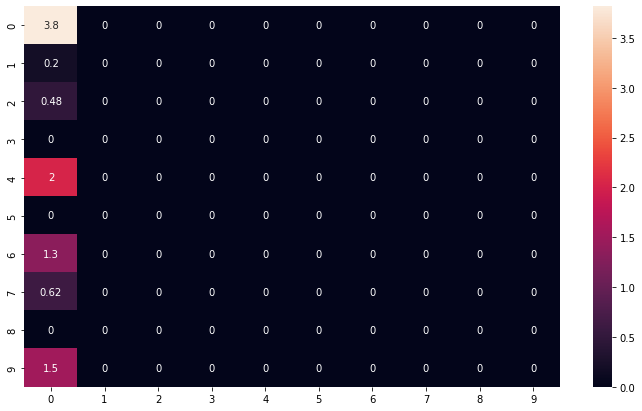

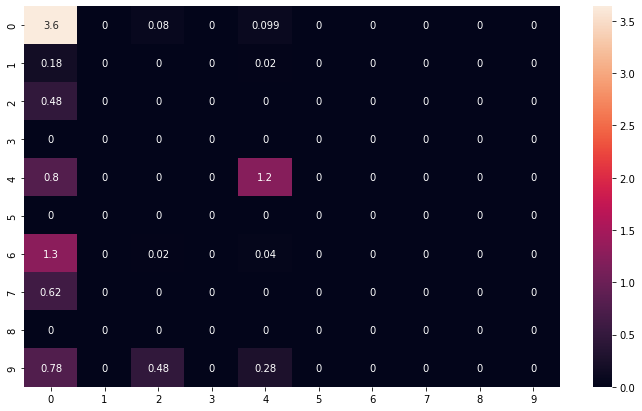

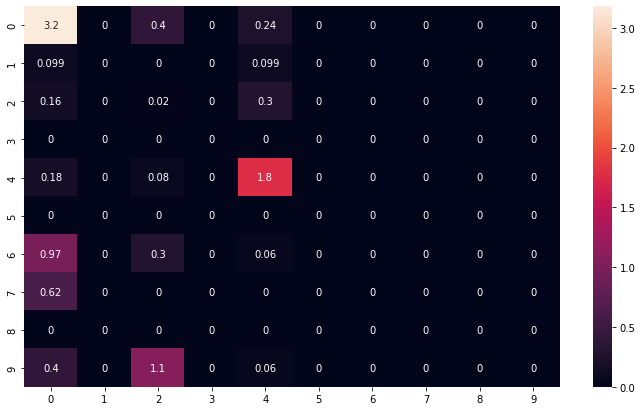

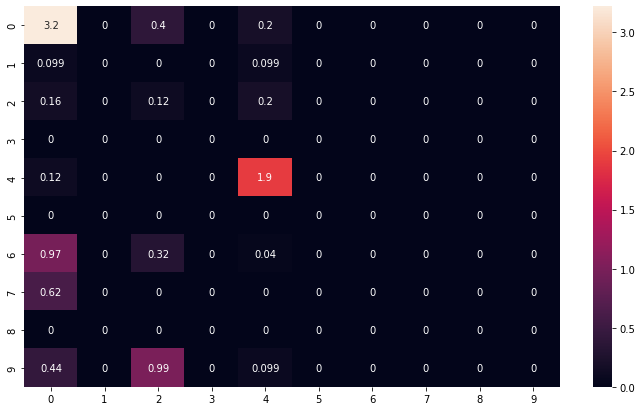

In [ ]:
lr = 0.0001
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(100, model, cfg, exp, sp, optimizer, sequence)

2022-04-05 16:19:01,431 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-05 16:19:01,772 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-05 16:19:02,741 - mmaction - INFO - Start running, host: root@228e89623c4a, work_dir: /content/mmaction2/tutorial_exps
2022-04-05 16:19:02,743 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:21:00,881 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:21:00,884 - mmaction - INFO - 
top1_acc	0.4706
top2_acc	0.7647
2022-04-05 16:21:00,885 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:21:00,887 - mmaction - INFO - 
mean_acc	0.4335
2022-04-05 16:21:04,061 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-05 16:21:04,063 - mmaction - INFO - Best top1_acc is 0.4706 at 5 epoch.
2022-04-05 16:21:04,065 - mmaction - INFO - Epoch(val) [5][8]	top1_acc: 0.4706, top2_acc: 0.7647, mean_class_accuracy: 0.4335


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:23:01,633 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:23:01,635 - mmaction - INFO - 
top1_acc	0.6891
top2_acc	0.8908
2022-04-05 16:23:01,636 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:23:01,639 - mmaction - INFO - 
mean_acc	0.5097
2022-04-05 16:23:01,719 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-05 16:23:04,825 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-05 16:23:04,826 - mmaction - INFO - Best top1_acc is 0.6891 at 10 epoch.
2022-04-05 16:23:04,827 - mmaction - INFO - Epoch(val) [10][8]	top1_acc: 0.6891, top2_acc: 0.8908, mean_class_accuracy: 0.5097


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:25:02,875 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:25:02,877 - mmaction - INFO - 
top1_acc	0.6555
top2_acc	0.9076
2022-04-05 16:25:02,878 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:25:02,880 - mmaction - INFO - 
mean_acc	0.5399
2022-04-05 16:25:02,881 - mmaction - INFO - Epoch(val) [15][8]	top1_acc: 0.6555, top2_acc: 0.9076, mean_class_accuracy: 0.5399


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.6 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:27:01,031 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:27:01,033 - mmaction - INFO - 
top1_acc	0.7143
top2_acc	0.8655
2022-04-05 16:27:01,034 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:27:01,036 - mmaction - INFO - 
mean_acc	0.5518
2022-04-05 16:27:01,117 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-05 16:27:04,282 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2022-04-05 16:27:04,283 - mmaction - INFO - Best top1_acc is 0.7143 at 20 epoch.
2022-04-05 16:27:04,285 - mmaction - INFO - Epoch(val) [20][8]	top1_acc: 0.7143, top2_acc: 0.8655, mean_class_accuracy: 0.5518
2022-04-05 16:28:58,140 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:29:06,017 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:29:06,020 - mmaction - INFO - 
top1_acc	0.7059
top2_acc	0.9160
2022-04-05 16:29:06,021 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:29:06,023 - mmaction - INFO - 
mean_acc	0.4980
2022-04-05 16:29:06,024 - mmaction - INFO - Epoch(val) [25][8]	top1_acc: 0.7059, top2_acc: 0.9160, mean_class_accuracy: 0.4980


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:31:03,946 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:31:03,948 - mmaction - INFO - 
top1_acc	0.8235
top2_acc	0.9328
2022-04-05 16:31:03,949 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:31:03,952 - mmaction - INFO - 
mean_acc	0.6944
2022-04-05 16:31:04,033 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_20.pth was removed
2022-04-05 16:31:07,101 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-05 16:31:07,102 - mmaction - INFO - Best top1_acc is 0.8235 at 30 epoch.
2022-04-05 16:31:07,104 - mmaction - INFO - Epoch(val) [30][8]	top1_acc: 0.8235, top2_acc: 0.9328, mean_class_accuracy: 0.6944


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:33:04,721 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:33:04,723 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9328
2022-04-05 16:33:04,724 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:33:04,727 - mmaction - INFO - 
mean_acc	0.7965
2022-04-05 16:33:04,808 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-05 16:33:07,921 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2022-04-05 16:33:07,922 - mmaction - INFO - Best top1_acc is 0.8403 at 35 epoch.
2022-04-05 16:33:07,923 - mmaction - INFO - Epoch(val) [35][8]	top1_acc: 0.8403, top2_acc: 0.9328, mean_class_accuracy: 0.7965


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:35:05,808 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:35:05,811 - mmaction - INFO - 
top1_acc	0.7815
top2_acc	0.9832
2022-04-05 16:35:05,812 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:35:05,818 - mmaction - INFO - 
mean_acc	0.5770
2022-04-05 16:35:05,819 - mmaction - INFO - Epoch(val) [40][8]	top1_acc: 0.7815, top2_acc: 0.9832, mean_class_accuracy: 0.5770


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:37:03,780 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:37:03,782 - mmaction - INFO - 
top1_acc	0.8319
top2_acc	0.9244
2022-04-05 16:37:03,784 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:37:03,786 - mmaction - INFO - 
mean_acc	0.6872
2022-04-05 16:37:03,787 - mmaction - INFO - Epoch(val) [45][8]	top1_acc: 0.8319, top2_acc: 0.9244, mean_class_accuracy: 0.6872
2022-04-05 16:38:57,631 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:39:05,358 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:39:05,361 - mmaction - INFO - 
top1_acc	0.7899
top2_acc	0.9580
2022-04-05 16:39:05,362 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:39:05,364 - mmaction - INFO - 
mean_acc	0.8156
2022-04-05 16:39:05,365 - mmaction - INFO - Epoch(val) [50][8]	top1_acc: 0.7899, top2_acc: 0.9580, mean_class_accuracy: 0.8156


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:41:02,904 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:41:02,907 - mmaction - INFO - 
top1_acc	0.7227
top2_acc	0.9076
2022-04-05 16:41:02,909 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:41:02,911 - mmaction - INFO - 
mean_acc	0.7882
2022-04-05 16:41:02,912 - mmaction - INFO - Epoch(val) [55][8]	top1_acc: 0.7227, top2_acc: 0.9076, mean_class_accuracy: 0.7882


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:43:00,753 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:43:00,755 - mmaction - INFO - 
top1_acc	0.7647
top2_acc	0.8908
2022-04-05 16:43:00,757 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:43:00,760 - mmaction - INFO - 
mean_acc	0.6601
2022-04-05 16:43:00,761 - mmaction - INFO - Epoch(val) [60][8]	top1_acc: 0.7647, top2_acc: 0.8908, mean_class_accuracy: 0.6601


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 30.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:44:58,069 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:44:58,072 - mmaction - INFO - 
top1_acc	0.8235
top2_acc	0.9496
2022-04-05 16:44:58,073 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:44:58,077 - mmaction - INFO - 
mean_acc	0.6423
2022-04-05 16:44:58,078 - mmaction - INFO - Epoch(val) [65][8]	top1_acc: 0.8235, top2_acc: 0.9496, mean_class_accuracy: 0.6423


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 30.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:46:55,265 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:46:55,268 - mmaction - INFO - 
top1_acc	0.8235
top2_acc	0.9832
2022-04-05 16:46:55,269 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:46:55,271 - mmaction - INFO - 
mean_acc	0.8002
2022-04-05 16:46:55,272 - mmaction - INFO - Epoch(val) [70][8]	top1_acc: 0.8235, top2_acc: 0.9832, mean_class_accuracy: 0.8002
2022-04-05 16:48:48,646 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:48:56,209 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:48:56,212 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9580
2022-04-05 16:48:56,213 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:48:56,215 - mmaction - INFO - 
mean_acc	0.8300
2022-04-05 16:48:56,299 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_35.pth was removed
2022-04-05 16:48:59,360 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_75.pth.
2022-04-05 16:48:59,362 - mmaction - INFO - Best top1_acc is 0.8487 at 75 epoch.
2022-04-05 16:48:59,363 - mmaction - INFO - Epoch(val) [75][8]	top1_acc: 0.8487, top2_acc: 0.9580, mean_class_accuracy: 0.8300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:50:56,706 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:50:56,708 - mmaction - INFO - 
top1_acc	0.8908
top2_acc	0.9580
2022-04-05 16:50:56,709 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:50:56,713 - mmaction - INFO - 
mean_acc	0.8490
2022-04-05 16:50:56,798 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_75.pth was removed
2022-04-05 16:50:59,896 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_80.pth.
2022-04-05 16:50:59,898 - mmaction - INFO - Best top1_acc is 0.8908 at 80 epoch.
2022-04-05 16:50:59,899 - mmaction - INFO - Epoch(val) [80][8]	top1_acc: 0.8908, top2_acc: 0.9580, mean_class_accuracy: 0.8490


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:52:57,982 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:52:57,984 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9664
2022-04-05 16:52:57,986 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:52:57,988 - mmaction - INFO - 
mean_acc	0.8321
2022-04-05 16:52:57,989 - mmaction - INFO - Epoch(val) [85][8]	top1_acc: 0.8655, top2_acc: 0.9664, mean_class_accuracy: 0.8321


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:54:56,212 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:54:56,214 - mmaction - INFO - 
top1_acc	0.8992
top2_acc	0.9664
2022-04-05 16:54:56,215 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:54:56,217 - mmaction - INFO - 
mean_acc	0.8521
2022-04-05 16:54:56,303 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_80.pth was removed
2022-04-05 16:54:59,633 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-05 16:54:59,635 - mmaction - INFO - Best top1_acc is 0.8992 at 90 epoch.
2022-04-05 16:54:59,636 - mmaction - INFO - Epoch(val) [90][8]	top1_acc: 0.8992, top2_acc: 0.9664, mean_class_accuracy: 0.8521


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:56:57,533 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:56:57,535 - mmaction - INFO - 
top1_acc	0.8908
top2_acc	0.9664
2022-04-05 16:56:57,536 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:56:57,538 - mmaction - INFO - 
mean_acc	0.8235
2022-04-05 16:56:57,539 - mmaction - INFO - Epoch(val) [95][8]	top1_acc: 0.8908, top2_acc: 0.9664, mean_class_accuracy: 0.8235
2022-04-05 16:58:51,549 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 16:58:59,173 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 16:58:59,176 - mmaction - INFO - 
top1_acc	0.8908
top2_acc	0.9580
2022-04-05 16:58:59,177 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 16:58:59,180 - mmaction - INFO - 
mean_acc	0.8265
2022-04-05 16:58:59,181 - mmaction - INFO - Epoch(val) [100][8]	top1_acc: 0.8908, top2_acc: 0.9580, mean_class_accuracy: 0.8265


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 197s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5159
top2_acc	0.6899

Evaluating mean_class_accuracy ...

mean_acc	0.3224
0: 242
1: 0
2: 24
3: 0
4: 61
5: 0
6: 0
7: 0
8: 0
9: 18
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 197s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5072
top2_acc	0.6870

Evaluating mean_class_accuracy ...

mean_acc	0.4139
0: 98
1: 1
2: 5
3: 0
4: 69
5: 0
6: 130
7: 27
8: 0
9: 15
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 195s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.6203
top2_acc	0.7652

Evaluating mean_class_accuracy ...

mean_acc	0.5203
0: 175
1: 9
2: 10
3: 0
4: 70
5: 0
6: 57
7: 18
8: 0
9: 6
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 195s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.6145
top2_acc	0.7565

Evaluating mean_class_accuracy ...

mean_acc	0.5448
0: 166
1: 3
2: 9
3: 0
4: 75
5: 0
6: 33
7: 32
8: 0

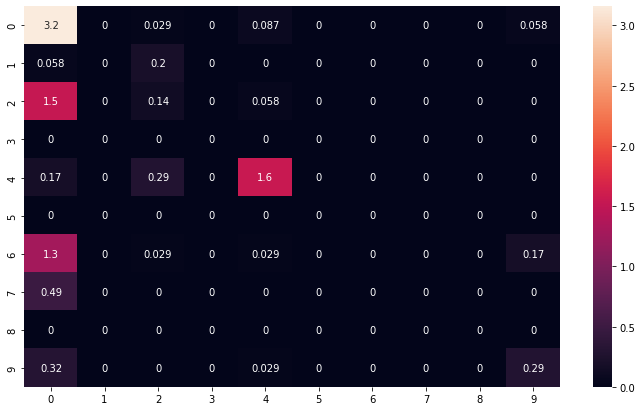

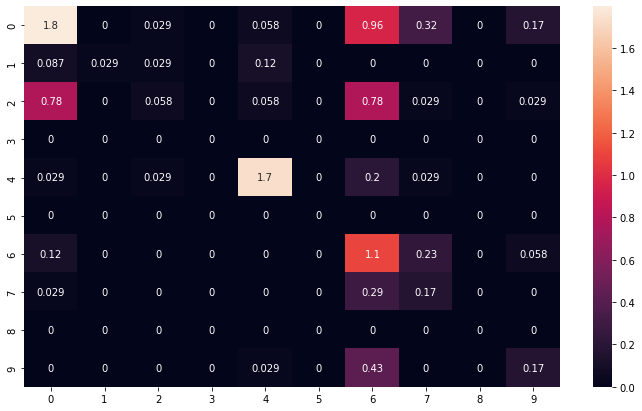

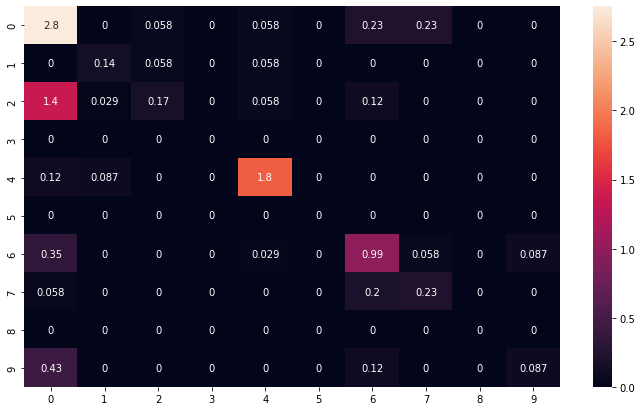

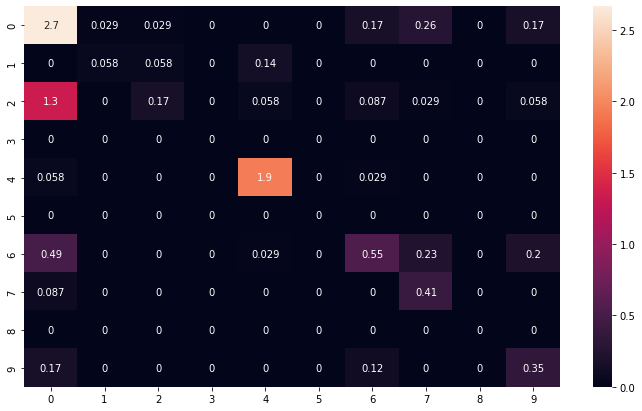

In [ ]:
sp=3
lr = 0.01
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(100, model, cfg, exp, sp, optimizer, sequence)

2022-04-05 17:12:18,102 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-05 17:12:18,511 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-05 17:12:19,103 - mmaction - INFO - Start running, host: root@228e89623c4a, work_dir: /content/mmaction2/tutorial_exps
2022-04-05 17:12:19,105 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:14:17,109 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:14:17,111 - mmaction - INFO - 
top1_acc	0.5210
top2_acc	0.7899
2022-04-05 17:14:17,112 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:14:17,115 - mmaction - INFO - 
mean_acc	0.2704
2022-04-05 17:14:20,308 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-05 17:14:20,310 - mmaction - INFO - Best top1_acc is 0.5210 at 5 epoch.
2022-04-05 17:14:20,311 - mmaction - INFO - Epoch(val) [5][8]	top1_acc: 0.5210, top2_acc: 0.7899, mean_class_accuracy: 0.2704


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.0 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:16:18,421 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:16:18,424 - mmaction - INFO - 
top1_acc	0.6218
top2_acc	0.8403
2022-04-05 17:16:18,425 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:16:18,427 - mmaction - INFO - 
mean_acc	0.3333
2022-04-05 17:16:18,509 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-05 17:16:21,667 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-05 17:16:21,669 - mmaction - INFO - Best top1_acc is 0.6218 at 10 epoch.
2022-04-05 17:16:21,670 - mmaction - INFO - Epoch(val) [10][8]	top1_acc: 0.6218, top2_acc: 0.8403, mean_class_accuracy: 0.3333


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:18:19,966 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:18:19,968 - mmaction - INFO - 
top1_acc	0.6807
top2_acc	0.8739
2022-04-05 17:18:19,969 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:18:19,972 - mmaction - INFO - 
mean_acc	0.4979
2022-04-05 17:18:20,055 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-05 17:18:23,232 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-05 17:18:23,233 - mmaction - INFO - Best top1_acc is 0.6807 at 15 epoch.
2022-04-05 17:18:23,235 - mmaction - INFO - Epoch(val) [15][8]	top1_acc: 0.6807, top2_acc: 0.8739, mean_class_accuracy: 0.4979


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:20:21,727 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:20:21,729 - mmaction - INFO - 
top1_acc	0.7647
top2_acc	0.9496
2022-04-05 17:20:21,730 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:20:21,733 - mmaction - INFO - 
mean_acc	0.6370
2022-04-05 17:20:21,815 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_15.pth was removed
2022-04-05 17:20:24,964 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2022-04-05 17:20:24,965 - mmaction - INFO - Best top1_acc is 0.7647 at 20 epoch.
2022-04-05 17:20:24,966 - mmaction - INFO - Epoch(val) [20][8]	top1_acc: 0.7647, top2_acc: 0.9496, mean_class_accuracy: 0.6370
2022-04-05 17:22:19,037 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.0 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:22:26,871 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:22:26,874 - mmaction - INFO - 
top1_acc	0.7311
top2_acc	0.9244
2022-04-05 17:22:26,875 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:22:26,878 - mmaction - INFO - 
mean_acc	0.5476
2022-04-05 17:22:26,879 - mmaction - INFO - Epoch(val) [25][8]	top1_acc: 0.7311, top2_acc: 0.9244, mean_class_accuracy: 0.5476


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:24:25,121 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:24:25,123 - mmaction - INFO - 
top1_acc	0.6891
top2_acc	0.9328
2022-04-05 17:24:25,124 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:24:25,127 - mmaction - INFO - 
mean_acc	0.5463
2022-04-05 17:24:25,128 - mmaction - INFO - Epoch(val) [30][8]	top1_acc: 0.6891, top2_acc: 0.9328, mean_class_accuracy: 0.5463


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:26:23,483 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:26:23,485 - mmaction - INFO - 
top1_acc	0.7815
top2_acc	0.9412
2022-04-05 17:26:23,486 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:26:23,489 - mmaction - INFO - 
mean_acc	0.7103
2022-04-05 17:26:23,569 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_20.pth was removed
2022-04-05 17:26:26,698 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2022-04-05 17:26:26,699 - mmaction - INFO - Best top1_acc is 0.7815 at 35 epoch.
2022-04-05 17:26:26,700 - mmaction - INFO - Epoch(val) [35][8]	top1_acc: 0.7815, top2_acc: 0.9412, mean_class_accuracy: 0.7103


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.0 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:28:24,777 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:28:24,779 - mmaction - INFO - 
top1_acc	0.6555
top2_acc	0.9160
2022-04-05 17:28:24,780 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:28:24,783 - mmaction - INFO - 
mean_acc	0.5953
2022-04-05 17:28:24,783 - mmaction - INFO - Epoch(val) [40][8]	top1_acc: 0.6555, top2_acc: 0.9160, mean_class_accuracy: 0.5953


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:30:23,277 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:30:23,279 - mmaction - INFO - 
top1_acc	0.8235
top2_acc	0.9244
2022-04-05 17:30:23,280 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:30:23,283 - mmaction - INFO - 
mean_acc	0.7554
2022-04-05 17:30:23,365 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_35.pth was removed
2022-04-05 17:30:26,534 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2022-04-05 17:30:26,535 - mmaction - INFO - Best top1_acc is 0.8235 at 45 epoch.
2022-04-05 17:30:26,536 - mmaction - INFO - Epoch(val) [45][8]	top1_acc: 0.8235, top2_acc: 0.9244, mean_class_accuracy: 0.7554
2022-04-05 17:32:20,522 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.6 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:32:28,262 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:32:28,265 - mmaction - INFO - 
top1_acc	0.7731
top2_acc	0.9244
2022-04-05 17:32:28,266 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:32:28,268 - mmaction - INFO - 
mean_acc	0.7683
2022-04-05 17:32:28,269 - mmaction - INFO - Epoch(val) [50][8]	top1_acc: 0.7731, top2_acc: 0.9244, mean_class_accuracy: 0.7683


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:34:26,480 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:34:26,482 - mmaction - INFO - 
top1_acc	0.7563
top2_acc	0.9076
2022-04-05 17:34:26,483 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:34:26,486 - mmaction - INFO - 
mean_acc	0.7192
2022-04-05 17:34:26,487 - mmaction - INFO - Epoch(val) [55][8]	top1_acc: 0.7563, top2_acc: 0.9076, mean_class_accuracy: 0.7192


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:36:25,099 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:36:25,101 - mmaction - INFO - 
top1_acc	0.7731
top2_acc	0.9328
2022-04-05 17:36:25,102 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:36:25,104 - mmaction - INFO - 
mean_acc	0.7683
2022-04-05 17:36:25,105 - mmaction - INFO - Epoch(val) [60][8]	top1_acc: 0.7731, top2_acc: 0.9328, mean_class_accuracy: 0.7683


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:38:23,539 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:38:23,541 - mmaction - INFO - 
top1_acc	0.7647
top2_acc	0.9664
2022-04-05 17:38:23,542 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:38:23,545 - mmaction - INFO - 
mean_acc	0.7083
2022-04-05 17:38:23,546 - mmaction - INFO - Epoch(val) [65][8]	top1_acc: 0.7647, top2_acc: 0.9664, mean_class_accuracy: 0.7083


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 30.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:40:21,577 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:40:21,580 - mmaction - INFO - 
top1_acc	0.7815
top2_acc	0.9580
2022-04-05 17:40:21,581 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:40:21,584 - mmaction - INFO - 
mean_acc	0.7596
2022-04-05 17:40:21,585 - mmaction - INFO - Epoch(val) [70][8]	top1_acc: 0.7815, top2_acc: 0.9580, mean_class_accuracy: 0.7596
2022-04-05 17:42:15,697 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:42:23,473 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:42:23,475 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9580
2022-04-05 17:42:23,476 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:42:23,479 - mmaction - INFO - 
mean_acc	0.7876
2022-04-05 17:42:23,560 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_45.pth was removed
2022-04-05 17:42:26,672 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_75.pth.
2022-04-05 17:42:26,673 - mmaction - INFO - Best top1_acc is 0.8403 at 75 epoch.
2022-04-05 17:42:26,675 - mmaction - INFO - Epoch(val) [75][8]	top1_acc: 0.8403, top2_acc: 0.9580, mean_class_accuracy: 0.7876


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:44:24,507 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:44:24,509 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9748
2022-04-05 17:44:24,510 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:44:24,513 - mmaction - INFO - 
mean_acc	0.7650
2022-04-05 17:44:24,514 - mmaction - INFO - Epoch(val) [80][8]	top1_acc: 0.8403, top2_acc: 0.9748, mean_class_accuracy: 0.7650


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:46:22,492 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:46:22,494 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9664
2022-04-05 17:46:22,495 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:46:22,498 - mmaction - INFO - 
mean_acc	0.8103
2022-04-05 17:46:22,580 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_75.pth was removed
2022-04-05 17:46:25,703 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_85.pth.
2022-04-05 17:46:25,704 - mmaction - INFO - Best top1_acc is 0.8487 at 85 epoch.
2022-04-05 17:46:25,705 - mmaction - INFO - Epoch(val) [85][8]	top1_acc: 0.8487, top2_acc: 0.9664, mean_class_accuracy: 0.8103


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:48:23,902 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:48:23,904 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9664
2022-04-05 17:48:23,905 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:48:23,907 - mmaction - INFO - 
mean_acc	0.7876
2022-04-05 17:48:23,908 - mmaction - INFO - Epoch(val) [90][8]	top1_acc: 0.8403, top2_acc: 0.9664, mean_class_accuracy: 0.7876


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:50:21,950 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:50:21,952 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9580
2022-04-05 17:50:21,953 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:50:21,956 - mmaction - INFO - 
mean_acc	0.7591
2022-04-05 17:50:21,956 - mmaction - INFO - Epoch(val) [95][8]	top1_acc: 0.8403, top2_acc: 0.9580, mean_class_accuracy: 0.7591
2022-04-05 17:52:15,757 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.0 task/s, elapsed: 4s, ETA:     0s

2022-04-05 17:52:23,310 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 17:52:23,313 - mmaction - INFO - 
top1_acc	0.8235
top2_acc	0.9664
2022-04-05 17:52:23,314 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 17:52:23,316 - mmaction - INFO - 
mean_acc	0.7560
2022-04-05 17:52:23,317 - mmaction - INFO - Epoch(val) [100][8]	top1_acc: 0.8235, top2_acc: 0.9664, mean_class_accuracy: 0.7560


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5275
top2_acc	0.7130

Evaluating mean_class_accuracy ...

mean_acc	0.3654
0: 217
1: 0
2: 4
3: 0
4: 63
5: 0
6: 35
7: 0
8: 0
9: 26
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5420
top2_acc	0.7275

Evaluating mean_class_accuracy ...

mean_acc	0.5192
0: 99
1: 4
2: 3
3: 0
4: 74
5: 0
6: 40
7: 57
8: 0
9: 68
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.6058
top2_acc	0.7420

Evaluating mean_class_accuracy ...

mean_acc	0.5399
0: 144
1: 1
2: 1
3: 0
4: 83
5: 0
6: 32
7: 31
8: 0
9: 53
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5971
top2_acc	0.7420

Evaluating mean_class_accuracy ...

mean_acc	0.5189
0: 120
1: 0
2: 5
3: 0
4: 83
5: 0
6: 35
7: 32
8: 0


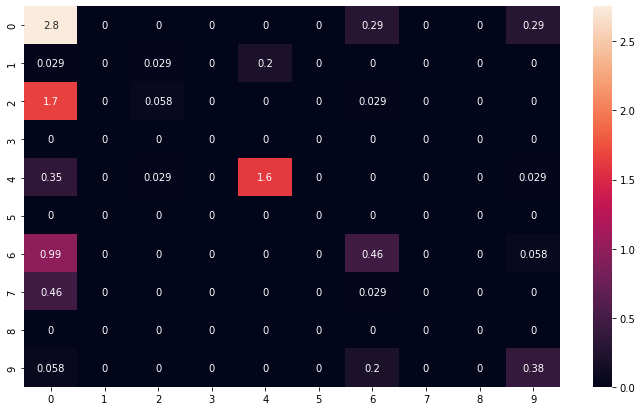

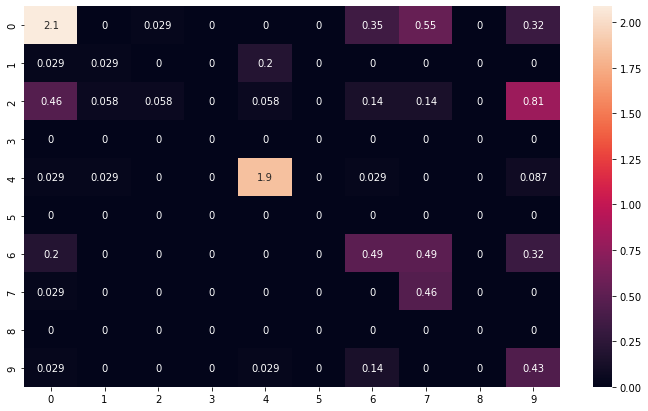

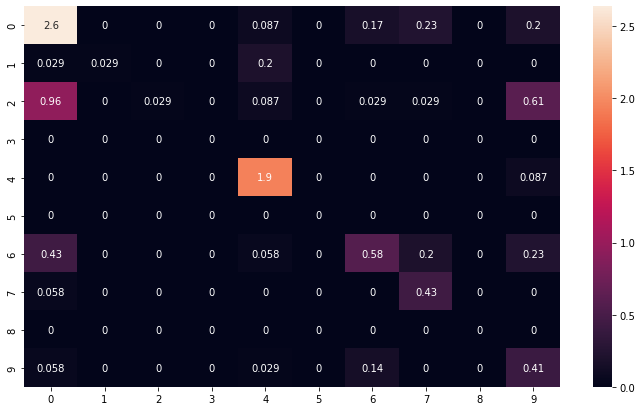

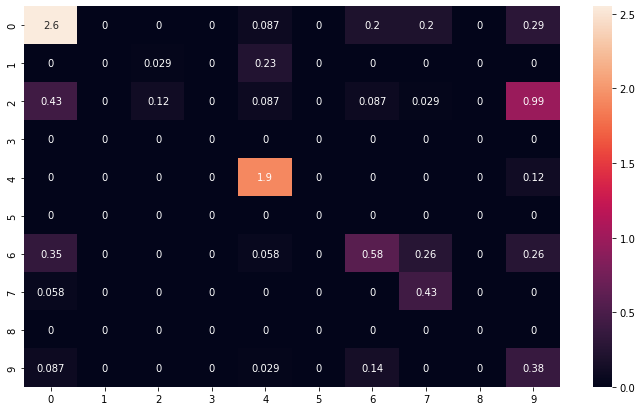

In [ ]:
lr = 0.001
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(100, model, cfg, exp, sp, optimizer, sequence)

2022-04-05 19:34:04,031 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-05 19:34:04,824 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-05 19:34:05,447 - mmaction - INFO - Start running, host: root@228e89623c4a, work_dir: /content/mmaction2/tutorial_exps
2022-04-05 19:34:05,449 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:36:03,374 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:36:03,377 - mmaction - INFO - 
top1_acc	0.5966
top2_acc	0.8235
2022-04-05 19:36:03,378 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:36:03,380 - mmaction - INFO - 
mean_acc	0.3829
2022-04-05 19:36:06,877 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-05 19:36:06,879 - mmaction - INFO - Best top1_acc is 0.5966 at 5 epoch.
2022-04-05 19:36:06,880 - mmaction - INFO - Epoch(val) [5][8]	top1_acc: 0.5966, top2_acc: 0.8235, mean_class_accuracy: 0.3829


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:38:05,344 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:38:05,346 - mmaction - INFO - 
top1_acc	0.6555
top2_acc	0.9160
2022-04-05 19:38:05,347 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:38:05,350 - mmaction - INFO - 
mean_acc	0.4976
2022-04-05 19:38:05,428 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-05 19:38:08,677 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-05 19:38:08,678 - mmaction - INFO - Best top1_acc is 0.6555 at 10 epoch.
2022-04-05 19:38:08,679 - mmaction - INFO - Epoch(val) [10][8]	top1_acc: 0.6555, top2_acc: 0.9160, mean_class_accuracy: 0.4976


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.6 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:40:07,734 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:40:07,736 - mmaction - INFO - 
top1_acc	0.7311
top2_acc	0.9076
2022-04-05 19:40:07,738 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:40:07,740 - mmaction - INFO - 
mean_acc	0.5316
2022-04-05 19:40:07,823 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-05 19:40:11,077 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-05 19:40:11,079 - mmaction - INFO - Best top1_acc is 0.7311 at 15 epoch.
2022-04-05 19:40:11,081 - mmaction - INFO - Epoch(val) [15][8]	top1_acc: 0.7311, top2_acc: 0.9076, mean_class_accuracy: 0.5316


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:42:09,878 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:42:09,880 - mmaction - INFO - 
top1_acc	0.6218
top2_acc	0.8655
2022-04-05 19:42:09,881 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:42:09,884 - mmaction - INFO - 
mean_acc	0.3468
2022-04-05 19:42:09,885 - mmaction - INFO - Epoch(val) [20][8]	top1_acc: 0.6218, top2_acc: 0.8655, mean_class_accuracy: 0.3468
2022-04-05 19:44:04,540 - mmaction - INFO - Saving checkpoint at 25 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:44:12,600 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:44:12,602 - mmaction - INFO - 
top1_acc	0.7395
top2_acc	0.8487
2022-04-05 19:44:12,603 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:44:12,605 - mmaction - INFO - 
mean_acc	0.5133
2022-04-05 19:44:12,685 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_15.pth was removed
2022-04-05 19:44:15,937 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2022-04-05 19:44:15,939 - mmaction - INFO - Best top1_acc is 0.7395 at 25 epoch.
2022-04-05 19:44:15,940 - mmaction - INFO - Epoch(val) [25][8]	top1_acc: 0.7395, top2_acc: 0.8487, mean_class_accuracy: 0.5133


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:46:14,780 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:46:14,783 - mmaction - INFO - 
top1_acc	0.6387
top2_acc	0.8067
2022-04-05 19:46:14,783 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:46:14,786 - mmaction - INFO - 
mean_acc	0.3767
2022-04-05 19:46:14,787 - mmaction - INFO - Epoch(val) [30][8]	top1_acc: 0.6387, top2_acc: 0.8067, mean_class_accuracy: 0.3767


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:48:13,670 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:48:13,673 - mmaction - INFO - 
top1_acc	0.5798
top2_acc	0.8571
2022-04-05 19:48:13,674 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:48:13,676 - mmaction - INFO - 
mean_acc	0.5341
2022-04-05 19:48:13,677 - mmaction - INFO - Epoch(val) [35][8]	top1_acc: 0.5798, top2_acc: 0.8571, mean_class_accuracy: 0.5341


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:50:12,270 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:50:12,273 - mmaction - INFO - 
top1_acc	0.6975
top2_acc	0.9244
2022-04-05 19:50:12,274 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:50:12,277 - mmaction - INFO - 
mean_acc	0.4618
2022-04-05 19:50:12,278 - mmaction - INFO - Epoch(val) [40][8]	top1_acc: 0.6975, top2_acc: 0.9244, mean_class_accuracy: 0.4618


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:52:10,246 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:52:10,249 - mmaction - INFO - 
top1_acc	0.7731
top2_acc	0.9328
2022-04-05 19:52:10,250 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:52:10,253 - mmaction - INFO - 
mean_acc	0.6582
2022-04-05 19:52:10,332 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_25.pth was removed
2022-04-05 19:52:13,501 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2022-04-05 19:52:13,503 - mmaction - INFO - Best top1_acc is 0.7731 at 45 epoch.
2022-04-05 19:52:13,504 - mmaction - INFO - Epoch(val) [45][8]	top1_acc: 0.7731, top2_acc: 0.9328, mean_class_accuracy: 0.6582
2022-04-05 19:54:07,706 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:54:15,653 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:54:15,656 - mmaction - INFO - 
top1_acc	0.8571
top2_acc	0.9412
2022-04-05 19:54:15,657 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:54:15,661 - mmaction - INFO - 
mean_acc	0.8427
2022-04-05 19:54:15,742 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_45.pth was removed
2022-04-05 19:54:18,951 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2022-04-05 19:54:18,953 - mmaction - INFO - Best top1_acc is 0.8571 at 50 epoch.
2022-04-05 19:54:18,956 - mmaction - INFO - Epoch(val) [50][8]	top1_acc: 0.8571, top2_acc: 0.9412, mean_class_accuracy: 0.8427


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:56:17,647 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:56:17,650 - mmaction - INFO - 
top1_acc	0.7899
top2_acc	0.9412
2022-04-05 19:56:17,651 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:56:17,654 - mmaction - INFO - 
mean_acc	0.8145
2022-04-05 19:56:17,655 - mmaction - INFO - Epoch(val) [55][8]	top1_acc: 0.7899, top2_acc: 0.9412, mean_class_accuracy: 0.8145


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.6 task/s, elapsed: 4s, ETA:     0s

2022-04-05 19:58:16,070 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 19:58:16,073 - mmaction - INFO - 
top1_acc	0.6807
top2_acc	0.8908
2022-04-05 19:58:16,074 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 19:58:16,076 - mmaction - INFO - 
mean_acc	0.6543
2022-04-05 19:58:16,077 - mmaction - INFO - Epoch(val) [60][8]	top1_acc: 0.6807, top2_acc: 0.8908, mean_class_accuracy: 0.6543


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:00:14,306 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:00:14,308 - mmaction - INFO - 
top1_acc	0.7983
top2_acc	0.9580
2022-04-05 20:00:14,309 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:00:14,312 - mmaction - INFO - 
mean_acc	0.6688
2022-04-05 20:00:14,313 - mmaction - INFO - Epoch(val) [65][8]	top1_acc: 0.7983, top2_acc: 0.9580, mean_class_accuracy: 0.6688


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:02:12,424 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:02:12,427 - mmaction - INFO - 
top1_acc	0.7983
top2_acc	0.9496
2022-04-05 20:02:12,428 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:02:12,430 - mmaction - INFO - 
mean_acc	0.7336
2022-04-05 20:02:12,431 - mmaction - INFO - Epoch(val) [70][8]	top1_acc: 0.7983, top2_acc: 0.9496, mean_class_accuracy: 0.7336
2022-04-05 20:04:06,958 - mmaction - INFO - Saving checkpoint at 75 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:04:16,792 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:04:16,794 - mmaction - INFO - 
top1_acc	0.8319
top2_acc	0.9496
2022-04-05 20:04:16,796 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:04:16,797 - mmaction - INFO - 
mean_acc	0.8014
2022-04-05 20:04:16,798 - mmaction - INFO - Epoch(val) [75][8]	top1_acc: 0.8319, top2_acc: 0.9496, mean_class_accuracy: 0.8014


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:06:15,095 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:06:15,097 - mmaction - INFO - 
top1_acc	0.8571
top2_acc	0.9496
2022-04-05 20:06:15,098 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:06:15,101 - mmaction - INFO - 
mean_acc	0.8290
2022-04-05 20:06:15,103 - mmaction - INFO - Epoch(val) [80][8]	top1_acc: 0.8571, top2_acc: 0.9496, mean_class_accuracy: 0.8290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:08:13,692 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:08:13,694 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:08:13,695 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:08:13,698 - mmaction - INFO - 
mean_acc	0.8182
2022-04-05 20:08:13,699 - mmaction - INFO - Epoch(val) [85][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.8182


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:10:12,536 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:10:12,539 - mmaction - INFO - 
top1_acc	0.8992
top2_acc	0.9496
2022-04-05 20:10:12,540 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:10:12,543 - mmaction - INFO - 
mean_acc	0.8472
2022-04-05 20:10:12,624 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_50.pth was removed
2022-04-05 20:10:16,055 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-05 20:10:16,056 - mmaction - INFO - Best top1_acc is 0.8992 at 90 epoch.
2022-04-05 20:10:16,057 - mmaction - INFO - Epoch(val) [90][8]	top1_acc: 0.8992, top2_acc: 0.9496, mean_class_accuracy: 0.8472


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:12:14,794 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:12:14,796 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9412
2022-04-05 20:12:14,797 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:12:14,800 - mmaction - INFO - 
mean_acc	0.7798
2022-04-05 20:12:14,801 - mmaction - INFO - Epoch(val) [95][8]	top1_acc: 0.8487, top2_acc: 0.9412, mean_class_accuracy: 0.7798
2022-04-05 20:14:09,270 - mmaction - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:14:17,071 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:14:17,073 - mmaction - INFO - 
top1_acc	0.8571
top2_acc	0.9412
2022-04-05 20:14:17,074 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:14:17,077 - mmaction - INFO - 
mean_acc	0.7947
2022-04-05 20:14:17,079 - mmaction - INFO - Epoch(val) [100][8]	top1_acc: 0.8571, top2_acc: 0.9412, mean_class_accuracy: 0.7947


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:16:15,711 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:16:15,713 - mmaction - INFO - 
top1_acc	0.8739
top2_acc	0.9328
2022-04-05 20:16:15,714 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:16:15,717 - mmaction - INFO - 
mean_acc	0.8302
2022-04-05 20:16:15,718 - mmaction - INFO - Epoch(val) [105][8]	top1_acc: 0.8739, top2_acc: 0.9328, mean_class_accuracy: 0.8302


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:18:14,220 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:18:14,222 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9496
2022-04-05 20:18:14,223 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:18:14,224 - mmaction - INFO - 
mean_acc	0.8213
2022-04-05 20:18:14,226 - mmaction - INFO - Epoch(val) [110][8]	top1_acc: 0.8655, top2_acc: 0.9496, mean_class_accuracy: 0.8213


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.9 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:20:13,101 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:20:13,103 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9496
2022-04-05 20:20:13,104 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:20:13,107 - mmaction - INFO - 
mean_acc	0.8154
2022-04-05 20:20:13,108 - mmaction - INFO - Epoch(val) [115][8]	top1_acc: 0.8655, top2_acc: 0.9496, mean_class_accuracy: 0.8154


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:22:12,456 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:22:12,458 - mmaction - INFO - 
top1_acc	0.8908
top2_acc	0.9496
2022-04-05 20:22:12,459 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:22:12,462 - mmaction - INFO - 
mean_acc	0.8402
2022-04-05 20:22:12,463 - mmaction - INFO - Epoch(val) [120][8]	top1_acc: 0.8908, top2_acc: 0.9496, mean_class_accuracy: 0.8402
2022-04-05 20:24:07,069 - mmaction - INFO - Saving checkpoint at 125 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:24:14,607 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:24:14,609 - mmaction - INFO - 
top1_acc	0.8739
top2_acc	0.9496
2022-04-05 20:24:14,610 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:24:14,613 - mmaction - INFO - 
mean_acc	0.8115
2022-04-05 20:24:14,614 - mmaction - INFO - Epoch(val) [125][8]	top1_acc: 0.8739, top2_acc: 0.9496, mean_class_accuracy: 0.8115


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.3 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:26:13,244 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:26:13,246 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9328
2022-04-05 20:26:13,247 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:26:13,250 - mmaction - INFO - 
mean_acc	0.7751
2022-04-05 20:26:13,251 - mmaction - INFO - Epoch(val) [130][8]	top1_acc: 0.8655, top2_acc: 0.9328, mean_class_accuracy: 0.7751


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:28:12,176 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:28:12,178 - mmaction - INFO - 
top1_acc	0.8739
top2_acc	0.9496
2022-04-05 20:28:12,179 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:28:12,182 - mmaction - INFO - 
mean_acc	0.8007
2022-04-05 20:28:12,183 - mmaction - INFO - Epoch(val) [135][8]	top1_acc: 0.8739, top2_acc: 0.9496, mean_class_accuracy: 0.8007


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:30:10,765 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:30:10,768 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9412
2022-04-05 20:30:10,769 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:30:10,772 - mmaction - INFO - 
mean_acc	0.7917
2022-04-05 20:30:10,773 - mmaction - INFO - Epoch(val) [140][8]	top1_acc: 0.8487, top2_acc: 0.9412, mean_class_accuracy: 0.7917


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:32:09,745 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:32:09,748 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:32:09,748 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:32:09,751 - mmaction - INFO - 
mean_acc	0.7858
2022-04-05 20:32:09,752 - mmaction - INFO - Epoch(val) [145][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.7858
2022-04-05 20:34:03,975 - mmaction - INFO - Saving checkpoint at 150 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:34:11,661 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:34:11,664 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:34:11,665 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:34:11,667 - mmaction - INFO - 
mean_acc	0.8034
2022-04-05 20:34:11,669 - mmaction - INFO - Epoch(val) [150][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.8034


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:36:10,586 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:36:10,589 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:36:10,590 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:36:10,593 - mmaction - INFO - 
mean_acc	0.7779
2022-04-05 20:36:10,594 - mmaction - INFO - Epoch(val) [155][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.7779


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.0 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:38:09,400 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:38:09,403 - mmaction - INFO - 
top1_acc	0.8571
top2_acc	0.9580
2022-04-05 20:38:09,404 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:38:09,406 - mmaction - INFO - 
mean_acc	0.7898
2022-04-05 20:38:09,407 - mmaction - INFO - Epoch(val) [160][8]	top1_acc: 0.8571, top2_acc: 0.9580, mean_class_accuracy: 0.7898


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.5 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:40:07,941 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:40:07,944 - mmaction - INFO - 
top1_acc	0.8908
top2_acc	0.9496
2022-04-05 20:40:07,944 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:40:07,946 - mmaction - INFO - 
mean_acc	0.8176
2022-04-05 20:40:07,948 - mmaction - INFO - Epoch(val) [165][8]	top1_acc: 0.8908, top2_acc: 0.9496, mean_class_accuracy: 0.8176


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 28.6 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:42:07,039 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:42:07,041 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9496
2022-04-05 20:42:07,042 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:42:07,045 - mmaction - INFO - 
mean_acc	0.7945
2022-04-05 20:42:07,046 - mmaction - INFO - Epoch(val) [170][8]	top1_acc: 0.8403, top2_acc: 0.9496, mean_class_accuracy: 0.7945
2022-04-05 20:44:01,491 - mmaction - INFO - Saving checkpoint at 175 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.4 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:44:09,252 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:44:09,255 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9412
2022-04-05 20:44:09,256 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:44:09,258 - mmaction - INFO - 
mean_acc	0.7798
2022-04-05 20:44:09,259 - mmaction - INFO - Epoch(val) [175][8]	top1_acc: 0.8403, top2_acc: 0.9412, mean_class_accuracy: 0.7798


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.8 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:46:08,222 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:46:08,225 - mmaction - INFO - 
top1_acc	0.8403
top2_acc	0.9412
2022-04-05 20:46:08,226 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:46:08,229 - mmaction - INFO - 
mean_acc	0.7483
2022-04-05 20:46:08,230 - mmaction - INFO - Epoch(val) [180][8]	top1_acc: 0.8403, top2_acc: 0.9412, mean_class_accuracy: 0.7483


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:48:07,160 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:48:07,162 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:48:07,163 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:48:07,166 - mmaction - INFO - 
mean_acc	0.7828
2022-04-05 20:48:07,167 - mmaction - INFO - Epoch(val) [185][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.7828


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.1 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:50:05,862 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:50:05,864 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9496
2022-04-05 20:50:05,865 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:50:05,868 - mmaction - INFO - 
mean_acc	0.7771
2022-04-05 20:50:05,869 - mmaction - INFO - Epoch(val) [190][8]	top1_acc: 0.8655, top2_acc: 0.9496, mean_class_accuracy: 0.7771


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 29.2 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:52:04,114 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:52:04,116 - mmaction - INFO - 
top1_acc	0.8487
top2_acc	0.9496
2022-04-05 20:52:04,117 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:52:04,119 - mmaction - INFO - 
mean_acc	0.7769
2022-04-05 20:52:04,120 - mmaction - INFO - Epoch(val) [195][8]	top1_acc: 0.8487, top2_acc: 0.9496, mean_class_accuracy: 0.7769
2022-04-05 20:53:58,837 - mmaction - INFO - Saving checkpoint at 200 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 27.7 task/s, elapsed: 4s, ETA:     0s

2022-04-05 20:54:06,507 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-05 20:54:06,509 - mmaction - INFO - 
top1_acc	0.8655
top2_acc	0.9412
2022-04-05 20:54:06,510 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-05 20:54:06,512 - mmaction - INFO - 
mean_acc	0.7722
2022-04-05 20:54:06,513 - mmaction - INFO - Epoch(val) [200][8]	top1_acc: 0.8655, top2_acc: 0.9412, mean_class_accuracy: 0.7722


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 197s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4957
top2_acc	0.6580

Evaluating mean_class_accuracy ...

mean_acc	0.3449
0: 233
1: 0
2: 11
3: 0
4: 50
5: 0
6: 8
7: 0
8: 0
9: 43
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5681
top2_acc	0.7246

Evaluating mean_class_accuracy ...

mean_acc	0.4498
0: 140
1: 3
2: 7
3: 0
4: 78
5: 0
6: 74
7: 33
8: 0
9: 10
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 197s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5768
top2_acc	0.7217

Evaluating mean_class_accuracy ...

mean_acc	0.4725
0: 182
1: 14
2: 10
3: 0
4: 79
5: 0
6: 39
7: 14
8: 0
9: 7
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 345/345, 1.8 task/s, elapsed: 196s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.6087
top2_acc	0.7507

Evaluating mean_class_accuracy ...

mean_acc	0.5352
0: 166
1: 1
2: 9
3: 0
4: 77
5: 0
6: 29
7: 30
8: 

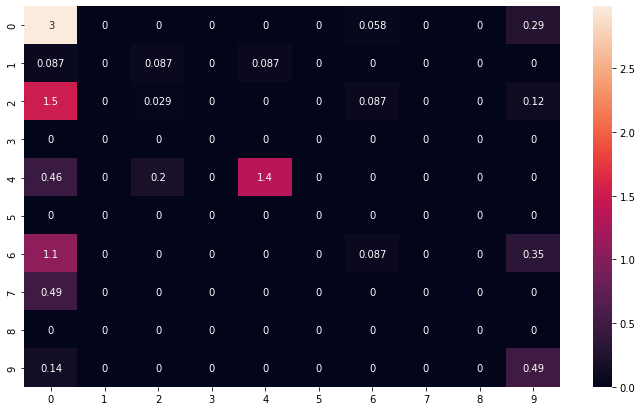

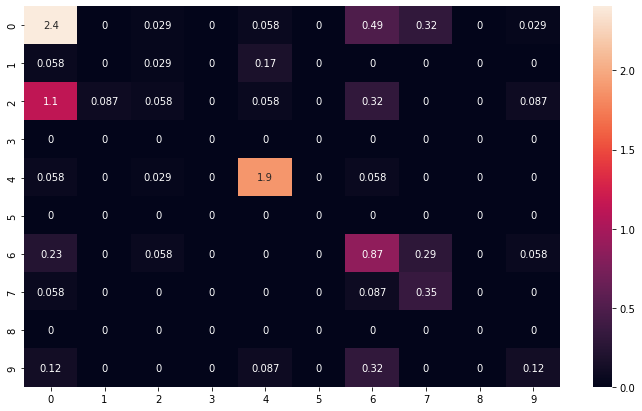

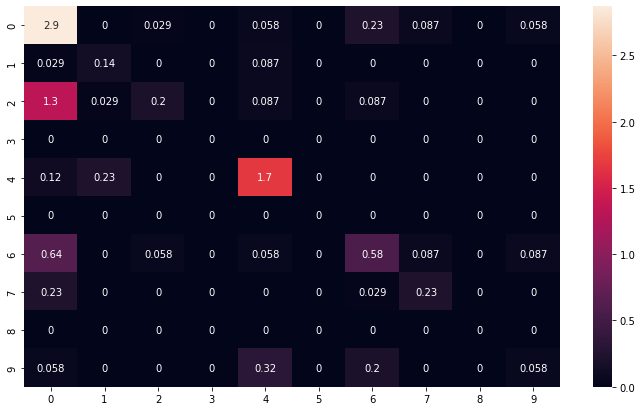

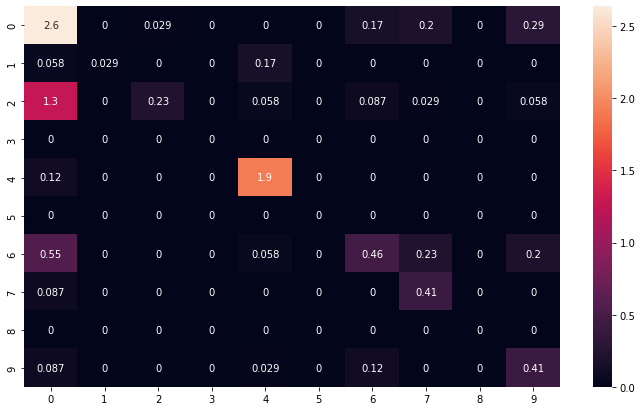

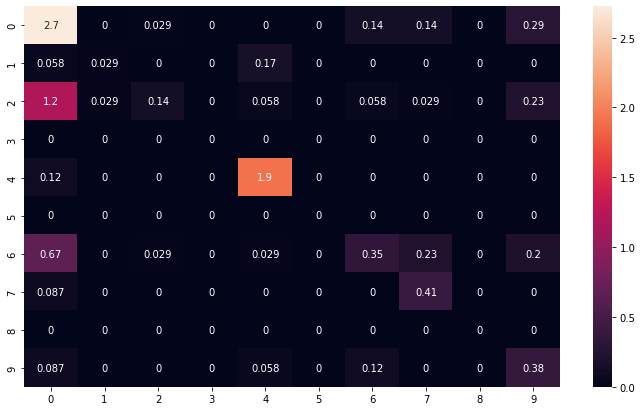

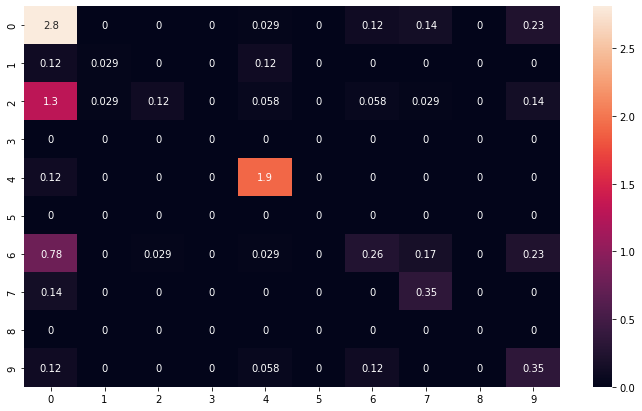

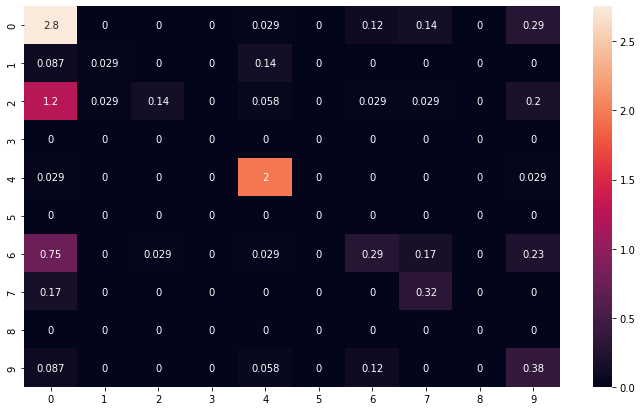

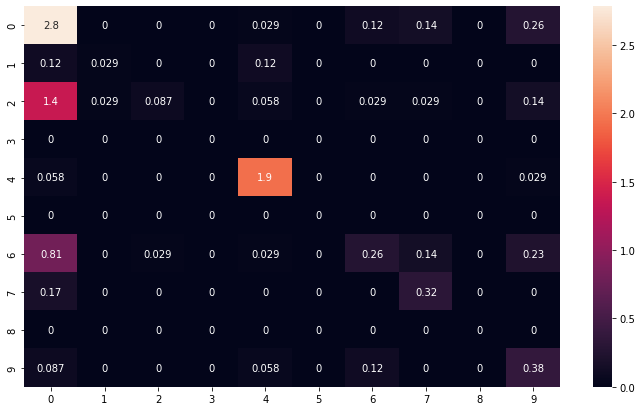

In [ ]:
sp=3
lr = 0.01
epoch=200
# train model
cfg, model = train_by_epochs(exp, epoch, sp, optimizer, sequence)
tests_by_epochs(200, model, cfg, exp, sp, optimizer, sequence)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi
%cd /content/mmaction2
exp = 1
sp = 0
epoch = 100
lr = 0.0001
optimizer = 'Adam'
check_data(1, 0)

torch.cuda.empty_cache()
# configuration
cfg = exp1_config(split=sp, epoch=epoch, lr=lr, optimizer=optimizer)
# remove train log
!rm /content/mmaction2/tutorial_exps/None.log.json
# train model
model = train(cfg)
# train plot
!python tools/analysis/analyze_logs.py plot_curve /content/mmaction2/tutorial_exps/None.log.json \
--keys top1_acc top5_acc --legend top1_acc top5_acc --out /content/exp1_sp0_acc_epoch100_lr-4_adam.pdf
# files.download('/content/sp'+str(sp)+'_acc.pdf')

Mon Apr  4 09:15:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    54W / 300W |   5317MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2022-04-04 09:15:53,858 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-04 09:15:54,966 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-04 09:15:55,618 - mmaction - INFO - Start running, host: root@26ff67c80bde, work_dir: /content/mmaction2/tutorial_exps
2022-04-04 09:15:55,620 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.4 task/s, elapsed: 17s, ETA:     0s

2022-04-04 09:24:10,675 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 09:24:10,679 - mmaction - INFO - 
top1_acc	0.6965
top2_acc	0.8292
2022-04-04 09:24:10,680 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 09:24:10,683 - mmaction - INFO - 
mean_acc	0.6383
2022-04-04 09:24:15,799 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-04 09:24:15,800 - mmaction - INFO - Best top1_acc is 0.6965 at 5 epoch.
2022-04-04 09:24:15,801 - mmaction - INFO - Epoch(val) [5][38]	top1_acc: 0.6965, top2_acc: 0.8292, mean_class_accuracy: 0.6383
2022-04-04 09:24:23,698 - mmaction - INFO - Epoch [6][5/112]	lr: 1.000e-04, eta: 2:27:20, time: 1.577, data_time: 0.769, memory: 13409, loss_aux: 0.6345, top1_acc: 0.5750, top5_acc: 0.9000, loss_cls: 1.2715, loss: 1.9060, grad_norm: 11.1295
2022-04-04 09:24:27,753 - mmaction - INFO - Epoch [6][10/112]	lr: 1.000e-04, eta: 2:27:14, time: 0.811, data_time: 0.002, memory: 13409, loss_aux: 0.5365, top

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 37.0 task/s, elapsed: 16s, ETA:     0s

2022-04-04 09:32:29,478 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 09:32:29,482 - mmaction - INFO - 
top1_acc	0.7728
top2_acc	0.9038
2022-04-04 09:32:29,483 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 09:32:29,485 - mmaction - INFO - 
mean_acc	0.7053
2022-04-04 09:32:29,624 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-04 09:32:34,819 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-04 09:32:34,820 - mmaction - INFO - Best top1_acc is 0.7728 at 10 epoch.
2022-04-04 09:32:34,822 - mmaction - INFO - Epoch(val) [10][38]	top1_acc: 0.7728, top2_acc: 0.9038, mean_class_accuracy: 0.7053
2022-04-04 09:32:42,666 - mmaction - INFO - Epoch [11][5/112]	lr: 1.000e-04, eta: 2:18:54, time: 1.567, data_time: 0.767, memory: 13409, loss_aux: 0.3722, top1_acc: 0.7875, top5_acc: 0.9750, loss_cls: 0.6323, loss: 1.0045, grad_norm: 7.1001
2022-04-04 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.7 task/s, elapsed: 16s, ETA:     0s

2022-04-04 09:40:47,198 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 09:40:47,201 - mmaction - INFO - 
top1_acc	0.7927
top2_acc	0.9071
2022-04-04 09:40:47,202 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 09:40:47,204 - mmaction - INFO - 
mean_acc	0.7105
2022-04-04 09:40:47,346 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-04 09:40:52,430 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2022-04-04 09:40:52,432 - mmaction - INFO - Best top1_acc is 0.7927 at 15 epoch.
2022-04-04 09:40:52,433 - mmaction - INFO - Epoch(val) [15][38]	top1_acc: 0.7927, top2_acc: 0.9071, mean_class_accuracy: 0.7105
2022-04-04 09:41:00,402 - mmaction - INFO - Epoch [16][5/112]	lr: 1.000e-04, eta: 2:11:00, time: 1.583, data_time: 0.783, memory: 13409, loss_aux: 0.3922, top1_acc: 0.7625, top5_acc: 0.9500, loss_cls: 0.7360, loss: 1.1283, grad_norm: 9.1110
2022-04-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.8 task/s, elapsed: 16s, ETA:     0s

2022-04-04 09:49:04,465 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 09:49:04,467 - mmaction - INFO - 
top1_acc	0.7861
top2_acc	0.9071
2022-04-04 09:49:04,468 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 09:49:04,472 - mmaction - INFO - 
mean_acc	0.7115
2022-04-04 09:49:04,473 - mmaction - INFO - Epoch(val) [20][38]	top1_acc: 0.7861, top2_acc: 0.9071, mean_class_accuracy: 0.7115
2022-04-04 09:49:12,420 - mmaction - INFO - Epoch [21][5/112]	lr: 1.000e-04, eta: 2:03:11, time: 1.584, data_time: 0.779, memory: 13409, loss_aux: 0.3880, top1_acc: 0.7000, top5_acc: 0.9625, loss_cls: 0.6990, loss: 1.0869, grad_norm: 7.9293
2022-04-04 09:49:16,408 - mmaction - INFO - Epoch [21][10/112]	lr: 1.000e-04, eta: 2:03:07, time: 0.801, data_time: 0.005, memory: 13409, loss_aux: 0.3376, top1_acc: 0.7625, top5_acc: 0.9750, loss_cls: 0.6060, loss: 0.9435, grad_norm: 7.4657
2022-04-04 09:49:20,420 - mmaction - INFO - Epoch [21][15/112]	lr: 1.000e-04, eta: 2:03:02, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.3 task/s, elapsed: 17s, ETA:     0s

2022-04-04 09:57:19,540 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 09:57:19,544 - mmaction - INFO - 
top1_acc	0.8126
top2_acc	0.9353
2022-04-04 09:57:19,545 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 09:57:19,548 - mmaction - INFO - 
mean_acc	0.7207
2022-04-04 09:57:19,683 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_15.pth was removed
2022-04-04 09:57:24,802 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2022-04-04 09:57:24,803 - mmaction - INFO - Best top1_acc is 0.8126 at 25 epoch.
2022-04-04 09:57:24,804 - mmaction - INFO - Epoch(val) [25][38]	top1_acc: 0.8126, top2_acc: 0.9353, mean_class_accuracy: 0.7207
2022-04-04 09:57:32,687 - mmaction - INFO - Epoch [26][5/112]	lr: 1.000e-04, eta: 1:55:27, time: 1.574, data_time: 0.771, memory: 13409, loss_aux: 0.2581, top1_acc: 0.8625, top5_acc: 1.0000, loss_cls: 0.4360, loss: 0.6941, grad_norm: 5.7485
2022-04-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.2 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:05:39,874 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:05:39,877 - mmaction - INFO - 
top1_acc	0.8308
top2_acc	0.9138
2022-04-04 10:05:39,878 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:05:39,881 - mmaction - INFO - 
mean_acc	0.7514
2022-04-04 10:05:40,023 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_25.pth was removed
2022-04-04 10:05:45,127 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2022-04-04 10:05:45,128 - mmaction - INFO - Best top1_acc is 0.8308 at 30 epoch.
2022-04-04 10:05:45,129 - mmaction - INFO - Epoch(val) [30][38]	top1_acc: 0.8308, top2_acc: 0.9138, mean_class_accuracy: 0.7514
2022-04-04 10:05:53,288 - mmaction - INFO - Epoch [31][5/112]	lr: 1.000e-04, eta: 1:47:45, time: 1.630, data_time: 0.827, memory: 13409, loss_aux: 0.2495, top1_acc: 0.8375, top5_acc: 0.9750, loss_cls: 0.4622, loss: 0.7117, grad_norm: 6.7885
2022-04-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.6 task/s, elapsed: 16s, ETA:     0s

2022-04-04 10:13:59,818 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:13:59,821 - mmaction - INFO - 
top1_acc	0.8076
top2_acc	0.9386
2022-04-04 10:13:59,822 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:13:59,825 - mmaction - INFO - 
mean_acc	0.7386
2022-04-04 10:13:59,827 - mmaction - INFO - Epoch(val) [35][38]	top1_acc: 0.8076, top2_acc: 0.9386, mean_class_accuracy: 0.7386
2022-04-04 10:14:07,722 - mmaction - INFO - Epoch [36][5/112]	lr: 1.000e-04, eta: 1:40:02, time: 1.576, data_time: 0.766, memory: 13409, loss_aux: 0.3143, top1_acc: 0.7875, top5_acc: 0.9625, loss_cls: 0.5635, loss: 0.8777, grad_norm: 6.2390
2022-04-04 10:14:11,751 - mmaction - INFO - Epoch [36][10/112]	lr: 1.000e-04, eta: 1:39:57, time: 0.806, data_time: 0.007, memory: 13409, loss_aux: 0.2257, top1_acc: 0.8250, top5_acc: 0.9625, loss_cls: 0.4516, loss: 0.6774, grad_norm: 6.0363
2022-04-04 10:14:15,748 - mmaction - INFO - Epoch [36][15/112]	lr: 1.000e-04, eta: 1:39:53, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.1 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:22:14,239 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:22:14,242 - mmaction - INFO - 
top1_acc	0.8043
top2_acc	0.9204
2022-04-04 10:22:14,243 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:22:14,246 - mmaction - INFO - 
mean_acc	0.7567
2022-04-04 10:22:14,247 - mmaction - INFO - Epoch(val) [40][38]	top1_acc: 0.8043, top2_acc: 0.9204, mean_class_accuracy: 0.7567
2022-04-04 10:22:22,220 - mmaction - INFO - Epoch [41][5/112]	lr: 1.000e-04, eta: 1:32:19, time: 1.591, data_time: 0.784, memory: 13409, loss_aux: 0.3107, top1_acc: 0.7625, top5_acc: 0.9750, loss_cls: 0.5615, loss: 0.8722, grad_norm: 6.8784
2022-04-04 10:22:26,211 - mmaction - INFO - Epoch [41][10/112]	lr: 1.000e-04, eta: 1:32:14, time: 0.800, data_time: 0.004, memory: 13409, loss_aux: 0.2751, top1_acc: 0.7875, top5_acc: 0.9875, loss_cls: 0.5955, loss: 0.8706, grad_norm: 9.1778
2022-04-04 10:22:30,212 - mmaction - INFO - Epoch [41][15/112]	lr: 1.000e-04, eta: 1:32:10, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.3 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:30:28,456 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:30:28,459 - mmaction - INFO - 
top1_acc	0.8159
top2_acc	0.9171
2022-04-04 10:30:28,460 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:30:28,463 - mmaction - INFO - 
mean_acc	0.7346
2022-04-04 10:30:28,464 - mmaction - INFO - Epoch(val) [45][38]	top1_acc: 0.8159, top2_acc: 0.9171, mean_class_accuracy: 0.7346
2022-04-04 10:30:36,390 - mmaction - INFO - Epoch [46][5/112]	lr: 1.000e-04, eta: 1:24:35, time: 1.582, data_time: 0.778, memory: 13409, loss_aux: 0.3500, top1_acc: 0.7375, top5_acc: 0.9625, loss_cls: 0.6623, loss: 1.0123, grad_norm: 8.0784
2022-04-04 10:30:40,416 - mmaction - INFO - Epoch [46][10/112]	lr: 1.000e-04, eta: 1:24:31, time: 0.807, data_time: 0.004, memory: 13409, loss_aux: 0.2861, top1_acc: 0.8000, top5_acc: 0.9750, loss_cls: 0.5391, loss: 0.8252, grad_norm: 6.9629
2022-04-04 10:30:44,446 - mmaction - INFO - Epoch [46][15/112]	lr: 1.000e-04, eta: 1:24:27, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.3 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:38:42,339 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:38:42,342 - mmaction - INFO - 
top1_acc	0.8010
top2_acc	0.9104
2022-04-04 10:38:42,343 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:38:42,346 - mmaction - INFO - 
mean_acc	0.7440
2022-04-04 10:38:42,349 - mmaction - INFO - Epoch(val) [50][38]	top1_acc: 0.8010, top2_acc: 0.9104, mean_class_accuracy: 0.7440
2022-04-04 10:38:50,331 - mmaction - INFO - Epoch [51][5/112]	lr: 1.000e-04, eta: 1:16:54, time: 1.593, data_time: 0.785, memory: 13409, loss_aux: 0.2175, top1_acc: 0.8250, top5_acc: 0.9875, loss_cls: 0.4219, loss: 0.6394, grad_norm: 6.1654
2022-04-04 10:38:54,352 - mmaction - INFO - Epoch [51][10/112]	lr: 1.000e-04, eta: 1:16:50, time: 0.806, data_time: 0.004, memory: 13409, loss_aux: 0.2557, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.4399, loss: 0.6956, grad_norm: 7.0443
2022-04-04 10:38:58,361 - mmaction - INFO - Epoch [51][15/112]	lr: 1.000e-04, eta: 1:16:46, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.0 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:46:57,811 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:46:57,814 - mmaction - INFO - 
top1_acc	0.8010
top2_acc	0.9254
2022-04-04 10:46:57,816 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:46:57,819 - mmaction - INFO - 
mean_acc	0.7495
2022-04-04 10:46:57,820 - mmaction - INFO - Epoch(val) [55][38]	top1_acc: 0.8010, top2_acc: 0.9254, mean_class_accuracy: 0.7495
2022-04-04 10:47:05,652 - mmaction - INFO - Epoch [56][5/112]	lr: 1.000e-04, eta: 1:09:12, time: 1.561, data_time: 0.749, memory: 13409, loss_aux: 0.3691, top1_acc: 0.7500, top5_acc: 0.9750, loss_cls: 0.7007, loss: 1.0698, grad_norm: 8.0968
2022-04-04 10:47:09,653 - mmaction - INFO - Epoch [56][10/112]	lr: 1.000e-04, eta: 1:09:08, time: 0.803, data_time: 0.005, memory: 13409, loss_aux: 0.3120, top1_acc: 0.8000, top5_acc: 0.9875, loss_cls: 0.5179, loss: 0.8299, grad_norm: 6.5565
2022-04-04 10:47:13,689 - mmaction - INFO - Epoch [56][15/112]	lr: 1.000e-04, eta: 1:09:04, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.3 task/s, elapsed: 17s, ETA:     0s

2022-04-04 10:55:11,121 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 10:55:11,125 - mmaction - INFO - 
top1_acc	0.8192
top2_acc	0.9088
2022-04-04 10:55:11,126 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 10:55:11,129 - mmaction - INFO - 
mean_acc	0.7326
2022-04-04 10:55:11,130 - mmaction - INFO - Epoch(val) [60][38]	top1_acc: 0.8192, top2_acc: 0.9088, mean_class_accuracy: 0.7326
2022-04-04 10:55:19,044 - mmaction - INFO - Epoch [61][5/112]	lr: 1.000e-04, eta: 1:01:31, time: 1.580, data_time: 0.769, memory: 13409, loss_aux: 0.2265, top1_acc: 0.8125, top5_acc: 0.9750, loss_cls: 0.4354, loss: 0.6619, grad_norm: 5.8122
2022-04-04 10:55:23,044 - mmaction - INFO - Epoch [61][10/112]	lr: 1.000e-04, eta: 1:01:26, time: 0.801, data_time: 0.003, memory: 13409, loss_aux: 0.2235, top1_acc: 0.8125, top5_acc: 1.0000, loss_cls: 0.4491, loss: 0.6726, grad_norm: 6.1816
2022-04-04 10:55:27,051 - mmaction - INFO - Epoch [61][15/112]	lr: 1.000e-04, eta: 1:01:22, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 35.8 task/s, elapsed: 17s, ETA:     0s

2022-04-04 11:03:24,745 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:03:24,749 - mmaction - INFO - 
top1_acc	0.8010
top2_acc	0.9171
2022-04-04 11:03:24,750 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:03:24,754 - mmaction - INFO - 
mean_acc	0.7547
2022-04-04 11:03:24,755 - mmaction - INFO - Epoch(val) [65][38]	top1_acc: 0.8010, top2_acc: 0.9171, mean_class_accuracy: 0.7547
2022-04-04 11:03:32,712 - mmaction - INFO - Epoch [66][5/112]	lr: 1.000e-04, eta: 0:53:49, time: 1.588, data_time: 0.780, memory: 13409, loss_aux: 0.2532, top1_acc: 0.8375, top5_acc: 0.9625, loss_cls: 0.4840, loss: 0.7372, grad_norm: 8.8689
2022-04-04 11:03:36,737 - mmaction - INFO - Epoch [66][10/112]	lr: 1.000e-04, eta: 0:53:45, time: 0.807, data_time: 0.003, memory: 13409, loss_aux: 0.2234, top1_acc: 0.8375, top5_acc: 0.9750, loss_cls: 0.4184, loss: 0.6418, grad_norm: 6.1408
2022-04-04 11:03:40,747 - mmaction - INFO - Epoch [66][15/112]	lr: 1.000e-04, eta: 0:53:41, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.6 task/s, elapsed: 16s, ETA:     0s

2022-04-04 11:11:39,323 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:11:39,327 - mmaction - INFO - 
top1_acc	0.8093
top2_acc	0.9303
2022-04-04 11:11:39,328 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:11:39,332 - mmaction - INFO - 
mean_acc	0.7771
2022-04-04 11:11:39,333 - mmaction - INFO - Epoch(val) [70][38]	top1_acc: 0.8093, top2_acc: 0.9303, mean_class_accuracy: 0.7771
2022-04-04 11:11:47,247 - mmaction - INFO - Epoch [71][5/112]	lr: 1.000e-04, eta: 0:46:07, time: 1.581, data_time: 0.779, memory: 13409, loss_aux: 0.2933, top1_acc: 0.8125, top5_acc: 0.9750, loss_cls: 0.5582, loss: 0.8515, grad_norm: 5.8711
2022-04-04 11:11:51,257 - mmaction - INFO - Epoch [71][10/112]	lr: 1.000e-04, eta: 0:46:03, time: 0.802, data_time: 0.002, memory: 13409, loss_aux: 0.1896, top1_acc: 0.8625, top5_acc: 1.0000, loss_cls: 0.3520, loss: 0.5416, grad_norm: 5.3333
2022-04-04 11:11:55,262 - mmaction - INFO - Epoch [71][15/112]	lr: 1.000e-04, eta: 0:45:58, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.8 task/s, elapsed: 16s, ETA:     0s

2022-04-04 11:19:54,086 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:19:54,089 - mmaction - INFO - 
top1_acc	0.8027
top2_acc	0.9154
2022-04-04 11:19:54,090 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:19:54,094 - mmaction - INFO - 
mean_acc	0.7400
2022-04-04 11:19:54,095 - mmaction - INFO - Epoch(val) [75][38]	top1_acc: 0.8027, top2_acc: 0.9154, mean_class_accuracy: 0.7400
2022-04-04 11:20:02,018 - mmaction - INFO - Epoch [76][5/112]	lr: 1.000e-05, eta: 0:38:25, time: 1.579, data_time: 0.771, memory: 13409, loss_aux: 0.1441, top1_acc: 0.9375, top5_acc: 1.0000, loss_cls: 0.2433, loss: 0.3873, grad_norm: 3.9398
2022-04-04 11:20:06,034 - mmaction - INFO - Epoch [76][10/112]	lr: 1.000e-05, eta: 0:38:21, time: 0.807, data_time: 0.006, memory: 13409, loss_aux: 0.2176, top1_acc: 0.8625, top5_acc: 0.9875, loss_cls: 0.4358, loss: 0.6535, grad_norm: 5.6439
2022-04-04 11:20:10,050 - mmaction - INFO - Epoch [76][15/112]	lr: 1.000e-05, eta: 0:38:17, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 35.8 task/s, elapsed: 17s, ETA:     0s

2022-04-04 11:28:09,144 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:28:09,147 - mmaction - INFO - 
top1_acc	0.8242
top2_acc	0.9370
2022-04-04 11:28:09,149 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:28:09,152 - mmaction - INFO - 
mean_acc	0.7572
2022-04-04 11:28:09,153 - mmaction - INFO - Epoch(val) [80][38]	top1_acc: 0.8242, top2_acc: 0.9370, mean_class_accuracy: 0.7572
2022-04-04 11:28:17,060 - mmaction - INFO - Epoch [81][5/112]	lr: 1.000e-05, eta: 0:30:43, time: 1.578, data_time: 0.767, memory: 13409, loss_aux: 0.1641, top1_acc: 0.8875, top5_acc: 0.9875, loss_cls: 0.3167, loss: 0.4807, grad_norm: 4.5062
2022-04-04 11:28:21,058 - mmaction - INFO - Epoch [81][10/112]	lr: 1.000e-05, eta: 0:30:39, time: 0.801, data_time: 0.004, memory: 13409, loss_aux: 0.2134, top1_acc: 0.8500, top5_acc: 0.9875, loss_cls: 0.4108, loss: 0.6242, grad_norm: 6.2894
2022-04-04 11:28:25,093 - mmaction - INFO - Epoch [81][15/112]	lr: 1.000e-05, eta: 0:30:35, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.0 task/s, elapsed: 17s, ETA:     0s

2022-04-04 11:36:22,607 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:36:22,610 - mmaction - INFO - 
top1_acc	0.8159
top2_acc	0.9320
2022-04-04 11:36:22,611 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:36:22,615 - mmaction - INFO - 
mean_acc	0.7460
2022-04-04 11:36:22,616 - mmaction - INFO - Epoch(val) [85][38]	top1_acc: 0.8159, top2_acc: 0.9320, mean_class_accuracy: 0.7460
2022-04-04 11:36:30,603 - mmaction - INFO - Epoch [86][5/112]	lr: 1.000e-05, eta: 0:23:01, time: 1.596, data_time: 0.791, memory: 13409, loss_aux: 0.1177, top1_acc: 0.9000, top5_acc: 0.9875, loss_cls: 0.2200, loss: 0.3377, grad_norm: 4.2498
2022-04-04 11:36:34,624 - mmaction - INFO - Epoch [86][10/112]	lr: 1.000e-05, eta: 0:22:57, time: 0.803, data_time: 0.002, memory: 13409, loss_aux: 0.1769, top1_acc: 0.8875, top5_acc: 0.9875, loss_cls: 0.3346, loss: 0.5115, grad_norm: 4.3867
2022-04-04 11:36:38,659 - mmaction - INFO - Epoch [86][15/112]	lr: 1.000e-05, eta: 0:22:53, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 35.5 task/s, elapsed: 17s, ETA:     0s

2022-04-04 11:44:36,081 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:44:36,085 - mmaction - INFO - 
top1_acc	0.8342
top2_acc	0.9386
2022-04-04 11:44:36,086 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:44:36,089 - mmaction - INFO - 
mean_acc	0.7620
2022-04-04 11:44:36,233 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_30.pth was removed
2022-04-04 11:44:41,494 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_90.pth.
2022-04-04 11:44:41,496 - mmaction - INFO - Best top1_acc is 0.8342 at 90 epoch.
2022-04-04 11:44:41,497 - mmaction - INFO - Epoch(val) [90][38]	top1_acc: 0.8342, top2_acc: 0.9386, mean_class_accuracy: 0.7620
2022-04-04 11:44:49,487 - mmaction - INFO - Epoch [91][5/112]	lr: 1.000e-05, eta: 0:15:19, time: 1.596, data_time: 0.786, memory: 13409, loss_aux: 0.2594, top1_acc: 0.8375, top5_acc: 0.9500, loss_cls: 0.4702, loss: 0.7297, grad_norm: 7.1682
2022-04-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 36.0 task/s, elapsed: 17s, ETA:     0s

2022-04-04 11:52:56,495 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 11:52:56,498 - mmaction - INFO - 
top1_acc	0.8242
top2_acc	0.9370
2022-04-04 11:52:56,499 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 11:52:56,503 - mmaction - INFO - 
mean_acc	0.7527
2022-04-04 11:52:56,504 - mmaction - INFO - Epoch(val) [95][38]	top1_acc: 0.8242, top2_acc: 0.9370, mean_class_accuracy: 0.7527
2022-04-04 11:53:04,424 - mmaction - INFO - Epoch [96][5/112]	lr: 1.000e-05, eta: 0:07:37, time: 1.580, data_time: 0.777, memory: 13409, loss_aux: 0.1702, top1_acc: 0.8875, top5_acc: 0.9875, loss_cls: 0.2811, loss: 0.4512, grad_norm: 5.7641
2022-04-04 11:53:08,442 - mmaction - INFO - Epoch [96][10/112]	lr: 1.000e-05, eta: 0:07:33, time: 0.804, data_time: 0.004, memory: 13409, loss_aux: 0.1909, top1_acc: 0.8375, top5_acc: 0.9875, loss_cls: 0.4188, loss: 0.6097, grad_norm: 5.3230
2022-04-04 11:53:12,463 - mmaction - INFO - Epoch [96][15/112]	lr: 1.000e-05, eta: 0:07:29, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 603/603, 35.9 task/s, elapsed: 17s, ETA:     0s

2022-04-04 12:01:11,897 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-04 12:01:11,901 - mmaction - INFO - 
top1_acc	0.8292
top2_acc	0.9303
2022-04-04 12:01:11,902 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-04 12:01:11,905 - mmaction - INFO - 
mean_acc	0.7526
2022-04-04 12:01:11,906 - mmaction - INFO - Epoch(val) [100][38]	top1_acc: 0.8292, top2_acc: 0.9303, mean_class_accuracy: 0.7526


plot curve of /content/mmaction2/tutorial_exps/None.log.json, metric is top1_acc
plot curve of /content/mmaction2/tutorial_exps/None.log.json, metric is top5_acc
save curve to: /content/exp1_sp0_acc_epoch100_lr-4_adam.pdf


In [ ]:
tests_by_epochs(100, model, cfg, exp, sp, optimizer)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 602/602, 1.7 task/s, elapsed: 347s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8040
top2_acc	0.9203

Evaluating mean_class_accuracy ...

mean_acc	0.7184
0: 110
1: 28
2: 84
3: 77
4: 113
5: 73
6: 80
7: 0
8: 15
9: 22
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 602/602, 1.7 task/s, elapsed: 346s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8306
top2_acc	0.9203

Evaluating mean_class_accuracy ...

mean_acc	0.7990
0: 100
1: 31
2: 90
3: 79
4: 109
5: 74
6: 62
7: 4
8: 22
9: 31
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 602/602, 1.7 task/s, elapsed: 346s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8156
top2_acc	0.9219

Evaluating mean_class_accuracy ...

mean_acc	0.7918
0: 85
1: 30
2: 98
3: 75
4: 112
5: 69
6: 67
7: 4
8: 23
9: 39
[>>>>>>>>>>>>>>>>>>>          ] 408/602, 1.7 task/s, elapsed: 235s, ETA:   112s

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi
%cd /content/mmaction2
exp = 1
sp = 0
epoch = 100
lr = 0.01
optimizer = 'Adam'
check_data(1, 0)

torch.cuda.empty_cache()
# configuration
cfg = exp1_config(split=sp, epoch=epoch, lr=lr, optimizer=optimizer)
# remove train log
!rm /content/mmaction2/tutorial_exps/None.log.json
# train model
model = train(cfg)
# train plot
!python tools/analysis/analyze_logs.py plot_curve /content/mmaction2/tutorial_exps/None.log.json \
--keys top1_acc top5_acc --legend top1_acc top5_acc --out /content/exp1_sp0_acc_epoch100_lr-4_adam.pdf
# files.download('/content/sp'+str(sp)+'_acc.pdf')

In [ ]:
tests_by_epochs(100, model, cfg, exp, sp, optimizer)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

exp = 2
sp = 1
epoch = 100
lr = 0.01
check_data(1, 1)

Sat Apr  2 23:16:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    51W / 300W |   1889MiB / 16160MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[573, 171, 292, 393, 521, 384, 359, 53, 119, 132]

In [ ]:
torch.cuda.empty_cache()
# configuration
cfg = exp2_config(split=sp, epoch=epoch, lr=lr)
# remove train log
!rm /content/mmaction2/tutorial_exps/None.log.json
# train model
model = train(cfg)
# train plot
!python tools/analysis/analyze_logs.py plot_curve /content/mmaction2/tutorial_exps/None.log.json \
--keys top1_acc top5_acc --legend top1_acc top5_acc --out /content/sp4_acc_epoch200_lr-4.pdf
# files.download('/content/sp'+str(sp)+'_acc.pdf')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowOnly',
        depth=50,
        pretrained='torchvision://resnet50',
        lateral=False,
        out_indices=(2, 3),
        conv1_kernel=(1, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(0, 0, 1, 1),
        norm_eval=False),
    neck=dict(
        type='TPN',
        in_channels=(1024, 2048),
        out_channels=1024,
        spatial_modulation_cfg=dict(
            in_channels=(1024, 2048), out_channels=2048),
        temporal_modulation_cfg=dict(downsample_scales=(8, 8)),
        upsample_cfg=dict(scale_factor=(1, 1, 1)),
        downsample_cfg=dict(downsample_scale=(1, 1, 1)),
        level_fusion_cfg=dict(
            in_channels=(1024, 1024),
            mid_channels=(1024, 1024),
            out_channels=2048,
            downsample_scales=((1, 1, 1), (1, 1, 1))),
        aux_head_cfg=dict(out_channels=400, loss_weight=0.5)),
    cls_head=dict(
        

2022-04-02 23:16:09,148 - mmaction - INFO - load model from: torchvision://resnet50


load checkpoint from torchvision path: torchvision://resnet50


2022-04-02 23:16:09,389 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.bias', 'fc.weight'}
2022-04-02 23:16:10,423 - mmaction - INFO - Start running, host: root@c5eb2221a2e0, work_dir: /content/mmaction2/tutorial_exps
2022-04-02 23:16:10,424 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.5 task/s, elapsed: 12s, ETA:     0s

2022-04-02 23:23:49,416 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-02 23:23:49,419 - mmaction - INFO - 
top1_acc	0.6177
top2_acc	0.7366
2022-04-02 23:23:49,420 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-02 23:23:49,423 - mmaction - INFO - 
mean_acc	0.4861
2022-04-02 23:23:52,721 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2022-04-02 23:23:52,722 - mmaction - INFO - Best top1_acc is 0.6177 at 5 epoch.
2022-04-02 23:23:52,723 - mmaction - INFO - Epoch(val) [5][27]	top1_acc: 0.6177, top2_acc: 0.7366, mean_class_accuracy: 0.4861
2022-04-02 23:24:00,484 - mmaction - INFO - Epoch [6][5/108]	lr: 1.000e-02, eta: 2:18:04, time: 1.550, data_time: 0.761, memory: 12358, loss_aux: 0.6879, top1_acc: 0.5500, top5_acc: 0.9375, loss_cls: 1.3002, loss: 1.9881, grad_norm: 6.2849
2022-04-02 23:24:04,415 - mmaction - INFO - Epoch [6][10/108]	lr: 1.000e-02, eta: 2:17:58, time: 0.786, data_time: 0.002, memory: 12358, loss_aux: 0.6424, top1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.9 task/s, elapsed: 12s, ETA:     0s

2022-04-02 23:31:31,486 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-02 23:31:31,489 - mmaction - INFO - 
top1_acc	0.8298
top2_acc	0.9324
2022-04-02 23:31:31,490 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-02 23:31:31,493 - mmaction - INFO - 
mean_acc	0.6792
2022-04-02 23:31:31,572 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_5.pth was removed
2022-04-02 23:31:34,806 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2022-04-02 23:31:34,809 - mmaction - INFO - Best top1_acc is 0.8298 at 10 epoch.
2022-04-02 23:31:34,810 - mmaction - INFO - Epoch(val) [10][27]	top1_acc: 0.8298, top2_acc: 0.9324, mean_class_accuracy: 0.6792
2022-04-02 23:31:42,558 - mmaction - INFO - Epoch [11][5/108]	lr: 1.000e-02, eta: 2:10:16, time: 1.548, data_time: 0.750, memory: 12358, loss_aux: 0.4717, top1_acc: 0.7375, top5_acc: 0.9750, loss_cls: 0.8850, loss: 1.3567, grad_norm: 5.2921
2022-04-02 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 34.9 task/s, elapsed: 12s, ETA:     0s

2022-04-02 23:39:13,751 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-02 23:39:13,754 - mmaction - INFO - 
top1_acc	0.8205
top2_acc	0.9371
2022-04-02 23:39:13,755 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-02 23:39:13,758 - mmaction - INFO - 
mean_acc	0.6634
2022-04-02 23:39:13,760 - mmaction - INFO - Epoch(val) [15][27]	top1_acc: 0.8205, top2_acc: 0.9371, mean_class_accuracy: 0.6634
2022-04-02 23:39:21,633 - mmaction - INFO - Epoch [16][5/108]	lr: 1.000e-02, eta: 2:02:50, time: 1.573, data_time: 0.787, memory: 12358, loss_aux: 0.4462, top1_acc: 0.7000, top5_acc: 0.9625, loss_cls: 0.8395, loss: 1.2857, grad_norm: 5.1427
2022-04-02 23:39:25,558 - mmaction - INFO - Epoch [16][10/108]	lr: 1.000e-02, eta: 2:02:46, time: 0.785, data_time: 0.002, memory: 12358, loss_aux: 0.4951, top1_acc: 0.6500, top5_acc: 0.9625, loss_cls: 0.9157, loss: 1.4108, grad_norm: 4.4130
2022-04-02 23:39:29,502 - mmaction - INFO - Epoch [16][15/108]	lr: 1.000e-02, eta: 2:02:41, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.1 task/s, elapsed: 12s, ETA:     0s

2022-04-02 23:46:52,502 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-02 23:46:52,505 - mmaction - INFO - 
top1_acc	0.7809
top2_acc	0.9301
2022-04-02 23:46:52,506 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-02 23:46:52,509 - mmaction - INFO - 
mean_acc	0.6333
2022-04-02 23:46:52,510 - mmaction - INFO - Epoch(val) [20][27]	top1_acc: 0.7809, top2_acc: 0.9301, mean_class_accuracy: 0.6333
2022-04-02 23:47:00,246 - mmaction - INFO - Epoch [21][5/108]	lr: 1.000e-02, eta: 1:55:31, time: 1.546, data_time: 0.760, memory: 12358, loss_aux: 0.3586, top1_acc: 0.7375, top5_acc: 0.9625, loss_cls: 0.7092, loss: 1.0678, grad_norm: 5.9292
2022-04-02 23:47:04,161 - mmaction - INFO - Epoch [21][10/108]	lr: 1.000e-02, eta: 1:55:26, time: 0.783, data_time: 0.002, memory: 12358, loss_aux: 0.4024, top1_acc: 0.6750, top5_acc: 0.9875, loss_cls: 0.7632, loss: 1.1656, grad_norm: 5.1402
2022-04-02 23:47:08,076 - mmaction - INFO - Epoch [21][15/108]	lr: 1.000e-02, eta: 1:55:22, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.5 task/s, elapsed: 12s, ETA:     0s

2022-04-02 23:54:30,381 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-02 23:54:30,384 - mmaction - INFO - 
top1_acc	0.8648
top2_acc	0.9580
2022-04-02 23:54:30,385 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-02 23:54:30,389 - mmaction - INFO - 
mean_acc	0.6909
2022-04-02 23:54:30,472 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_10.pth was removed
2022-04-02 23:54:33,591 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2022-04-02 23:54:33,592 - mmaction - INFO - Best top1_acc is 0.8648 at 25 epoch.
2022-04-02 23:54:33,593 - mmaction - INFO - Epoch(val) [25][27]	top1_acc: 0.8648, top2_acc: 0.9580, mean_class_accuracy: 0.6909
2022-04-02 23:54:41,366 - mmaction - INFO - Epoch [26][5/108]	lr: 1.000e-02, eta: 1:48:13, time: 1.553, data_time: 0.766, memory: 12358, loss_aux: 0.4581, top1_acc: 0.6375, top5_acc: 0.9500, loss_cls: 0.9236, loss: 1.3817, grad_norm: 6.2939
2022-04-02

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.1 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:02:12,017 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:02:12,020 - mmaction - INFO - 
top1_acc	0.8625
top2_acc	0.9557
2022-04-03 00:02:12,021 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:02:12,024 - mmaction - INFO - 
mean_acc	0.7099
2022-04-03 00:02:12,026 - mmaction - INFO - Epoch(val) [30][27]	top1_acc: 0.8625, top2_acc: 0.9557, mean_class_accuracy: 0.7099
2022-04-03 00:02:19,822 - mmaction - INFO - Epoch [31][5/108]	lr: 1.000e-02, eta: 1:40:57, time: 1.558, data_time: 0.769, memory: 12358, loss_aux: 0.5342, top1_acc: 0.6500, top5_acc: 0.9500, loss_cls: 0.9432, loss: 1.4774, grad_norm: 4.8138
2022-04-03 00:02:23,914 - mmaction - INFO - Epoch [31][10/108]	lr: 1.000e-02, eta: 1:40:54, time: 0.818, data_time: 0.002, memory: 12358, loss_aux: 0.3053, top1_acc: 0.8125, top5_acc: 0.9625, loss_cls: 0.6090, loss: 0.9143, grad_norm: 3.4523
2022-04-03 00:02:27,833 - mmaction - INFO - Epoch [31][15/108]	lr: 1.000e-02, eta: 1:40:49, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.0 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:09:50,864 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:09:50,868 - mmaction - INFO - 
top1_acc	0.8601
top2_acc	0.9580
2022-04-03 00:09:50,869 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:09:50,871 - mmaction - INFO - 
mean_acc	0.7336
2022-04-03 00:09:50,873 - mmaction - INFO - Epoch(val) [35][27]	top1_acc: 0.8601, top2_acc: 0.9580, mean_class_accuracy: 0.7336
2022-04-03 00:09:58,604 - mmaction - INFO - Epoch [36][5/108]	lr: 1.000e-02, eta: 1:33:43, time: 1.545, data_time: 0.755, memory: 12358, loss_aux: 0.4695, top1_acc: 0.6750, top5_acc: 0.9375, loss_cls: 0.9444, loss: 1.4139, grad_norm: 6.0974
2022-04-03 00:10:02,527 - mmaction - INFO - Epoch [36][10/108]	lr: 1.000e-02, eta: 1:33:39, time: 0.785, data_time: 0.002, memory: 12358, loss_aux: 0.4480, top1_acc: 0.7250, top5_acc: 0.9625, loss_cls: 0.9004, loss: 1.3484, grad_norm: 4.8097
2022-04-03 00:10:06,459 - mmaction - INFO - Epoch [36][15/108]	lr: 1.000e-02, eta: 1:33:35, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.4 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:17:29,670 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:17:29,673 - mmaction - INFO - 
top1_acc	0.8858
top2_acc	0.9557
2022-04-03 00:17:29,674 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:17:29,677 - mmaction - INFO - 
mean_acc	0.7796
2022-04-03 00:17:29,767 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_25.pth was removed
2022-04-03 00:17:32,933 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2022-04-03 00:17:32,934 - mmaction - INFO - Best top1_acc is 0.8858 at 40 epoch.
2022-04-03 00:17:32,935 - mmaction - INFO - Epoch(val) [40][27]	top1_acc: 0.8858, top2_acc: 0.9557, mean_class_accuracy: 0.7796
2022-04-03 00:17:40,762 - mmaction - INFO - Epoch [41][5/108]	lr: 1.000e-02, eta: 1:26:29, time: 1.564, data_time: 0.778, memory: 12358, loss_aux: 0.2571, top1_acc: 0.7875, top5_acc: 0.9625, loss_cls: 0.5193, loss: 0.7764, grad_norm: 3.6973
2022-04-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.9 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:25:10,587 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:25:10,590 - mmaction - INFO - 
top1_acc	0.8368
top2_acc	0.9534
2022-04-03 00:25:10,590 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:25:10,593 - mmaction - INFO - 
mean_acc	0.6952
2022-04-03 00:25:10,594 - mmaction - INFO - Epoch(val) [45][27]	top1_acc: 0.8368, top2_acc: 0.9534, mean_class_accuracy: 0.6952
2022-04-03 00:25:18,496 - mmaction - INFO - Epoch [46][5/108]	lr: 1.000e-02, eta: 1:19:15, time: 1.579, data_time: 0.787, memory: 12358, loss_aux: 0.3446, top1_acc: 0.7500, top5_acc: 0.9625, loss_cls: 0.6515, loss: 0.9961, grad_norm: 3.5500
2022-04-03 00:25:22,435 - mmaction - INFO - Epoch [46][10/108]	lr: 1.000e-02, eta: 1:19:11, time: 0.786, data_time: 0.002, memory: 12358, loss_aux: 0.3482, top1_acc: 0.7500, top5_acc: 0.9250, loss_cls: 0.6644, loss: 1.0126, grad_norm: 3.2516
2022-04-03 00:25:26,359 - mmaction - INFO - Epoch [46][15/108]	lr: 1.000e-02, eta: 1:19:07, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.2 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:32:48,918 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:32:48,921 - mmaction - INFO - 
top1_acc	0.8811
top2_acc	0.9580
2022-04-03 00:32:48,922 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:32:48,926 - mmaction - INFO - 
mean_acc	0.7644
2022-04-03 00:32:48,927 - mmaction - INFO - Epoch(val) [50][27]	top1_acc: 0.8811, top2_acc: 0.9580, mean_class_accuracy: 0.7644
2022-04-03 00:32:56,747 - mmaction - INFO - Epoch [51][5/108]	lr: 1.000e-02, eta: 1:12:01, time: 1.562, data_time: 0.771, memory: 12358, loss_aux: 0.3327, top1_acc: 0.7875, top5_acc: 0.9625, loss_cls: 0.6116, loss: 0.9443, grad_norm: 4.3976
2022-04-03 00:33:00,689 - mmaction - INFO - Epoch [51][10/108]	lr: 1.000e-02, eta: 1:11:57, time: 0.788, data_time: 0.002, memory: 12358, loss_aux: 0.3798, top1_acc: 0.7375, top5_acc: 1.0000, loss_cls: 0.7033, loss: 1.0831, grad_norm: 5.0844
2022-04-03 00:33:04,604 - mmaction - INFO - Epoch [51][15/108]	lr: 1.000e-02, eta: 1:11:53, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.4 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:40:27,409 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:40:27,412 - mmaction - INFO - 
top1_acc	0.8392
top2_acc	0.9627
2022-04-03 00:40:27,413 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:40:27,416 - mmaction - INFO - 
mean_acc	0.6957
2022-04-03 00:40:27,417 - mmaction - INFO - Epoch(val) [55][27]	top1_acc: 0.8392, top2_acc: 0.9627, mean_class_accuracy: 0.6957
2022-04-03 00:40:35,303 - mmaction - INFO - Epoch [56][5/108]	lr: 1.000e-02, eta: 1:04:48, time: 1.575, data_time: 0.789, memory: 12358, loss_aux: 0.2895, top1_acc: 0.7500, top5_acc: 0.9875, loss_cls: 0.6105, loss: 0.9001, grad_norm: 4.7084
2022-04-03 00:40:39,224 - mmaction - INFO - Epoch [56][10/108]	lr: 1.000e-02, eta: 1:04:44, time: 0.784, data_time: 0.002, memory: 12358, loss_aux: 0.3271, top1_acc: 0.7750, top5_acc: 0.9750, loss_cls: 0.6855, loss: 1.0126, grad_norm: 4.5223
2022-04-03 00:40:43,144 - mmaction - INFO - Epoch [56][15/108]	lr: 1.000e-02, eta: 1:04:40, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.6 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:48:05,649 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:48:05,652 - mmaction - INFO - 
top1_acc	0.8974
top2_acc	0.9697
2022-04-03 00:48:05,653 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:48:05,656 - mmaction - INFO - 
mean_acc	0.8083
2022-04-03 00:48:05,749 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_40.pth was removed
2022-04-03 00:48:08,942 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_60.pth.
2022-04-03 00:48:08,943 - mmaction - INFO - Best top1_acc is 0.8974 at 60 epoch.
2022-04-03 00:48:08,944 - mmaction - INFO - Epoch(val) [60][27]	top1_acc: 0.8974, top2_acc: 0.9697, mean_class_accuracy: 0.8083
2022-04-03 00:48:16,744 - mmaction - INFO - Epoch [61][5/108]	lr: 1.000e-02, eta: 0:57:35, time: 1.558, data_time: 0.764, memory: 12358, loss_aux: 0.2945, top1_acc: 0.8375, top5_acc: 0.9250, loss_cls: 0.5941, loss: 0.8886, grad_norm: 3.4693
2022-04-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.8 task/s, elapsed: 12s, ETA:     0s

2022-04-03 00:55:46,808 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 00:55:46,811 - mmaction - INFO - 
top1_acc	0.9068
top2_acc	0.9767
2022-04-03 00:55:46,812 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 00:55:46,815 - mmaction - INFO - 
mean_acc	0.8114
2022-04-03 00:55:46,909 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_60.pth was removed
2022-04-03 00:55:50,121 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_65.pth.
2022-04-03 00:55:50,124 - mmaction - INFO - Best top1_acc is 0.9068 at 65 epoch.
2022-04-03 00:55:50,127 - mmaction - INFO - Epoch(val) [65][27]	top1_acc: 0.9068, top2_acc: 0.9767, mean_class_accuracy: 0.8114
2022-04-03 00:55:58,416 - mmaction - INFO - Epoch [66][5/108]	lr: 1.000e-02, eta: 0:50:23, time: 1.654, data_time: 0.869, memory: 12358, loss_aux: 0.2996, top1_acc: 0.8000, top5_acc: 0.9625, loss_cls: 0.5495, loss: 0.8491, grad_norm: 3.5161
2022-04-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.0 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:03:28,591 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:03:28,594 - mmaction - INFO - 
top1_acc	0.9068
top2_acc	0.9790
2022-04-03 01:03:28,595 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:03:28,598 - mmaction - INFO - 
mean_acc	0.7778
2022-04-03 01:03:28,600 - mmaction - INFO - Epoch(val) [70][27]	top1_acc: 0.9068, top2_acc: 0.9790, mean_class_accuracy: 0.7778
2022-04-03 01:03:36,461 - mmaction - INFO - Epoch [71][5/108]	lr: 1.000e-02, eta: 0:43:10, time: 1.571, data_time: 0.781, memory: 12358, loss_aux: 0.2828, top1_acc: 0.7625, top5_acc: 1.0000, loss_cls: 0.5366, loss: 0.8194, grad_norm: 3.3373
2022-04-03 01:03:40,389 - mmaction - INFO - Epoch [71][10/108]	lr: 1.000e-02, eta: 0:43:06, time: 0.786, data_time: 0.004, memory: 12358, loss_aux: 0.2614, top1_acc: 0.8000, top5_acc: 0.9750, loss_cls: 0.4797, loss: 0.7412, grad_norm: 2.8880
2022-04-03 01:03:44,313 - mmaction - INFO - Epoch [71][15/108]	lr: 1.000e-02, eta: 0:43:02, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 34.3 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:11:06,292 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:11:06,297 - mmaction - INFO - 
top1_acc	0.8438
top2_acc	0.9464
2022-04-03 01:11:06,298 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:11:06,301 - mmaction - INFO - 
mean_acc	0.7553
2022-04-03 01:11:06,302 - mmaction - INFO - Epoch(val) [75][27]	top1_acc: 0.8438, top2_acc: 0.9464, mean_class_accuracy: 0.7553
2022-04-03 01:11:14,028 - mmaction - INFO - Epoch [76][5/108]	lr: 1.000e-03, eta: 0:35:57, time: 1.543, data_time: 0.757, memory: 12358, loss_aux: 0.2273, top1_acc: 0.8750, top5_acc: 0.9750, loss_cls: 0.4780, loss: 0.7053, grad_norm: 3.1021
2022-04-03 01:11:17,946 - mmaction - INFO - Epoch [76][10/108]	lr: 1.000e-03, eta: 0:35:53, time: 0.784, data_time: 0.002, memory: 12358, loss_aux: 0.3385, top1_acc: 0.7625, top5_acc: 0.9500, loss_cls: 0.7407, loss: 1.0792, grad_norm: 4.5735
2022-04-03 01:11:21,869 - mmaction - INFO - Epoch [76][15/108]	lr: 1.000e-03, eta: 0:35:49, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.0 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:18:42,930 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:18:42,933 - mmaction - INFO - 
top1_acc	0.9207
top2_acc	0.9837
2022-04-03 01:18:42,934 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:18:42,937 - mmaction - INFO - 
mean_acc	0.8260
2022-04-03 01:18:43,030 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_65.pth was removed
2022-04-03 01:18:46,255 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_80.pth.
2022-04-03 01:18:46,257 - mmaction - INFO - Best top1_acc is 0.9207 at 80 epoch.
2022-04-03 01:18:46,262 - mmaction - INFO - Epoch(val) [80][27]	top1_acc: 0.9207, top2_acc: 0.9837, mean_class_accuracy: 0.8260
2022-04-03 01:18:54,165 - mmaction - INFO - Epoch [81][5/108]	lr: 1.000e-03, eta: 0:28:44, time: 1.579, data_time: 0.797, memory: 12358, loss_aux: 0.2370, top1_acc: 0.8500, top5_acc: 1.0000, loss_cls: 0.4518, loss: 0.6889, grad_norm: 3.1409
2022-04-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.4 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:26:22,435 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:26:22,438 - mmaction - INFO - 
top1_acc	0.9091
top2_acc	0.9860
2022-04-03 01:26:22,439 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:26:22,443 - mmaction - INFO - 
mean_acc	0.8135
2022-04-03 01:26:22,444 - mmaction - INFO - Epoch(val) [85][27]	top1_acc: 0.9091, top2_acc: 0.9860, mean_class_accuracy: 0.8135
2022-04-03 01:26:30,053 - mmaction - INFO - Epoch [86][5/108]	lr: 1.000e-03, eta: 0:21:32, time: 1.520, data_time: 0.737, memory: 12358, loss_aux: 0.2847, top1_acc: 0.8125, top5_acc: 0.9750, loss_cls: 0.5397, loss: 0.8245, grad_norm: 3.1134
2022-04-03 01:26:33,958 - mmaction - INFO - Epoch [86][10/108]	lr: 1.000e-03, eta: 0:21:28, time: 0.781, data_time: 0.002, memory: 12358, loss_aux: 0.2797, top1_acc: 0.8250, top5_acc: 0.9875, loss_cls: 0.5265, loss: 0.8062, grad_norm: 4.5309
2022-04-03 01:26:37,868 - mmaction - INFO - Epoch [86][15/108]	lr: 1.000e-03, eta: 0:21:24, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.9 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:33:59,107 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:33:59,110 - mmaction - INFO - 
top1_acc	0.9184
top2_acc	0.9907
2022-04-03 01:33:59,111 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:33:59,114 - mmaction - INFO - 
mean_acc	0.8227
2022-04-03 01:33:59,115 - mmaction - INFO - Epoch(val) [90][27]	top1_acc: 0.9184, top2_acc: 0.9907, mean_class_accuracy: 0.8227
2022-04-03 01:34:06,867 - mmaction - INFO - Epoch [91][5/108]	lr: 1.000e-03, eta: 0:14:19, time: 1.549, data_time: 0.767, memory: 12358, loss_aux: 0.2197, top1_acc: 0.8375, top5_acc: 0.9875, loss_cls: 0.4145, loss: 0.6342, grad_norm: 2.9648
2022-04-03 01:34:10,802 - mmaction - INFO - Epoch [91][10/108]	lr: 1.000e-03, eta: 0:14:15, time: 0.785, data_time: 0.004, memory: 12358, loss_aux: 0.1894, top1_acc: 0.9000, top5_acc: 0.9875, loss_cls: 0.3066, loss: 0.4961, grad_norm: 3.0212
2022-04-03 01:34:14,706 - mmaction - INFO - Epoch [91][15/108]	lr: 1.000e-03, eta: 0:14:11, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 35.6 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:41:36,401 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:41:36,404 - mmaction - INFO - 
top1_acc	0.9231
top2_acc	0.9860
2022-04-03 01:41:36,405 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:41:36,408 - mmaction - INFO - 
mean_acc	0.8262
2022-04-03 01:41:36,503 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_80.pth was removed
2022-04-03 01:41:39,853 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_95.pth.
2022-04-03 01:41:39,854 - mmaction - INFO - Best top1_acc is 0.9231 at 95 epoch.
2022-04-03 01:41:39,856 - mmaction - INFO - Epoch(val) [95][27]	top1_acc: 0.9231, top2_acc: 0.9860, mean_class_accuracy: 0.8262
2022-04-03 01:41:47,687 - mmaction - INFO - Epoch [96][5/108]	lr: 1.000e-03, eta: 0:07:07, time: 1.564, data_time: 0.780, memory: 12358, loss_aux: 0.3153, top1_acc: 0.7625, top5_acc: 0.9625, loss_cls: 0.6244, loss: 0.9397, grad_norm: 4.3808
2022-04-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 429/429, 36.4 task/s, elapsed: 12s, ETA:     0s

2022-04-03 01:49:16,362 - mmaction - INFO - Evaluating top_k_accuracy ...
2022-04-03 01:49:16,365 - mmaction - INFO - 
top1_acc	0.9254
top2_acc	0.9860
2022-04-03 01:49:16,366 - mmaction - INFO - Evaluating mean_class_accuracy ...
2022-04-03 01:49:16,369 - mmaction - INFO - 
mean_acc	0.8288
2022-04-03 01:49:16,463 - mmaction - INFO - The previous best checkpoint /content/mmaction2/tutorial_exps/best_top1_acc_epoch_95.pth was removed
2022-04-03 01:49:20,125 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_100.pth.
2022-04-03 01:49:20,127 - mmaction - INFO - Best top1_acc is 0.9254 at 100 epoch.
2022-04-03 01:49:20,130 - mmaction - INFO - Epoch(val) [100][27]	top1_acc: 0.9254, top2_acc: 0.9860, mean_class_accuracy: 0.8288


plot curve of /content/mmaction2/tutorial_exps/None.log.json, metric is top1_acc
plot curve of /content/mmaction2/tutorial_exps/None.log.json, metric is top5_acc
save curve to: /content/sp4_acc_epoch200_lr-4.pdf


Experiment 2

In [ ]:
#@title
# open a label file
file = open('/content/drive/MyDrive/MInf/20210923_155848/via_project_27Sep2021_19h57m13s.json')
# merge actions to be less
merge_acts_9classNother = {
'chewing':'chewing', 
'no action':'no action',
'move hand away from mouth':'move hand away from mouth',
'move hand towards mouth':'move hand towards mouth',
'pick food from utensil with both hands':'pick food from utensil with both hands',
'pick food from utensil with one hand':'pick food from utensil with one hand', 
'eat it':'eat it',
'pick food from utensil with tool in one hand':'pick food from utensil with tool in one hand', 
'pick food from utensil with tools in both hands': 'pick food from utensil with tools in both hands',

'crop action':'ignore',
'other activity':'other', 
'wipe mouth with hand':'other', 
'put/spread on':'other', 
'clean mouth/hands':'other', 
'pick up a napkin/tissue':'other', 
'put the napkin/tissue back':'other', 
'did not put the cup/glass back':'other', 
'pick up a jar/box':'other', 
'open the jar/box':'other', 
'close the jar/box':'other', 
'put the jar/box back':'other', 
'mixing':'other',  
'take out from the box':'other', 
'did not put the food back':'other',
'sitting down - start activity':'other',
'finish food - end activity':'other',
'pick up a cup/glass':'other', 
'put the cup/glass back':'other',
'pick up no tool':'other', 
'put the food back':'other', 
'put one tool back':'other',
'pick up a tool with one hand':'other', 
'pick up tools with both hands':'other', 
'put both tools back':'other',
'food in hand at table':'other', 
'drink':'other'}
mergeacts_7class = {'pick food from utensil with tools in both hands':'pick food from utensil with both hands',
'clean mouth/hands':'move hand towards/away mouth', 'drink':'move hand towards/away mouth', 'wipe mouth with hand':'move hand towards/away mouth', 'eat it':'move hand towards/away mouth',
'pick food from utensil with tool in one hand':'pick food from utensil with one hand',
'pick up a tool with one hand':'pick up object/objects', 'pick up a jar/box':'pick up object/objects', 'pick up tools with both hands':'pick up object/objects', 'pick up a cup/glass':'pick up object/objects',
'put the cup/glass back':'put the object back', 'put the jar/box back':'put the object back', 'put the food back':'put the object back',
'put both tools back':'put the object back', 'put one tool back':'put the object back', 'put the napkin/tissue back':'put the object back',
'chewing':'chewing',
'mixing':'other activity', 'crop action':'other activity', 'finish food - end activity':'other activity', 
'sitting down - start activity':'other activity', 'no action':'other activity', 'put/spread on':'other activity', 'did not put the cup/glass back':'other activity',
 'pick up no tool':'other activity', 'did not put the food back':'other activity','open the jar/box':'other activity', 'close the jar/box':'other activity', 
 'take out from the box':'other activity'
}
mergeacts_5class = {'other activity':'other activity', 'chewing':'no movement','pick up no tool':'no movement', 'no action':'no movement',
'eat it':'move hand towards/away mouth', 'drink':'move hand towards/away mouth', 'wipe mouth with hand':'move hand towards/away mouth', 
'pick food from utensil with both hands':'pick/put with two hands','put both tools back':'pick/put with two hands', 'open the jar/box':'pick/put with two hands','pick food from utensil with tools in both hands':'pick/put with two hands', 
'pick up tools with both hands':'pick/put with two hands', 'clean mouth/hands':'pick/put with two hands',
'pick food from utensil with one hand':'pick/put with one hand', 'pick up a napkin/tissue':'pick/put with one hand', 
'put the napkin/tissue back':'pick/put with one hand', 'pick up a jar/box':'pick/put with one hand',
'pick up a cup/glass':'pick/put with one hand', 'put/spread on':'pick/put with one hand', 'put one tool back':'pick/put with one hand', 
'close the jar/box':'pick/put with one hand', 'put the jar/box back':'pick/put with one hand', 'did not put the cup/glass back':'pick/put with one hand',
'did not put the food back':'pick/put with one hand', 'put the food back':'pick/put with one hand','put the cup/glass back':'pick/put with one hand',
'pick up a tool with one hand':'pick/put with one hand','take out from the box':'pick/put with one hand', 'pick food from utensil with tool in one hand':'pick/put with one hand',
'mixing':'pick/put with one hand',
'sitting down - start activity':'ignore','finish food - end activity':'ignore','crop action':'ignore'
}

# merged actions
Actions_7 = ['pick up object/objects', 'move hand towards/away mouth',
       'put the object back', 'pick food from utensil with one hand',
       'chewing', 'pick food from utensil with both hands', 'other activity']

Actions_5 = ['pick/put with one hand', 'pick/put with two hands', 'move hand towards/away mouth', 'no movement', 'other activity', 'ignore']
Actions_10 = {'other': 0, 'pick food from utensil with both hands': 1, 'pick food from utensil with one hand': 2, 'move hand towards mouth': 3, 'eat it': 4, 'move hand away from mouth': 5, 'chewing': 6, 'no action': 7, 'pick food from utensil with tools in both hands': 8, 'pick food from utensil with tool in one hand': 9}

In [ ]:
#@title
# import shutil

# # annotation file name
# lableLocation = '/content/without/labels/'
# imageLocation='/content/without/'
# createFolder(lableLocation)
# for i in video_types:
#     createFolder(imageLocation+i)


# # print(frames)
# # write the annotation file
# def videoLabel(dataType, data, labelType, action, mode):
#     f = open(lableLocation+dataType+'.txt', mode)
#     for j in data:
#         fileName = j
#         label = str(Actions_5.index(action))
#         if labelType == 'f':
#             folder = imageLocation+dataType+'/'+j+'/'
#             frame = intervals[j]
#             startFrame = int(round(frame[0]*frameRate))
#             # print(endFrame)
#             endFrame = int(round(frame[1]*frameRate))
#             print(endFrame)
#             totalFrame = endFrame - startFrame + 1
#             print(totalFrame)
#             f.write(folder+' '+str(totalFrame)+' '+label+'\n')

#             # to 
#             digit = 10
#             imageFormat = '.png'
#             # folder = imageLocation+dataType+'/'+j+'/'
#             createFolder(folder)
#             for i in range(totalFrame):
#                 current = str(startFrame + i)
#                 imageName = current.zfill(10) + imageFormat
#                 num = i + 1
#                 num = str(num).zfill(5)             
#                 shutil.copy2(image_folder+imageName, folder+'img_'+num+'.jpg')


#         elif labelType == 'v':
#             fileName = j+videoFormat
#             f.write(fileName+' '+label+'\n')
#         else:
#             print('invalid label type')
#     f.close()


# data = []


# # split each action into 0.72 train, 0.18 val, 0.1 test ratio
# # create videos and labels for train, val, test
# # better label here at the same time
# for i in Actions_5:
#     # we ignore the 'ignore' class
#     if i == 'ignore':
#         break
#     # split data into train, val, test
#     X_train, X_test = train_test_split(labels[i], test_size=0.1, random_state=42)
#     X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
#     # if len(intervals[X_train]) > 1 and len(intervals[X_val]) > 1 and len(intervals[X_test]) > 1:
#     if i == 'pick/put with one hand':
#         data.append(X_train)
#         data.append(X_val)
#         data.append(X_test)
#         videoLabel('train', X_train, 'f' ,i, 'w')
#         videoLabel('val', X_val,'f' ,i, 'w')
#         videoLabel('test', X_test, 'f',i, 'w')
#     else:    
#         data[0].extend(X_train)
#         data[1].extend(X_val)
#         data[2].extend(X_test)
#         videoLabel('train', X_train,'f', i, 'a')
#         videoLabel('val', X_val,'f', i, 'a')
#         videoLabel('test', X_test, 'f', i, 'a')
#         # frameToVideo(X_test, video_types[2], intervals)
#     # frameToVideo(X_train, video_types[0], intervals)
#     # frameToVideo(X_val, video_types[1], intervals)
#     # frameToVideo(X_test, video_types[2], intervals)  
    
# print('train: ', len(data[0]))
# print('val: ', len(data[1]))
# print('test: ', len(data[2]))

NameError: ignored

In [ ]:
#@title
# # load json objects from the file
# jsonObject = json.load(file)
# # get metadata including time stamps and actions
# jsonArray = jsonObject.get("metadata")

# # folder where frames stored
# image_folder = '/content/without/rgb_without/'
# video_folder = '/content/without/rgb_without_videos/'
# video_types = ['train/', 'val/', 'test/']
# frameRate = 15
# videoFormat = '.avi'
# # create folders
# def createFolder(directory):
#     try:
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#     except OSError:
#         print ('Error: Creating directory. ' +  directory)
 
# # createFolder(image_folder)
# createFolder(video_folder)
# for i in video_types:
#     createFolder(video_folder+i)

# def frameToVideo(data, dataType, intvls):
#     for i in data:
#         video_name = i + videoFormat
#         print(video_name)
#         # start and end of the interval
#         intvl = intvls[i]
#         start = intvl[0]
#         end = intvl[1]
#         # second to frame using frameRate
#         startFrame = int(round(start*frameRate))
#         # if startFrame == '0':
#         #     startFrame = '1'
#         endFrame = int(round(end*frameRate))
#         # find images where between startFrame and endFrame
#         images=[]
#         for img in os.listdir(image_folder):    
#             img_int = img.lstrip('0')
#             img_int = img_int.replace('.png', '')
#             if img_int == '':
#                 img_int = '0'
#             img_int = int(img_int)
#             if (img_int >= startFrame) and (img_int <= endFrame):
#                 images.append(img)
#         print(len(images))
#         images.sort()
#         frame = cv2.imread(os.path.join(image_folder, images[0]))
#         height, width, layers = frame.shape

#         # video = cv2.VideoWriter(video_folder+dataType+video_name, 0, 15, (width,height))
#         createFolder(video_folder+dataType+i+"/")
#         video = cv2.VideoWriter(video_folder+dataType+i+"/"+video_name, 0, 15, (width,height))

#         for image in images:
#             # print('working?')
#             video.write(cv2.imread(os.path.join(image_folder, image)))

#         cv2.destroyAllWindows()
#         video.release()



# # make dictionaries for labels and intervals
# labels = {}
# intervals = {}
# # create lists in the labels dictionary for each action
# for i in Actions_5:
#     labels[i] = []
# labels = Actions_10
# # loop for each key since it is a dictionary
# for i in jsonArray.keys():
#     # print(type(i))
#     # get an action for the current key
#     action = jsonArray.get(i).get("av").get("1")
#     # print('before: ', action)
#     # merge the action by returning the value from mergeacts
#     mergedAction = mergeacts_5class.get(action)
#     # use the action if mergeacts do not have the key 'action'
#     if mergedAction == None:
#         mergedAction = action
#     # print('after: ', mergedAction)
#     # 
#     # get a time stamp
#     interval = jsonArray.get(i).get('z')
#     # only retrieve values if they have a starting point and an end point for debugging
#     if len(interval) > 1:
#         labels[mergedAction].append(i)
#         intervals[i]=interval
#         # frameToVideo(i, interval)
#         # videoLabel(i, videoType, mergedAction)

In [20]:
import os
import shutil
root_src_dir = os.path.join('.','/content/datasets/pg_data')
root_target_dir = os.path.join('.','/content/datasets')
operation= 'move' # 'copy' or 'move'

for src_dir, dirs, files in os.walk(root_src_dir):

    dst_dir = src_dir.replace(root_src_dir, root_target_dir)

    if not os.path.exists(dst_dir):

        os.mkdir(dst_dir)

    for file_ in files:

        src_file = os.path.join(src_dir, file_)

        dst_file = os.path.join(dst_dir, file_)

        if os.path.exists(dst_file):

            os.remove(dst_file)

        if operation is 'copy':

            shutil.copy(src_file, dst_dir)

        elif operation is 'move':

            shutil.move(src_file, dst_dir)

root_src_dir = os.path.join('.','/content/datasets/ug_data')
root_target_dir = os.path.join('.','/content/datasets')
operation= 'move' # 'copy' or 'move'

for src_dir, dirs, files in os.walk(root_src_dir):

    dst_dir = src_dir.replace(root_src_dir, root_target_dir)

    if not os.path.exists(dst_dir):

        os.mkdir(dst_dir)

    for file_ in files:

        src_file = os.path.join(src_dir, file_)

        dst_file = os.path.join(dst_dir, file_)

        if os.path.exists(dst_file):

            os.remove(dst_file)

        if operation is 'copy':

            shutil.copy(src_file, dst_dir)

        elif operation is 'move':

            shutil.move(src_file, dst_dir)

In [21]:
def exp1_config(split, epoch, lr, optimizer):
    # from mmcv.runner import set_random_seed
    # from mmaction.datasets import rawframe_dataset
    # from mmcv import Config


    #  TPN
    cfg = Config.fromfile('./configs/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb.py')
    data_path = '/content/datasets/'
    ann_path = '/content/drive/MyDrive/MInf/exp1/'
    # rawframe_dataset.RawframeDataset.__init__.filename_tmpl = 'img_{:05}.png'


    # ann_train = 'train_sp'
    # video_path = '/content/without/rgb_without_videos/'
    # Modify dataset type and path
    cfg.dataset_type = 'RawframeDataset'
    # cfg.dataset_type = 'my'
    cfg.data_root = data_path
    cfg.data_root_val = data_path
    cfg.ann_file_train = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.ann_file_val = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.ann_file_test = ann_path + 'test_sp'+str(split)+'.txt'

    cfg.data.test.type = 'RawframeDataset'
    # cfg.data.test.type = 'my'
    cfg.data.test.ann_file = ann_path + 'test_sp'+str(split)+'.txt'
    cfg.data.test.data_prefix = '/content/datasets/'

    cfg.data.train.type = 'RawframeDataset'
    # cfg.data.train.type = 'my'
    cfg.data.train.ann_file = ann_path + 'train_sp'+str(split)+'.txt'
    cfg.data.train.data_prefix = data_path

    cfg.data.val.type = 'RawframeDataset'
    # cfg.data.val.type = 'my'
    cfg.data.val.ann_file = ann_path + 'val_sp'+str(split)+'.txt'
    cfg.data.val.data_prefix = data_path

    # The flag is used to determine whether it is omnisource training
    cfg.setdefault('omnisource', False)
    # Modify num classes of the model in cls_head
    cfg.model.cls_head.num_classes = 10
    # cfg.model.filename_tmpl = 'img_{:05}.png'
    # We can use the pre-trained TSN model
    # cfg.load_from = './checkpoints/tsn_r50_1x1x3_100e_kinetics400_rgb_20200614-e508be42.pth'

    # Set up working dir to save files and logs.
    cfg.work_dir = './tutorial_exps'

    # The original learning rate (LR) is set for 8-GPU training.
    # We divide it by 8 since we only use one GPU.
    # cfg.data.videos_per_gpu = cfg.data.videos_per_gpu // 16
    # batch size
    cfg.data.videos_per_gpu = 16
    cfg.data.workers_per_gpu = 4

    # cfg.optimizer.lr = cfg.optimizer.lr / 8 / 16
    cfg.optimizer.lr = lr
    if optimizer == 'Adam':     
        # optimizer
        optimizer = dict(
            type='Adam',  # Type of optimizer, refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/optimizer/default_constructor.py#L13 for more details
            lr=lr,  # Learning rate, see detail usages of the parameters in the documentation of PyTorch
            weight_decay=0.0001)  # Weight decay of Adam
        optimizer_config = dict(  # Config used to build the optimizer hook
            grad_clip=None)  # Most of the methods do not use gradient clip
        # learning policy
        lr_config = dict(  # Learning rate scheduler config used to register LrUpdater hook
            policy='step',  # Policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9
            step=7)  # Steps to decay the learning rate      
        cfg.optimizer = optimizer
    cfg.total_epochs = epoch
    # cfg.batch_size = 50

    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 5
    # We can set the log print interval to reduce the the times of printing log
    cfg.log_config.interval = 5

    # Set seed thus the results are more reproducible
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # Save the best
    # eval_config = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    # metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
    # cfg.evaluation.save_best='auto'
    
    cfg.evaluation = dict(interval=5, metrics = ['top_k_accuracy', 'mean_class_accuracy'],
    metric_options=dict(top_k_accuracy=dict(topk=(1, 2))), save_best='auto')
     
    # We can initialize the logger for training and have a look
    # at the final config used for training
    print(f'Config:\n{cfg.pretty_text}')
    return cfg